In [1]:
import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:6'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 8.
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                          device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                          device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .85)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-25,25)
        ax1.legend()
        plt.show()
        fig.savefig(f'./X_Saved_Models/X_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./X_Saved_Models/X_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    counter += 1
    return loss

********** Size 800 -- Run 0 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 10.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 5.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.098337   Time 4.47  Best 1000.000 NRMSE 0.271 CD 0.827
Iter: 3 #### Diagnostic 1.429162   Time 4.42  Best 1000.000 NRMSE 0.329 CD 1.100
Iter: 4 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.016047   Time 4.56  Best 1000.000 NRMSE 0.259 CD 0.757
Iter: 6 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.363979   Time 5.22  Best 1000.000 NRMSE 0.314 CD 1.050
Iter: 8 #### Diagnostic 1000.000000   Time 9.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.125540   Time 4.58  Best 1000.000 NRMSE 0.267 CD 0.859
Iter: 10 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.104577   Time 4

Iter: 96 #### Diagnostic 1000.000000   Time 8.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 10.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.104809   Time 12.85  Best 1000.000 NRMSE 0.269 CD 0.836
Iter: 99 #### Diagnostic 1.064585   Time 9.90  Best 1000.000 NRMSE 0.261 CD 0.804

Best result = 0.9080462251670228
a = 0.5642575224538746
sr = 4.677653430687052
amp = 0.4015976343342545
ri = 0.117505637282662
rr = 0.5862447810398911
********** Size 800 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 11.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 28.263568   Time 11.10  Best 1000.000 NRMSE 27.341 CD 0.923
Iter: 2 #### Diagnostic 1.259043   Time 15.17  Best 1000.000 NRMSE 0.279 CD 0.980
Iter: 3 #### Diagnostic 1000.000000   Time 10.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 15.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 14

Iter: 90 #### Diagnostic 1000.000000   Time 8.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 10.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 10.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.167475   Time 5.54  Best 1000.000 NRMSE 0.275 CD 0.892
Iter: 94 #### Diagnostic 1000.000000   Time 10.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 11.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 11.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 10.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 12.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 12.65  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.033945750063029
a = 0.6063170010496801
sr = 4.652453932539551
amp = 0.6131758036537968
ri = 0.3650737829361422
rr = 2.5

Iter: 84 #### Diagnostic 1000.000000   Time 13.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 10.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 9.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 12.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 12.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.003307   Time 6.71  Best 1000.000 NRMSE 0.258 CD 0.745
Iter: 90 #### Diagnostic 1000.000000   Time 8.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.088706   Time 7.65  Best 1000.000 NRMSE 0.297 CD 0.791
Iter: 92 #### Diagnostic 1000.000000   Time 10.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 29.409648   Time 9.64  Best 1000.000 NRMSE 28.472 CD 0.938
Iter: 94 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.054754   Time 9.59  Best 1000.00

Iter: 77 #### Diagnostic 1000.000000   Time 12.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.281791   Time 12.28  Best 1000.000 NRMSE 0.293 CD 0.989
Iter: 79 #### Diagnostic 1.927039   Time 12.56  Best 1000.000 NRMSE 0.938 CD 0.989
Iter: 80 #### Diagnostic 0.960040   Time 13.71  Best 1000.000 NRMSE 0.249 CD 0.711
Iter: 81 #### Diagnostic 1000.000000   Time 11.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.028156   Time 11.06  Best 1000.000 NRMSE 0.251 CD 0.777
Iter: 83 #### Diagnostic 1000.000000   Time 12.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.300392   Time 6.14  Best 1000.000 NRMSE 0.297 CD 1.003
Iter: 85 #### Diagnostic 1000.000000   Time 9.23  Best 1000.000 NRMSE 2277.382 CD 0.992
Iter: 86 #### Diagnostic 1000.000000   Time 12.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.395665   Time 9.56  Best 1000.000 NRMSE 0.295 CD 1.100
Iter: 88 #### Diagnostic 1.241068   Time 7.30  Best 1000.000 NRMSE 0

Iter: 72 #### Diagnostic 1000.000000   Time 11.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 12.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 11.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 9.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 10.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 11.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 13.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 12.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 12.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.077667   Time 7.30  Best 1000.000 NRMSE 0.266 CD 0.811
Iter: 82 #### Diagnostic 1.102683   Time 15.09  Best 1000.000 NRMSE 0.270 CD 0.833
Iter: 83 #### Diagnostic 21.226587   Time 9.84  Best 

Iter: 64 #### Diagnostic 1000.000000   Time 11.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 0.924800   Time 11.26  Best 1000.000 NRMSE 0.241 CD 0.684
Iter: 66 #### Diagnostic 1000.000000   Time 9.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 9.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 9.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 10.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.211787   Time 6.34  Best 1000.000 NRMSE 0.299 CD 0.913
Iter: 71 #### Diagnostic 1000.000000   Time 10.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.293970   Time 7.43  Best 1000.000 NRMSE 0.303 CD 0.991
Iter: 73 #### Diagnostic 1000.000000   Time 9.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 9.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 11.85  Best 1000.0

Iter: 58 #### Diagnostic 1000.000000   Time 13.12  Best 1000.000 NRMSE 1000.000 CD nan


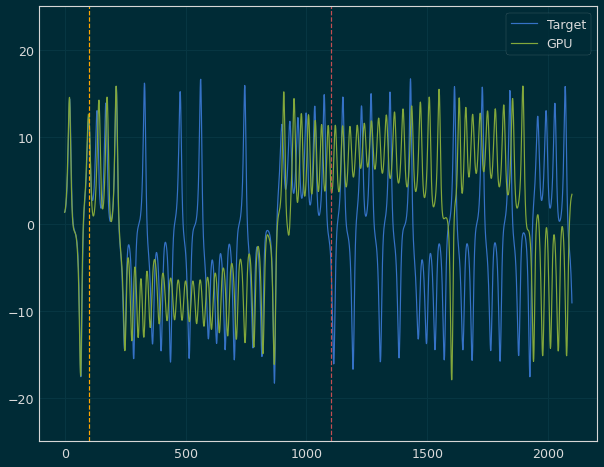

 Iter=59 a=0.163 sr=3.534 amp=0.890  ri=0.836 rr=3.533 loss=0.643762


Iter: 59 #### Diagnostic 0.643762   Time 6.26  Best 0.644 NRMSE 0.202 CD 0.442
Iter: 60 #### Diagnostic 1000.000000   Time 6.42  Best 0.644 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 12.61  Best 0.644 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 10.11  Best 0.644 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 11.63  Best 0.644 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 9.49  Best 0.644 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.434959   Time 9.26  Best 0.644 NRMSE 0.307 CD 1.128
Iter: 66 #### Diagnostic 1000.000000   Time 10.43  Best 0.644 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.45  Best 0.644 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 8.11  Best 0.644 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 13.88  Best 0.644 NRMSE 1000.000 CD nan
Iter: 70 #### Diagn

Iter: 53 #### Diagnostic 1.201302   Time 10.49  Best 1000.000 NRMSE 0.285 CD 0.916
Iter: 54 #### Diagnostic 1.464345   Time 7.59  Best 1000.000 NRMSE 0.296 CD 1.168
Iter: 55 #### Diagnostic 1000.000000   Time 14.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 11.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 10.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.206702   Time 8.68  Best 1000.000 NRMSE 0.280 CD 0.927
Iter: 59 #### Diagnostic 1000.000000   Time 12.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.242533   Time 7.92  Best 1000.000 NRMSE 0.289 CD 0.953
Iter: 61 #### Diagnostic 0.976517   Time 10.32  Best 1000.000 NRMSE 0.255 CD 0.722
Iter: 62 #### Diagnostic 1000.000000   Time 8.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 8.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.411158   Time 9.21  Best 1000.000 NRMSE 0

Iter: 47 #### Diagnostic 1.233796   Time 9.77  Best 1000.000 NRMSE 0.320 CD 0.913
Iter: 48 #### Diagnostic 1000.000000   Time 11.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 14.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 9.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.195050   Time 6.80  Best 1000.000 NRMSE 0.279 CD 0.916
Iter: 52 #### Diagnostic 1.276124   Time 11.99  Best 1000.000 NRMSE 0.362 CD 0.915
Iter: 53 #### Diagnostic 1.260366   Time 10.14  Best 1000.000 NRMSE 0.348 CD 0.913
Iter: 54 #### Diagnostic 1.374077   Time 11.17  Best 1000.000 NRMSE 0.344 CD 1.030
Iter: 55 #### Diagnostic 1000.000000   Time 10.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.417308   Time 9.46  Best 1000.000 NRMSE 0.334 CD 1.083
Iter: 57 #### Diagnostic 1000.000000   Time 12.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 13.53  Best 1000.000 NRMSE 

Iter: 42 #### Diagnostic 1000.000000   Time 12.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.237103   Time 8.70  Best 1000.000 NRMSE 0.319 CD 0.918
Iter: 44 #### Diagnostic 1000.000000   Time 12.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 10.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 13.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 10.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.281513   Time 6.97  Best 1000.000 NRMSE 0.293 CD 0.988
Iter: 49 #### Diagnostic 1000.000000   Time 12.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 10.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.394846   Time 11.64  Best 1000.000 NRMSE 0.329 CD 1.066
Iter: 52 #### Diagnostic 1.398140   Time 8.87  Best 1000.000 NRMSE 0.336 CD 1.063
Iter: 53 #### Diagnostic 1.284588   Time 5.77  Best 1000.000 N

Iter: 30 #### Diagnostic 1.473503   Time 11.27  Best 1000.000 NRMSE 0.346 CD 1.128
Iter: 31 #### Diagnostic 1000.000000   Time 13.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.191362   Time 11.05  Best 1000.000 NRMSE 0.295 CD 0.896
Iter: 33 #### Diagnostic 0.986519   Time 6.02  Best 1000.000 NRMSE 0.258 CD 0.729
Iter: 34 #### Diagnostic 0.996930   Time 7.06  Best 1000.000 NRMSE 0.257 CD 0.740
Iter: 35 #### Diagnostic 1000.000000   Time 10.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 10.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 14.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 9.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 12.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 8.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 11.46  Best 1000.00

Iter: 24 #### Diagnostic 0.973069   Time 7.03  Best 1000.000 NRMSE 0.253 CD 0.720
Iter: 25 #### Diagnostic 1.454847   Time 12.14  Best 1000.000 NRMSE 0.498 CD 0.956
Iter: 26 #### Diagnostic 1000.000000   Time 13.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 11.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 11.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 11.891607   Time 13.29  Best 1000.000 NRMSE 10.829 CD 1.063
Iter: 30 #### Diagnostic 1.250916   Time 7.53  Best 1000.000 NRMSE 0.288 CD 0.963
Iter: 31 #### Diagnostic 1.358497   Time 9.35  Best 1000.000 NRMSE 0.300 CD 1.058
Iter: 32 #### Diagnostic 1.239373   Time 11.76  Best 1000.000 NRMSE 0.278 CD 0.961
Iter: 33 #### Diagnostic 1000.000000   Time 9.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 9.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 12.51  Best 1000.000 NRMSE

Iter: 18 #### Diagnostic 1000.000000   Time 10.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 11.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 9.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 10.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.371240   Time 7.27  Best 1000.000 NRMSE 0.308 CD 1.063
Iter: 23 #### Diagnostic 1000.000000   Time 11.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 11.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 8.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 2.093825   Time 11.63  Best 1000.000 NRMSE 1.013 CD 1.081
Iter: 27 #### Diagnostic 1.243313   Time 7.02  Best 1000.000 NRMSE 0.297 CD 0.946
Iter: 28 #### Diagnostic 25.345815   Time 10.66  Best 1000.000 NRMSE 24.418 CD 0.928
Iter: 29 #### Diagnostic 1000.000000   Time 10.88  Best 1000.

Iter: 11 #### Diagnostic 1.231620   Time 10.76  Best 1000.000 NRMSE 0.290 CD 0.942
Iter: 12 #### Diagnostic 1000.000000   Time 9.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.101350   Time 7.14  Best 1000.000 NRMSE 0.284 CD 0.818
Iter: 14 #### Diagnostic 1.234074   Time 5.85  Best 1000.000 NRMSE 0.282 CD 0.952
Iter: 15 #### Diagnostic 1000.000000   Time 10.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 12.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 13.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.741961   Time 13.07  Best 1000.000 NRMSE 0.735 CD 1.007
Iter: 19 #### Diagnostic 1.152017   Time 7.12  Best 1000.000 NRMSE 0.276 CD 0.876
Iter: 20 #### Diagnostic 1.347245   Time 11.40  Best 1000.000 NRMSE 0.295 CD 1.052
Iter: 21 #### Diagnostic 1000.000000   Time 13.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 10.73  Best 1000.000 NRMSE 

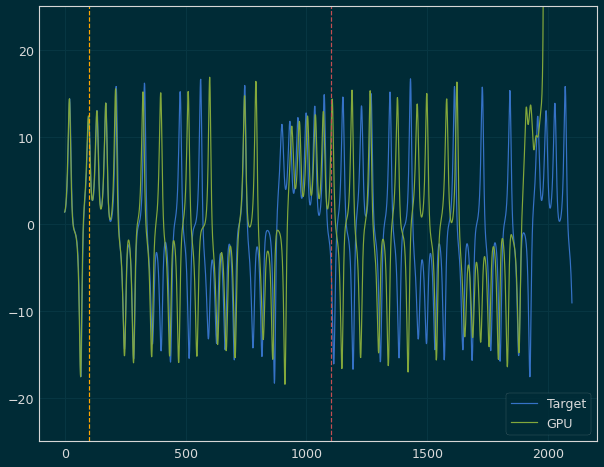

 Iter=53 a=0.466 sr=2.814 amp=0.923  ri=0.197 rr=2.262 loss=0.729608


Iter: 53 #### Diagnostic 0.729608   Time 9.75  Best 0.730 NRMSE 0.211 CD 0.519
Iter: 54 #### Diagnostic 2.225014   Time 11.65  Best 0.730 NRMSE 1.204 CD 1.021
Iter: 55 #### Diagnostic 1000.000000   Time 13.51  Best 0.730 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.359030   Time 11.32  Best 0.730 NRMSE 0.315 CD 1.044
Iter: 57 #### Diagnostic 1000.000000   Time 13.39  Best 0.730 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 12.12  Best 0.730 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 9.44  Best 0.730 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 9.72  Best 0.730 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.222161   Time 11.40  Best 0.730 NRMSE 0.249 CD 0.973
Iter: 62 #### Diagnostic 1000.000000   Time 13.66  Best 0.730 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.560132   Time 12.48  Best 0.730 NRMSE 0.454 CD 1.106
Iter: 64 #### Diagnostic 100

Iter: 48 #### Diagnostic 1.194667   Time 8.03  Best 1000.000 NRMSE 0.281 CD 0.914
Iter: 49 #### Diagnostic 1.167512   Time 10.82  Best 1000.000 NRMSE 0.299 CD 0.868
Iter: 50 #### Diagnostic 1000.000000   Time 10.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.343394   Time 10.32  Best 1000.000 NRMSE 0.307 CD 1.036
Iter: 52 #### Diagnostic 1.403036   Time 10.82  Best 1000.000 NRMSE 0.343 CD 1.060
Iter: 53 #### Diagnostic 0.874668   Time 6.76  Best 1000.000 NRMSE 0.235 CD 0.640
Iter: 54 #### Diagnostic 1.188544   Time 7.39  Best 1000.000 NRMSE 0.283 CD 0.906
Iter: 55 #### Diagnostic 1.004098   Time 12.09  Best 1000.000 NRMSE 0.255 CD 0.749
Iter: 56 #### Diagnostic 57.723928   Time 6.39  Best 1000.000 NRMSE 56.745 CD 0.979
Iter: 57 #### Diagnostic 1.362846   Time 8.82  Best 1000.000 NRMSE 0.321 CD 1.041
Iter: 58 #### Diagnostic 1.271319   Time 14.25  Best 1000.000 NRMSE 0.274 CD 0.998
Iter: 59 #### Diagnostic 1.305317   Time 6.33  Best 1000.000 NRMSE 0.302 CD 1.003
Iter

Iter: 36 #### Diagnostic 1000.000000   Time 13.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 13.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 10.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 9.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 10.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 0.950833   Time 14.06  Best 1000.000 NRMSE 0.243 CD 0.708
Iter: 42 #### Diagnostic 1.355205   Time 12.49  Best 1000.000 NRMSE 0.288 CD 1.067
Iter: 43 #### Diagnostic 1000.000000   Time 10.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.037377   Time 8.79  Best 1000.000 NRMSE 0.258 CD 0.780
Iter: 45 #### Diagnostic 1000.000000   Time 12.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 10.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 12.25  Best 1

Iter: 30 #### Diagnostic 1.388353   Time 8.69  Best 1000.000 NRMSE 0.318 CD 1.070
Iter: 31 #### Diagnostic 1.396937   Time 7.41  Best 1000.000 NRMSE 0.321 CD 1.076
Iter: 32 #### Diagnostic 1.378277   Time 11.16  Best 1000.000 NRMSE 0.316 CD 1.062
Iter: 33 #### Diagnostic 1000.000000   Time 12.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 11.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 8.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 10.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.330507   Time 7.33  Best 1000.000 NRMSE 0.354 CD 0.976
Iter: 38 #### Diagnostic 1000.000000   Time 10.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 10.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 13.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.134320   Time 7.46  Best 1000.000 NR

Iter: 24 #### Diagnostic 1000.000000   Time 10.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.616370   Time 13.33  Best 1000.000 NRMSE 0.630 CD 0.987
Iter: 26 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.353319   Time 9.20  Best 1000.000 NRMSE 0.272 CD 1.081
Iter: 28 #### Diagnostic 1000.000000   Time 13.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 11.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 14.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 13.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 11.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 12.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.416628   Time 5.57  Best 10

Iter: 18 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.101937   Time 9.50  Best 1000.000 NRMSE 0.304 CD 0.798
Iter: 20 #### Diagnostic 1.203334   Time 11.91  Best 1000.000 NRMSE 0.274 CD 0.929
Iter: 21 #### Diagnostic 1000.000000   Time 7.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 8.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.489304   Time 6.62  Best 1000.000 NRMSE 0.328 CD 1.161
Iter: 24 #### Diagnostic 1000.000000   Time 10.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.868398   Time 6.49  Best 1000.000 NRMSE 0.233 CD 0.636
Iter: 26 #### Diagnostic 1000.000000   Time 12.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 13.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.290374   Time 8.25  Best 1000.000 NRMSE 0.285 CD 1.005
Iter: 29 #### Diagnostic 1000.000000   Time 9.97  Best 1000.000 NRMSE 

Iter: 12 #### Diagnostic 1.106204   Time 6.04  Best 1000.000 NRMSE 0.265 CD 0.842
Iter: 13 #### Diagnostic 1.210195   Time 8.38  Best 1000.000 NRMSE 0.285 CD 0.925
Iter: 14 #### Diagnostic 1000.000000   Time 11.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 48.154573   Time 12.95  Best 1000.000 NRMSE 47.038 CD 1.117
Iter: 16 #### Diagnostic 1000.000000   Time 12.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 11.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.966764   Time 6.77  Best 1000.000 NRMSE 0.246 CD 0.721
Iter: 19 #### Diagnostic 1000.000000   Time 12.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.511311   Time 6.68  Best 1000.000 NRMSE 0.347 CD 1.165
Iter: 21 #### Diagnostic 1000.000000   Time 9.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 13.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 12.23  Best 1000.000 N

Iter: 2 #### Diagnostic 1.222158   Time 6.49  Best 1000.000 NRMSE 0.290 CD 0.932
Iter: 3 #### Diagnostic 1.227614   Time 6.37  Best 1000.000 NRMSE 0.273 CD 0.955
Iter: 4 #### Diagnostic 1000.000000   Time 8.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.403239   Time 7.21  Best 1000.000 NRMSE 0.324 CD 1.079
Iter: 6 #### Diagnostic 1000.000000   Time 13.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.176340   Time 6.05  Best 1000.000 NRMSE 0.280 CD 0.896
Iter: 8 #### Diagnostic 1000.000000   Time 11.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.274678   Time 6.35  Best 1000.000 NRMSE 0.251 CD 1.023
Iter: 10 #### Diagnostic 1000.000000   Time 11.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.212744   Time 6.39  Best 1000.000 NRMSE 0.293 CD 0.920
Iter: 12 #### Diagnostic 1.248334   Time 6.63  Best 1000.000 NRMSE 0.284 CD 0.965
Iter: 13 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
I

Iter: 99 #### Diagnostic 1.166007   Time 12.13  Best 1000.000 NRMSE 0.274 CD 0.892

Best result = 1.0140316379148502
a = 0.2851956128665385
sr = 5.830589538937186
amp = 0.2754990499021842
ri = 0.09706721834108503
rr = 4.869277228362749
********** Size 800 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 14.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 495.413763   Time 9.24  Best 1000.000 NRMSE 494.530 CD 0.884
Iter: 2 #### Diagnostic 1.268594   Time 10.75  Best 1000.000 NRMSE 0.283 CD 0.986
Iter: 3 #### Diagnostic 1000.000000   Time 13.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.346019   Time 6.19  Best 1000.000 NRMSE 0.301 CD 1.045
Iter: 6 #### Diagnostic 1.338182   Time 7.56  Best 1000.000 NRMSE 0.303 CD 1.035
Iter: 7 #### Diagnostic 1000.000000   Time 10.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 8.64  Be

Iter: 93 #### Diagnostic 1.379043   Time 7.04  Best 1000.000 NRMSE 0.314 CD 1.065
Iter: 94 #### Diagnostic 1000.000000   Time 9.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 9.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 11.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 11.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 13.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 13.33  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.9908362410300939
a = 0.5685138761415666
sr = 3.219854708867071
amp = 0.8196144039520704
ri = 0.20698702522185836
rr = 3.7223144439416824
********** Size 800 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 12.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.385896   Time 9.90  Best 1000.000 NRMSE 0.317 CD 1.068
Iter: 2 #### Diagnostic 1000.000000 

Iter: 87 #### Diagnostic 1000.000000   Time 10.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 11.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.396227   Time 7.09  Best 1000.000 NRMSE 0.324 CD 1.073
Iter: 90 #### Diagnostic 1.420058   Time 10.89  Best 1000.000 NRMSE 0.329 CD 1.091
Iter: 91 #### Diagnostic 1.341290   Time 5.86  Best 1000.000 NRMSE 0.355 CD 0.986
Iter: 92 #### Diagnostic 1000.000000   Time 8.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.406985   Time 8.46  Best 1000.000 NRMSE 0.294 CD 1.113
Iter: 94 #### Diagnostic 1000.000000   Time 11.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 2.767446   Time 12.45  Best 1000.000 NRMSE 1.611 CD 1.157
Iter: 96 #### Diagnostic 1000.000000   Time 11.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 10.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 2.640253   Time 10.88  Best 1000.000 NRMSE

Iter: 81 #### Diagnostic 1000.000000   Time 11.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.191206   Time 11.55  Best 1000.000 NRMSE 0.280 CD 0.912
Iter: 83 #### Diagnostic 1000.000000   Time 11.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 0.969967   Time 7.88  Best 1000.000 NRMSE 0.251 CD 0.719
Iter: 85 #### Diagnostic 1000.000000   Time 9.99  Best 1000.000 NRMSE 577750709.296 CD 0.765
Iter: 86 #### Diagnostic 1000.000000   Time 7.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 12.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.384294   Time 6.35  Best 1000.000 NRMSE 0.316 CD 1.068
Iter: 89 #### Diagnostic 1.378371   Time 13.49  Best 1000.000 NRMSE 0.297 CD 1.082
Iter: 90 #### Diagnostic 1.484426   Time 9.56  Best 1000.000 NRMSE 0.489 CD 0.996
Iter: 91 #### Diagnostic 1.285000   Time 9.80  Best 1000.000 NRMSE 0.301 CD 0.984
Iter: 92 #### Diagnostic 1000.000000   Time 12.14  Best 1000.000 N

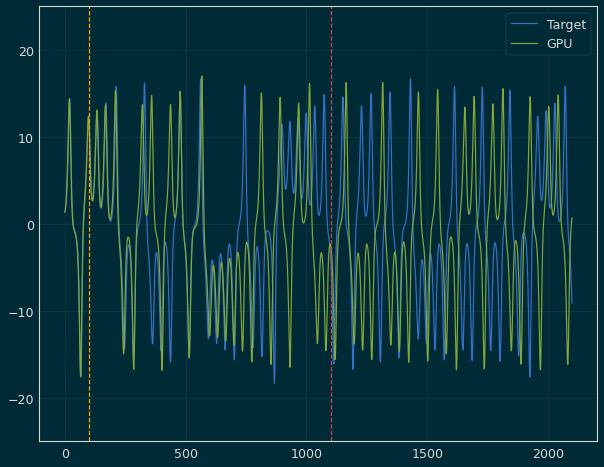

 Iter=10 a=0.450 sr=4.554 amp=0.338  ri=0.058 rr=2.332 loss=0.809963


Iter: 10 #### Diagnostic 0.809963   Time 12.94  Best 0.810 NRMSE 0.225 CD 0.585
Iter: 11 #### Diagnostic 1000.000000   Time 9.48  Best 0.810 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.565335   Time 6.86  Best 0.810 NRMSE 0.332 CD 1.233
Iter: 13 #### Diagnostic 1.454634   Time 6.52  Best 0.810 NRMSE 0.357 CD 1.098
Iter: 14 #### Diagnostic 1000.000000   Time 10.60  Best 0.810 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.15  Best 0.810 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 8.91  Best 0.810 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.404080   Time 9.05  Best 0.810 NRMSE 0.420 CD 0.984
Iter: 18 #### Diagnostic 1.384261   Time 6.73  Best 0.810 NRMSE 0.316 CD 1.068
Iter: 19 #### Diagnostic 1.529539   Time 9.77  Best 0.810 NRMSE 0.457 CD 1.073
Iter: 20 #### Diagnostic 1.294731   Time 9.01  Best 0.810 NRMSE 0.292 CD 1.003
Iter: 21 #### Diagnostic 1000.000000   Tim

Iter: 0 #### Diagnostic 1000.000000   Time 14.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.055474   Time 5.59  Best 1000.000 NRMSE 0.261 CD 0.794
Iter: 3 #### Diagnostic 1.338070   Time 6.40  Best 1000.000 NRMSE 0.325 CD 1.013
Iter: 4 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.259097   Time 5.70  Best 1000.000 NRMSE 0.290 CD 0.969
Iter: 6 #### Diagnostic 1000.000000   Time 13.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.282445   Time 6.90  Best 1000.000 NRMSE 0.300 CD 0.982
Iter: 8 #### Diagnostic 1000.000000   Time 10.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 5.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 11.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.250706   Time 7.20  Best 1000.000 NRMSE 0.286 CD 

Iter: 97 #### Diagnostic 1000.000000   Time 8.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 12.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.288179   Time 9.39  Best 1000.000 NRMSE 0.286 CD 1.002

Best result = 0.930084505305069
a = 0.41302827305541917
sr = 5.121472386681214
amp = 0.9597493095004264
ri = 0.8395275049441097
rr = 4.39608053464881
********** Size 700 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 11.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 72.463036   Time 8.58  Best 1000.000 NRMSE 71.425 CD 1.038
Iter: 2 #### Diagnostic 1.206364   Time 10.37  Best 1000.000 NRMSE 0.270 CD 0.937
Iter: 3 #### Diagnostic 1000.000000   Time 9.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 11.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 8.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.999345   Time 7.27  

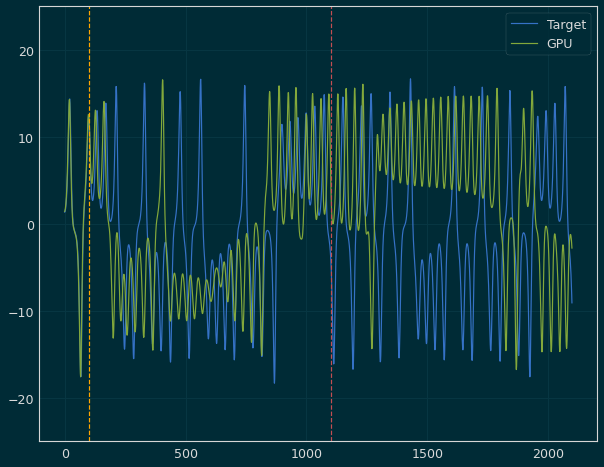

 Iter=86 a=0.144 sr=6.366 amp=0.408  ri=0.896 rr=0.291 loss=0.839061


Iter: 86 #### Diagnostic 0.839061   Time 7.99  Best 0.839 NRMSE 0.229 CD 0.611
Iter: 87 #### Diagnostic 1000.000000   Time 12.63  Best 0.839 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.338401   Time 9.16  Best 0.839 NRMSE 0.259 CD 1.079
Iter: 89 #### Diagnostic 1.628676   Time 6.00  Best 0.839 NRMSE 0.436 CD 1.193
Iter: 90 #### Diagnostic 1000.000000   Time 10.82  Best 0.839 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 9.02  Best 0.839 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 7.68  Best 0.839 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.021202   Time 6.76  Best 0.839 NRMSE 0.260 CD 0.761
Iter: 94 #### Diagnostic 1000.000000   Time 12.99  Best 0.839 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 8.92  Best 0.839 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.142740   Time 10.12  Best 0.839 NRMSE 0.219 CD 0.923
Iter: 97 #### Diagnostic 1000.00

Iter: 80 #### Diagnostic 1000.000000   Time 10.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.347569   Time 5.74  Best 1000.000 NRMSE 0.303 CD 1.044
Iter: 84 #### Diagnostic 1000.000000   Time 9.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.289718   Time 9.35  Best 1000.000 NRMSE 0.294 CD 0.995
Iter: 86 #### Diagnostic 1000.000000   Time 9.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 9.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 12.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.341955   Time 5.75  Best 1000.000 NRMSE 0.305 CD 1.037
Iter: 90 #### Diagnostic 0.869117   Time 7.60  Best 1000.000 NRMSE 0.236 CD 0.634
Iter: 91 #### Diagnostic 1.173828   Time 7.02  Best 1000.000 NRMSE 0

Iter: 74 #### Diagnostic 1.364259   Time 9.72  Best 1000.000 NRMSE 0.408 CD 0.956
Iter: 75 #### Diagnostic 1.465058   Time 5.99  Best 1000.000 NRMSE 0.331 CD 1.134
Iter: 76 #### Diagnostic 1000.000000   Time 9.02  Best 1000.000 NRMSE 9244835026503765713692938731520000.000 CD 1.000
Iter: 77 #### Diagnostic 1000.000000   Time 8.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 11.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 2.246109   Time 11.38  Best 1000.000 NRMSE 1.250 CD 0.996
Iter: 80 #### Diagnostic 1000.000000   Time 12.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 8.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 8.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 8.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 0.913444   Time 7.39  Best 1000.000 NRMSE 0.241 CD 0.673
Iter: 85 #### Diagnostic 1000.00000

Iter: 69 #### Diagnostic 1.060287   Time 9.76  Best 1000.000 NRMSE 0.263 CD 0.797
Iter: 70 #### Diagnostic 1.194929   Time 5.55  Best 1000.000 NRMSE 0.287 CD 0.908
Iter: 71 #### Diagnostic 1000.000000   Time 9.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 9.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 10.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.415637   Time 9.25  Best 1000.000 NRMSE 0.315 CD 1.101
Iter: 75 #### Diagnostic 1000.000000   Time 14.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.289429   Time 8.26  Best 1000.000 NRMSE 0.302 CD 0.987
Iter: 77 #### Diagnostic 1000.000000   Time 8.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 159.969068   Time 11.97  Best 1000.000 NRMSE 159.025 CD 0.944
Iter: 79 #### Diagnostic 1000.000000   Time 8.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 10.69  Best 1000.000 NR

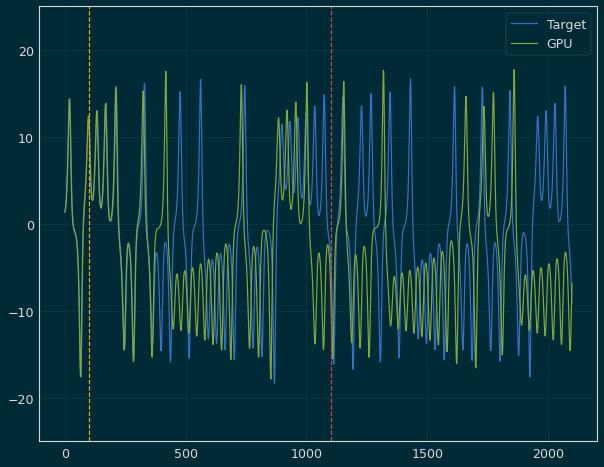

 Iter=97 a=0.554 sr=1.571 amp=0.984  ri=0.084 rr=1.575 loss=0.795547


Iter: 97 #### Diagnostic 0.795547   Time 7.89  Best 0.796 NRMSE 0.224 CD 0.572
Iter: 98 #### Diagnostic 1.281973   Time 8.21  Best 0.796 NRMSE 0.293 CD 0.989
Iter: 99 #### Diagnostic 1000.000000   Time 10.61  Best 0.796 NRMSE 1000.000 CD nan

Best result = 0.795547435467683
a = 0.5539279701476771
sr = 1.5711211051732081
amp = 0.9839900540226644
ri = 0.08385528723101854
rr = 1.5751937570155508

Best mn:0.144	 mn:0.554
New bounds mn--mx: 0.071--0.223

Best mn:1.571	 mn:6.366
New bounds mn--mx: 0.785--0.817

Best mn:0.408	 mn:0.984
New bounds mn--mx: 0.204--0.008

Best mn:0.084	 mn:0.896
New bounds mn--mx: 0.041--0.052

Best mn:0.291	 mn:1.575
New bounds mn--mx: 0.145--1.712
Refined search bounds:

Alpha (0.07225694225780803, 0.7769639850738386)

Rho (0.786060552586604, 7.182789832298358)

Gamma (0.2046562242158737, 0.9919950270113322)

r-in (0.04242764361550927, 0.9479406373613)

r-res (0.14603400817396806, 3.28759687

Iter: 84 #### Diagnostic 1000.000000   Time 9.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 10.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 11.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.086822   Time 7.62  Best 1000.000 NRMSE 0.269 CD 0.818
Iter: 88 #### Diagnostic 1000.000000   Time 9.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.205295   Time 6.62  Best 1000.000 NRMSE 0.281 CD 0.925
Iter: 90 #### Diagnostic 1000.000000   Time 10.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 9.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 10.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.235937   Time 7.76  Best 1000.000 NRMSE 0.286 CD 0.950
Iter: 94 #### Diagnostic 1.406044   Time 10.27  Best 1000.000 NRMSE 0.344 CD 1.062
Iter: 95 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 N

Iter: 79 #### Diagnostic 1000.000000   Time 11.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.076234   Time 9.60  Best 1000.000 NRMSE 0.265 CD 0.812
Iter: 81 #### Diagnostic 1000.000000   Time 11.59  Best 1000.000 NRMSE 229772742699495385464832.000 CD 1.000
Iter: 82 #### Diagnostic 1000.000000   Time 10.43  Best 1000.000 NRMSE 25861318880847788666519552.000 CD 1.000
Iter: 83 #### Diagnostic 1000.000000   Time 8.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.442912   Time 8.48  Best 1000.000 NRMSE 0.327 CD 1.116
Iter: 85 #### Diagnostic 1000.000000   Time 11.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1.398485   Time 12.95  Best 1000.000 NRMSE 0.312 CD 1.086
Iter: 87 #### Diagnostic 29.311254   Time 12.30  Best 1000.000 NRMSE 28.326 CD 0.986
Iter: 88 #### Diagnostic 1.185939   Time 6.77  Best 1000.000 NRMSE 0.293 CD 0.893
Iter: 89 #### Diagnostic 27.424071   Time 7.20  Best 1000.000 NRMSE 26.394 CD 1.030
Iter: 90 #### Diagnost

Iter: 73 #### Diagnostic 1.420719   Time 10.07  Best 1000.000 NRMSE 0.313 CD 1.108
Iter: 74 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 11.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.504836   Time 6.80  Best 1000.000 NRMSE 0.349 CD 1.155
Iter: 78 #### Diagnostic 1000.000000   Time 10.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 20.460361   Time 10.21  Best 1000.000 NRMSE 19.397 CD 1.064
Iter: 80 #### Diagnostic 1000.000000   Time 11.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 10.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.030589   Time 6.32  Best 1000.000 NRMSE 0.269 CD 0.761
Iter: 84 #### Diagnostic 1000.000000   Time 9.43  Best 1000.00

Iter: 67 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 50.523419   Time 6.60  Best 1000.000 NRMSE 49.642 CD 0.882
Iter: 69 #### Diagnostic 1000.000000   Time 10.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 8.673129   Time 9.16  Best 1000.000 NRMSE 7.693 CD 0.980
Iter: 71 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.570991   Time 7.83  Best 1000.000 NRMSE 0.576 CD 0.995
Iter: 73 #### Diagnostic 1000.000000   Time 8.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.401036   Time 8.51  Best 1000.000 NRMSE 0.306 CD 1.095
Iter: 76 #### Diagnostic 1.307516   Time 6.18  Best 1000.000 NRMSE 0.297 CD 1.010
Iter: 77 #### Diagnostic 1000.000000   Time 10.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 11.81  Best 1000.000 NRMSE

Iter: 61 #### Diagnostic 1.398576   Time 5.80  Best 1000.000 NRMSE 0.308 CD 1.091
Iter: 62 #### Diagnostic 821.654802   Time 12.14  Best 1000.000 NRMSE 820.813 CD 0.842


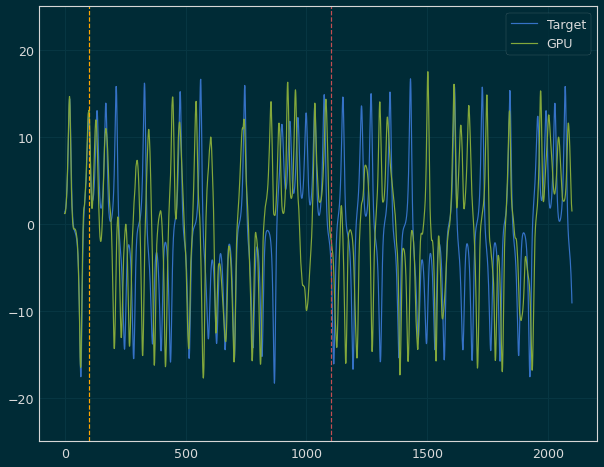

 Iter=63 a=0.883 sr=7.094 amp=0.841  ri=0.953 rr=4.445 loss=0.836521


Iter: 63 #### Diagnostic 0.836521   Time 6.80  Best 0.837 NRMSE 0.230 CD 0.606
Iter: 64 #### Diagnostic 1000.000000   Time 10.86  Best 0.837 NRMSE 2215108066028528.500 CD 0.874
Iter: 65 #### Diagnostic 1000.000000   Time 9.46  Best 0.837 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 0.971067   Time 5.69  Best 0.837 NRMSE 0.251 CD 0.720
Iter: 67 #### Diagnostic 1000.000000   Time 12.79  Best 0.837 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.322444   Time 6.57  Best 0.837 NRMSE 0.317 CD 1.006
Iter: 69 #### Diagnostic 1.027648   Time 5.52  Best 0.837 NRMSE 0.257 CD 0.770
Iter: 70 #### Diagnostic 1.386545   Time 6.67  Best 0.837 NRMSE 0.325 CD 1.062
Iter: 71 #### Diagnostic 6.360112   Time 11.87  Best 0.837 NRMSE 5.354 CD 1.006
Iter: 72 #### Diagnostic 1000.000000   Time 9.43  Best 0.837 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 9.25  Best 0.837 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnosti

Iter: 50 #### Diagnostic 1.170673   Time 7.01  Best 1000.000 NRMSE 0.276 CD 0.895
Iter: 51 #### Diagnostic 1.595200   Time 6.04  Best 1000.000 NRMSE 0.330 CD 1.266
Iter: 52 #### Diagnostic 1000.000000   Time 10.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.459929   Time 7.65  Best 1000.000 NRMSE 0.319 CD 1.141
Iter: 54 #### Diagnostic 1000.000000   Time 8.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 10.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.463218   Time 8.59  Best 1000.000 NRMSE 0.341 CD 1.122
Iter: 57 #### Diagnostic 2.146655   Time 9.06  Best 1000.000 NRMSE 0.956 CD 1.191
Iter: 58 #### Diagnostic 1000.000000   Time 11.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 7.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 9.69  Best 1000.000 NRMSE 1

Iter: 45 #### Diagnostic 1.014645   Time 7.27  Best 1000.000 NRMSE 0.250 CD 0.764
Iter: 46 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 8.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 10.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.355682   Time 11.34  Best 1000.000 NRMSE 0.292 CD 1.064
Iter: 50 #### Diagnostic 1000.000000   Time 9.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 7.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 14.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.414660   Time 6.06  Best 1000.000 NRMSE 0.317 CD 1.097
Iter: 54 #### Diagnostic 1000.000000   Time 12.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.466387   Time 7.02  Best 1000.000 NRMSE 0.396 CD 1.070
Iter: 56 #### Diagnostic 1.572515   Time 8.15  Best 1000.000 NRMSE

Iter: 39 #### Diagnostic 1.395069   Time 8.31  Best 1000.000 NRMSE 0.340 CD 1.055
Iter: 40 #### Diagnostic 1000.000000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 9.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.152332   Time 6.37  Best 1000.000 NRMSE 0.279 CD 0.874
Iter: 43 #### Diagnostic 1.380090   Time 11.41  Best 1000.000 NRMSE 0.326 CD 1.054
Iter: 44 #### Diagnostic 1000.000000   Time 10.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 8.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.075855   Time 5.43  Best 1000.000 NRMSE 0.269 CD 0.807
Iter: 47 #### Diagnostic 1.314652   Time 9.46  Best 1000.000 NRMSE 0.280 CD 1.035
Iter: 48 #### Diagnostic 1000.000000   Time 8.43  Best 1000.000 NRMSE 671887589192.466 CD 1.044
Iter: 49 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.211884   Time 7.44  Best 1000.000 N

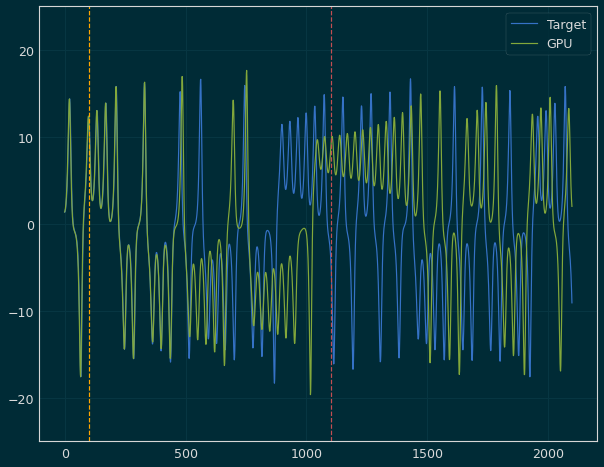

 Iter=73 a=0.482 sr=1.818 amp=0.768  ri=0.062 rr=0.846 loss=0.653205


Iter: 73 #### Diagnostic 0.653205   Time 7.87  Best 0.653 NRMSE 0.200 CD 0.453
Iter: 74 #### Diagnostic 1000.000000   Time 9.75  Best 0.653 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 7.14  Best 0.653 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 6.98  Best 0.653 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.301442   Time 7.42  Best 0.653 NRMSE 0.308 CD 0.993
Iter: 78 #### Diagnostic 1000.000000   Time 7.53  Best 0.653 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 28.413397   Time 8.20  Best 0.653 NRMSE 27.400 CD 1.013
Iter: 80 #### Diagnostic 1000.000000   Time 10.45  Best 0.653 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.292506   Time 8.03  Best 0.653 NRMSE 0.299 CD 0.993
Iter: 82 #### Diagnostic 1000.000000   Time 8.51  Best 0.653 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 6.94  Best 0.653 NRMSE 857555565758416909500416.000 CD 1.000
Iter: 8

Iter: 66 #### Diagnostic 1000.000000   Time 11.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 23.332900   Time 8.68  Best 1000.000 NRMSE 22.320 CD 1.012
Iter: 69 #### Diagnostic 1000.000000   Time 8.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 7.936109   Time 10.54  Best 1000.000 NRMSE 6.927 CD 1.009
Iter: 71 #### Diagnostic 0.909683   Time 9.72  Best 1000.000 NRMSE 0.245 CD 0.665
Iter: 72 #### Diagnostic 3.260380   Time 8.29  Best 1000.000 NRMSE 2.342 CD 0.919
Iter: 73 #### Diagnostic 1000.000000   Time 10.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 6.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.287097   Time 7.04  Best 1000.000 NRMSE 0.300 CD 0.987
Iter: 76 #### Diagnostic 1000.000000   Time 9.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 8.57  Best 1000.000 NRMSE

Iter: 61 #### Diagnostic 1.068601   Time 6.60  Best 1000.000 NRMSE 0.270 CD 0.799
Iter: 62 #### Diagnostic 797.631915   Time 7.30  Best 1000.000 NRMSE 796.790 CD 0.842
Iter: 63 #### Diagnostic 1.422419   Time 5.93  Best 1000.000 NRMSE 0.317 CD 1.105
Iter: 64 #### Diagnostic 1000.000000   Time 9.85  Best 1000.000 NRMSE 64554.670 CD 1.172
Iter: 65 #### Diagnostic 1.354747   Time 10.60  Best 1000.000 NRMSE 0.337 CD 1.018
Iter: 66 #### Diagnostic 1000.000000   Time 7.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 9.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.018233   Time 7.46  Best 1000.000 NRMSE 0.260 CD 0.758
Iter: 69 #### Diagnostic 1.296133   Time 11.04  Best 1000.000 NRMSE 0.293 CD 1.003
Iter: 70 #### Diagnostic 1.415401   Time 5.74  Best 1000.000 NRMSE 0.327 CD 1.088
Iter: 71 #### Diagnostic 1000.000000   Time 11.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 13.09  Best 1000.000 NRMSE 1

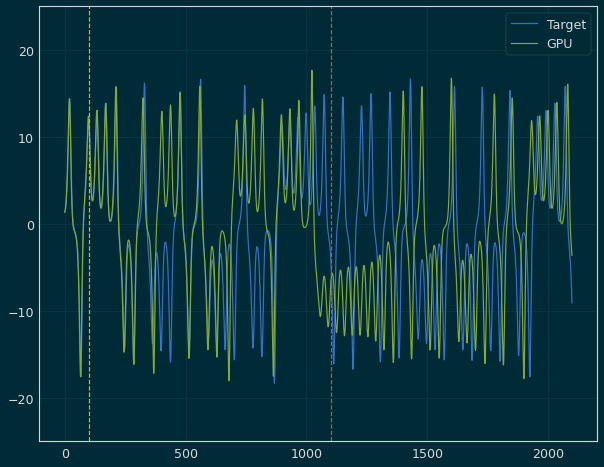

 Iter=11 a=0.994 sr=2.562 amp=0.789  ri=0.216 rr=4.756 loss=0.763158


Iter: 11 #### Diagnostic 0.763158   Time 9.74  Best 0.763 NRMSE 0.216 CD 0.547
Iter: 12 #### Diagnostic 1.230371   Time 6.64  Best 0.763 NRMSE 0.288 CD 0.942
Iter: 13 #### Diagnostic 1000.000000   Time 9.68  Best 0.763 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.348899   Time 10.34  Best 0.763 NRMSE 0.375 CD 0.974
Iter: 15 #### Diagnostic 1000.000000   Time 8.81  Best 0.763 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 8.07  Best 0.763 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 6.459104   Time 8.79  Best 0.763 NRMSE 5.472 CD 0.987
Iter: 18 #### Diagnostic 1000.000000   Time 9.16  Best 0.763 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 8.11  Best 0.763 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.255161   Time 6.72  Best 0.763 NRMSE 0.290 CD 0.965
Iter: 21 #### Diagnostic 1000.000000   Time 10.46  Best 0.763 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.0000

Iter: 8 #### Diagnostic 1000.000000   Time 11.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.514205   Time 6.22  Best 1000.000 NRMSE 0.318 CD 1.196
Iter: 10 #### Diagnostic 1000.000000   Time 8.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 11.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 11.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 9.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 9.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 11.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.356307   Time 12.28  Best 1000.000 NRMSE 0.299 CD 1.057
Iter: 18 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 10.87  Best 100

Iter: 2 #### Diagnostic 1000.000000   Time 11.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 2.645242   Time 11.38  Best 1000.000 NRMSE 1.633 CD 1.013
Iter: 4 #### Diagnostic 1000.000000   Time 11.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.781464   Time 10.24  Best 1000.000 NRMSE 0.801 CD 0.980
Iter: 6 #### Diagnostic 1.391815   Time 6.32  Best 1000.000 NRMSE 0.327 CD 1.065
Iter: 7 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1.216401   Time 7.38  Best 1000.000 NRMSE 0.220 CD 0.996
Iter: 9 #### Diagnostic 1.259176   Time 8.60  Best 1000.000 NRMSE 0.287 CD 0.972
Iter: 10 #### Diagnostic 1000.000000   Time 10.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 9.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 12.617761   Time 11.42  Best 1000.000 NRMSE 11.727 CD 0.891
Iter: 13 #### Diagnostic 1.402499   Time 5.58  Best 1000.000 NRMSE 0.313 CD 1.

Iter: 98 #### Diagnostic 1.455188   Time 10.38  Best 1000.000 NRMSE 0.561 CD 0.894
Iter: 99 #### Diagnostic 1000.000000   Time 11.66  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.080542783584997
a = 0.8870112279938467
sr = 4.026539040287347
amp = 0.5726653819682909
ri = 0.3430771605934951
rr = 3.048618934505236
********** Size 700 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.056059   Time 9.23  Best 1000.000 NRMSE 0.260 CD 0.796
Iter: 2 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 434907.827 CD 0.949
Iter: 3 #### Diagnostic 1000.000000   Time 9.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.227167   Time 5.76  Best 1000.000 NRMSE 0.285 CD 0.942
Iter: 5 #### Diagnostic 1.201457   Time 6.81  Best 1000.000 NRMSE 0.280 CD 0.921
Iter: 6 #### Diagnostic 1000.000000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 9.85  Be

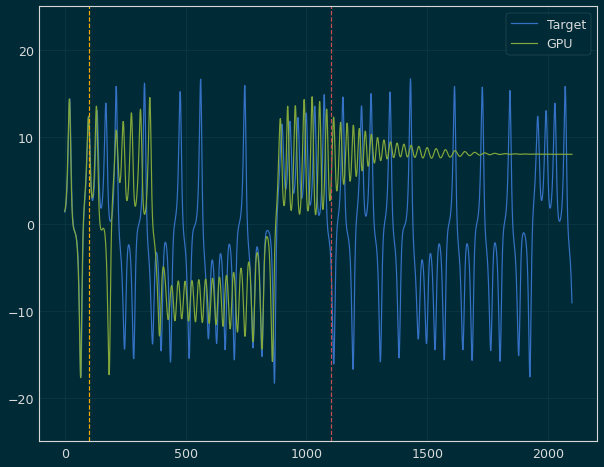

 Iter=19 a=0.162 sr=2.937 amp=0.965  ri=0.730 rr=3.640 loss=0.842159


Iter: 19 #### Diagnostic 0.842159   Time 7.65  Best 0.842 NRMSE 0.234 CD 0.608
Iter: 20 #### Diagnostic 1.312335   Time 8.53  Best 0.842 NRMSE 0.289 CD 1.023
Iter: 21 #### Diagnostic 1000.000000   Time 11.73  Best 0.842 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 10.12  Best 0.842 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.297743   Time 7.19  Best 0.842 NRMSE 0.294 CD 1.004
Iter: 24 #### Diagnostic 1000.000000   Time 9.08  Best 0.842 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.155413   Time 7.35  Best 0.842 NRMSE 0.280 CD 0.876
Iter: 26 #### Diagnostic 1000.000000   Time 8.95  Best 0.842 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 10.35  Best 0.842 NRMSE 1000.000 CD nan


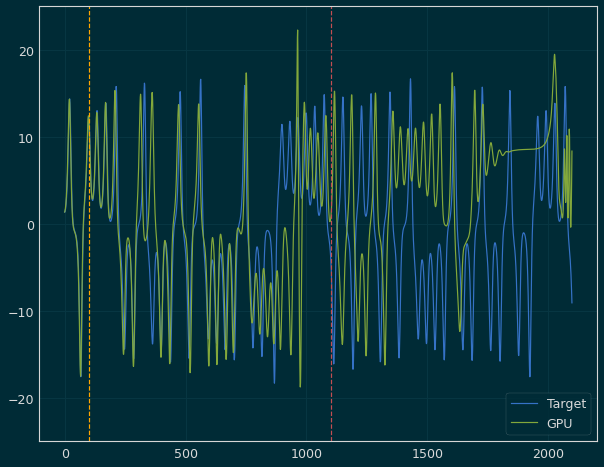

 Iter=28 a=0.182 sr=5.889 amp=0.772  ri=0.695 rr=1.763 loss=0.573373


Iter: 28 #### Diagnostic 0.573373   Time 11.05  Best 0.573 NRMSE 0.187 CD 0.386
Iter: 29 #### Diagnostic 1000.000000   Time 8.24  Best 0.573 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.298153   Time 5.54  Best 0.573 NRMSE 0.294 CD 1.005
Iter: 31 #### Diagnostic 1.407508   Time 8.74  Best 0.573 NRMSE 0.316 CD 1.091
Iter: 32 #### Diagnostic 1000.000000   Time 10.75  Best 0.573 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 6.76  Best 0.573 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 9.05  Best 0.573 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 8.67  Best 0.573 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 8.11  Best 0.573 NRMSE 1624.411 CD 0.870
Iter: 37 #### Diagnostic 1.170849   Time 8.08  Best 0.573 NRMSE 0.278 CD 0.893
Iter: 38 #### Diagnostic 1000.000000   Time 11.05  Best 0.573 NRMSE 424705160440377507840.000 CD 1.000
Iter: 39

Iter: 24 #### Diagnostic 1000.000000   Time 10.96  Best 1000.000 NRMSE 1000.000 CD nan


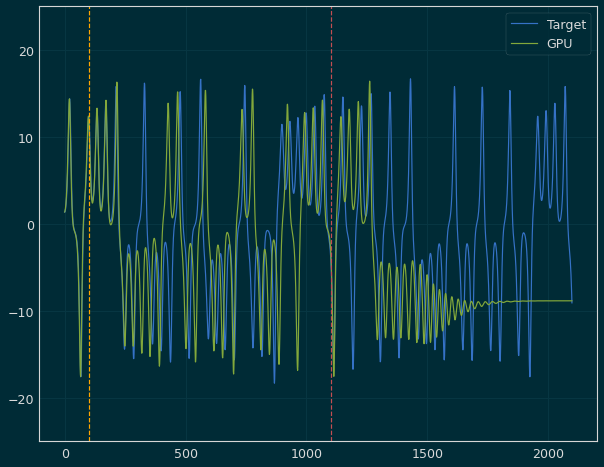

 Iter=25 a=0.256 sr=3.407 amp=0.557  ri=0.214 rr=0.971 loss=0.815493


Iter: 25 #### Diagnostic 0.815493   Time 8.38  Best 0.815 NRMSE 0.226 CD 0.589
Iter: 26 #### Diagnostic 1.656437   Time 8.63  Best 0.815 NRMSE 0.673 CD 0.984
Iter: 27 #### Diagnostic 1000.000000   Time 8.69  Best 0.815 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.81  Best 0.815 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.284681   Time 5.82  Best 0.815 NRMSE 0.292 CD 0.992
Iter: 30 #### Diagnostic 3.037592   Time 10.81  Best 0.815 NRMSE 1.961 CD 1.076
Iter: 31 #### Diagnostic 1000.000000   Time 8.63  Best 0.815 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 8.48  Best 0.815 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 10.45  Best 0.815 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.306920   Time 8.72  Best 0.815 NRMSE 0.322 CD 0.985
Iter: 35 #### Diagnostic 6.204537   Time 10.98  Best 0.815 NRMSE 5.218 CD 0.987
Iter: 36 #### Diagnostic 1000.000000 

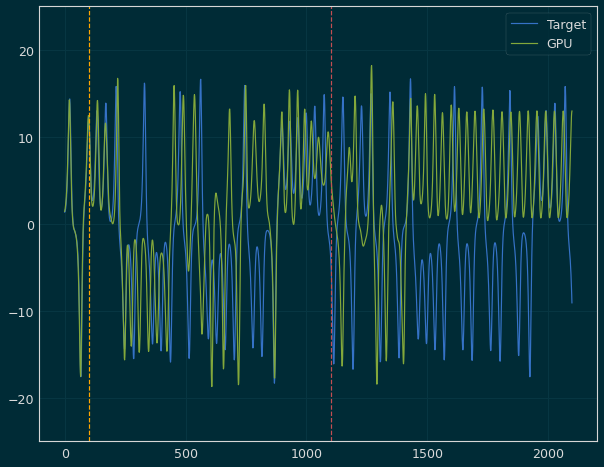

 Iter=98 a=0.561 sr=6.125 amp=0.668  ri=0.587 rr=0.898 loss=0.807929


Iter: 98 #### Diagnostic 0.807929   Time 7.27  Best 0.808 NRMSE 0.226 CD 0.582
Iter: 99 #### Diagnostic 1000.000000   Time 9.92  Best 0.808 NRMSE 1000.000 CD nan

Best result = 0.807929287093244
a = 0.5612140974593345
sr = 6.124590164053936
amp = 0.667567338875028
ri = 0.5870428698045103
rr = 0.8984516379695023

Best mn:0.162	 mn:0.994
New bounds mn--mx: -0.159---0.169

Best mn:2.562	 mn:6.125
New bounds mn--mx: -0.159---0.823

Best mn:0.557	 mn:0.965
New bounds mn--mx: -0.044---0.061

Best mn:0.214	 mn:0.730
New bounds mn--mx: -0.033---0.112

Best mn:0.898	 mn:4.756
New bounds mn--mx: -0.336---1.200
Refined search bounds:

Alpha (0.3208703518652164, 0.8248236535126263)

Rho (2.7203006449891287, 5.301435701784121)

Gamma (0.6011922118876185, 0.9036560838692536)

r-in (0.24685327166119958, 0.6180759442363151)

r-res (1.234645112574266, 3.5559089660117174)

End Refinement Run 3 Time 4566.592
********** Size 700 -- Run

Iter: 85 #### Diagnostic 1000.000000   Time 11.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 10.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.691475   Time 5.63  Best 1000.000 NRMSE 0.501 CD 1.190
Iter: 88 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.287749   Time 6.04  Best 1000.000 NRMSE 0.300 CD 0.988
Iter: 90 #### Diagnostic 1000.000000   Time 7.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 10.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 9.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.400763   Time 8.71  Best 1000.000 NRMSE 0.338 CD 1.062
Iter: 95 #### Diagnostic 1.588610   Time 9.80  Best 1000.000 NRMSE 0.595 CD 0.994
Iter: 96 #### Diagnostic 1000.000000   Time 9.72  Best 1000.000 NRM

Iter: 80 #### Diagnostic 1.173344   Time 11.68  Best 1000.000 NRMSE 0.277 CD 0.896
Iter: 81 #### Diagnostic 1000.000000   Time 9.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 9.78  Best 1000.000 NRMSE 565749786723516363571200.000 CD 1.000
Iter: 83 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.290752   Time 5.82  Best 1000.000 NRMSE 0.295 CD 0.996
Iter: 85 #### Diagnostic 1000.000000   Time 10.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1.044413   Time 5.79  Best 1000.000 NRMSE 0.254 CD 0.790
Iter: 87 #### Diagnostic 17.749680   Time 9.57  Best 1000.000 NRMSE 16.768 CD 0.982
Iter: 88 #### Diagnostic 1.982534   Time 7.83  Best 1000.000 NRMSE 1.002 CD 0.980
Iter: 89 #### Diagnostic 1.593111   Time 9.39  Best 1000.000 NRMSE 0.464 CD 1.129
Iter: 90 #### Diagnostic 1000.000000   Time 8.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 9.87  Be

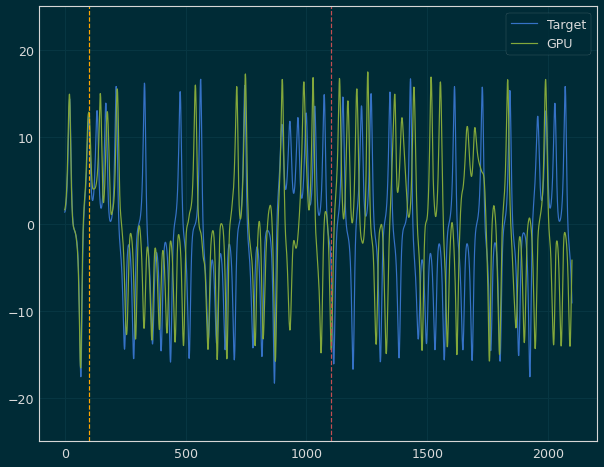

 Iter=36 a=0.440 sr=6.834 amp=0.969  ri=0.720 rr=2.051 loss=0.758633


Iter: 36 #### Diagnostic 0.758633   Time 11.72  Best 0.759 NRMSE 0.214 CD 0.544
Iter: 37 #### Diagnostic 1000.000000   Time 10.57  Best 0.759 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 7.04  Best 0.759 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.335154   Time 8.68  Best 0.759 NRMSE 0.410 CD 0.925
Iter: 40 #### Diagnostic 1000.000000   Time 10.04  Best 0.759 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 4.972135   Time 8.33  Best 0.759 NRMSE 3.983 CD 0.989
Iter: 42 #### Diagnostic 1.446365   Time 6.87  Best 0.759 NRMSE 0.317 CD 1.129
Iter: 43 #### Diagnostic 1.385082   Time 8.45  Best 0.759 NRMSE 0.328 CD 1.057
Iter: 44 #### Diagnostic 1000.000000   Time 7.26  Best 0.759 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.70  Best 0.759 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.499230   Time 7.30  Best 0.759 NRMSE 0.312 CD 1.187
Iter: 47 #### Diagnostic 1.124991   T

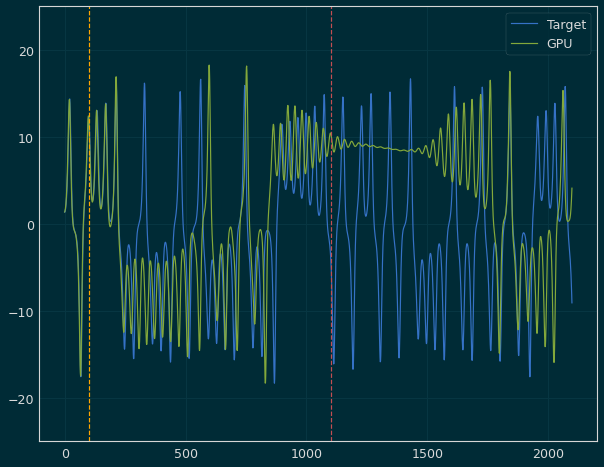

 Iter=89 a=0.285 sr=6.742 amp=0.449  ri=0.866 rr=2.415 loss=0.724725


Iter: 89 #### Diagnostic 0.724725   Time 7.13  Best 0.725 NRMSE 0.216 CD 0.508
Iter: 90 #### Diagnostic 0.986115   Time 7.36  Best 0.725 NRMSE 0.255 CD 0.731
Iter: 91 #### Diagnostic 1.183718   Time 5.66  Best 0.725 NRMSE 0.291 CD 0.892
Iter: 92 #### Diagnostic 1000.000000   Time 8.86  Best 0.725 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 6.335960   Time 7.47  Best 0.725 NRMSE 5.399 CD 0.937
Iter: 94 #### Diagnostic 185.326293   Time 7.50  Best 0.725 NRMSE 184.326 CD 1.000
Iter: 95 #### Diagnostic 4.753741   Time 7.86  Best 0.725 NRMSE 3.925 CD 0.828
Iter: 96 #### Diagnostic 1000.000000   Time 11.23  Best 0.725 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 10.85  Best 0.725 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.425684   Time 7.82  Best 0.725 NRMSE 0.494 CD 0.931
Iter: 99 #### Diagnostic 1000.000000   Time 9.57  Best 0.725 NRMSE 1000.000 CD nan

Best result = 0.7247249158071621
a = 

Iter: 83 #### Diagnostic 1000.000000   Time 8.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.163244   Time 6.98  Best 1000.000 NRMSE 0.279 CD 0.884
Iter: 85 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 857265219.522 CD 0.778
Iter: 86 #### Diagnostic 1000.000000   Time 11.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.331165   Time 10.55  Best 1000.000 NRMSE 0.298 CD 1.033
Iter: 88 #### Diagnostic 1.374149   Time 6.67  Best 1000.000 NRMSE 0.308 CD 1.066
Iter: 89 #### Diagnostic 1.383418   Time 9.78  Best 1000.000 NRMSE 0.298 CD 1.085
Iter: 90 #### Diagnostic 1.497978   Time 9.66  Best 1000.000 NRMSE 0.344 CD 1.154
Iter: 91 #### Diagnostic 1000.000000   Time 10.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 0.987998   Time 11.21  Best 1000.000 NRMSE 0.242 CD 0.746
Iter: 93 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.699944   Time 13.39  Best 1000.000 NRMSE

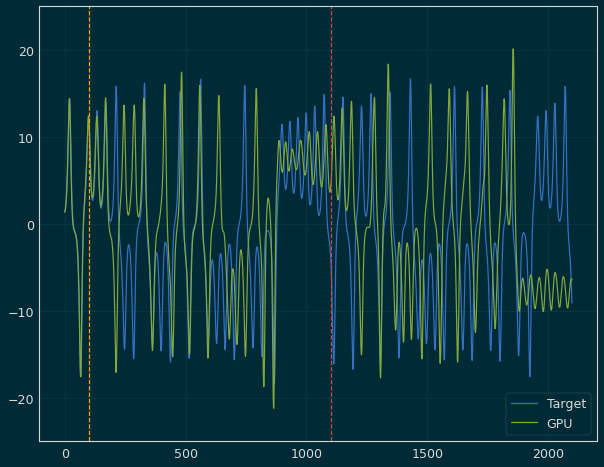

 Iter=18 a=0.385 sr=2.949 amp=0.800  ri=0.407 rr=3.223 loss=0.834364


Iter: 18 #### Diagnostic 0.834364   Time 6.66  Best 0.834 NRMSE 0.229 CD 0.605
Iter: 19 #### Diagnostic 1.327639   Time 9.85  Best 0.834 NRMSE 0.468 CD 0.860
Iter: 20 #### Diagnostic 1.328697   Time 6.14  Best 0.834 NRMSE 0.303 CD 1.026
Iter: 21 #### Diagnostic 1000.000000   Time 11.13  Best 0.834 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 11.33  Best 0.834 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 2.037759   Time 12.84  Best 0.834 NRMSE 1.060 CD 0.978
Iter: 24 #### Diagnostic 6.244348   Time 12.68  Best 0.834 NRMSE 5.160 CD 1.084
Iter: 25 #### Diagnostic 1.361202   Time 6.46  Best 0.834 NRMSE 0.399 CD 0.962
Iter: 26 #### Diagnostic 1.998823   Time 8.17  Best 0.834 NRMSE 1.019 CD 0.980
Iter: 27 #### Diagnostic 1000.000000   Time 13.75  Best 0.834 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.12  Best 0.834 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   

Iter: 7 #### Diagnostic 1.069625   Time 7.24  Best 1000.000 NRMSE 0.272 CD 0.797
Iter: 8 #### Diagnostic 1000.000000   Time 8.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.290236   Time 9.12  Best 1000.000 NRMSE 0.292 CD 0.998
Iter: 10 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 32035299225626780884845723648.000 CD 1.000
Iter: 12 #### Diagnostic 1.415840   Time 7.46  Best 1000.000 NRMSE 0.308 CD 1.108
Iter: 13 #### Diagnostic 1000.000000   Time 7.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.166969   Time 9.39  Best 1000.000 NRMSE 0.316 CD 0.851
Iter: 15 #### Diagnostic 1000.000000   Time 8.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 5.816265   Time 9.49  Best 1000.000 NRMSE 4.714 CD 1.103
Iter: 18 #### Diagnostic 1000.000000   Time 6.14  

Iter: 2 #### Diagnostic 1.111187   Time 7.94  Best 1000.000 NRMSE 0.251 CD 0.860
Iter: 3 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 7.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.083848   Time 5.88  Best 1000.000 NRMSE 0.274 CD 0.810
Iter: 7 #### Diagnostic 1000.000000   Time 8.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 10.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.245892   Time 5.70  Best 1000.000 NRMSE 0.298 CD 0.948
Iter: 10 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 9.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 11.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.79  Best 1000.000 NRMSE 10

Iter: 98 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 8.91  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.0452037518144472
a = 0.8701507704448573
sr = 2.2478428329727866
amp = 0.961687750647634
ri = 0.10035273562491688
rr = 3.0635038950457676
********** Size 600 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 10.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.378803   Time 8.73  Best 1000.000 NRMSE 0.314 CD 1.065
Iter: 2 #### Diagnostic 1000.000000   Time 6.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 10.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 10.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 9.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.328947   Time 6.52  Best 1000.000 NRMSE 0.304 CD 1.024
Iter: 7 #### Diagnostic 1000.000000   Time 

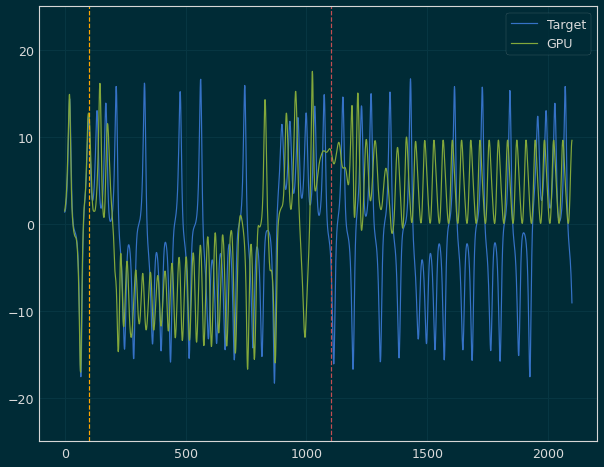

 Iter=60 a=0.597 sr=7.862 amp=0.617  ri=0.572 rr=3.550 loss=0.805899


Iter: 60 #### Diagnostic 0.805899   Time 5.86  Best 0.806 NRMSE 0.230 CD 0.575
Iter: 61 #### Diagnostic 1.208690   Time 7.82  Best 0.806 NRMSE 0.321 CD 0.888
Iter: 62 #### Diagnostic 1000.000000   Time 11.69  Best 0.806 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 7.82  Best 0.806 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 73.365566   Time 9.10  Best 0.806 NRMSE 72.404 CD 0.962
Iter: 65 #### Diagnostic 1000.000000   Time 8.75  Best 0.806 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 8.10  Best 0.806 NRMSE 71253842.254 CD 1.085
Iter: 67 #### Diagnostic 1000.000000   Time 9.34  Best 0.806 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 7.37  Best 0.806 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.441209   Time 9.94  Best 0.806 NRMSE 0.312 CD 1.130
Iter: 70 #### Diagnostic 1000.000000   Time 8.50  Best 0.806 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnosti

Iter: 55 #### Diagnostic 1000.000000   Time 10.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.402535   Time 7.83  Best 1000.000 NRMSE 0.330 CD 1.073
Iter: 57 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 8.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 10.44  Best 1000.000 NRMSE 32077190426854305792.000 CD 1.000
Iter: 62 #### Diagnostic 1000.000000   Time 8.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.262825   Time 9.37  Best 1000.000 NRMSE 0.306 CD 0.956
Iter: 64 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.024531   Time 7.33  Best 1000.000 NRMSE 0.273 CD 0.751
Iter: 66 #### Diagnostic 1000.000000   Time 8.

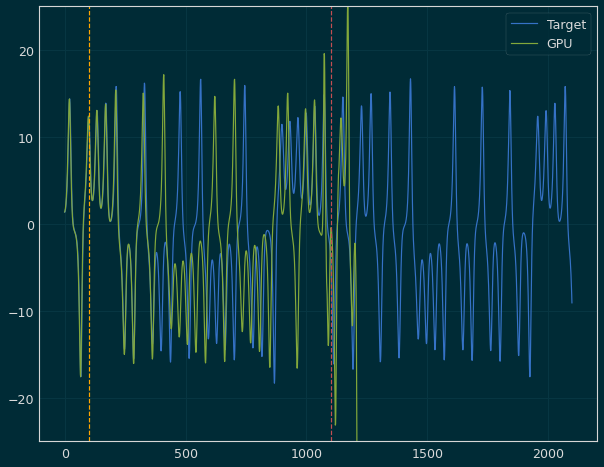

 Iter=81 a=0.625 sr=2.260 amp=0.852  ri=0.573 rr=2.977 loss=0.838437


Iter: 81 #### Diagnostic 0.838437   Time 8.16  Best 0.838 NRMSE 0.230 CD 0.608
Iter: 82 #### Diagnostic 1000.000000   Time 8.20  Best 0.838 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 8.82  Best 0.838 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 6.98  Best 0.838 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 6.82  Best 0.838 NRMSE 91286822152941424.000 CD 1.000
Iter: 86 #### Diagnostic 1000.000000   Time 7.85  Best 0.838 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.373342   Time 10.00  Best 0.838 NRMSE 0.294 CD 1.080
Iter: 88 #### Diagnostic 1.163540   Time 7.79  Best 0.838 NRMSE 0.279 CD 0.885
Iter: 89 #### Diagnostic 1.345565   Time 7.53  Best 0.838 NRMSE 0.293 CD 1.053
Iter: 90 #### Diagnostic 1000.000000   Time 10.76  Best 0.838 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 9.91  Best 0.838 NRMSE 1000.000 CD nan
Iter: 92 #### D

Iter: 75 #### Diagnostic 1000.000000   Time 9.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.171262   Time 11.53  Best 1000.000 NRMSE 0.280 CD 0.891
Iter: 78 #### Diagnostic 1000.000000   Time 9.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 10.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 7.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.345821   Time 7.01  Best 1000.000 NRMSE 0.338 CD 1.008
Iter: 83 #### Diagnostic 1000.000000   Time 9.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 9.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 7.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 624.247241   Time 7.48  Best 1000.0

Iter: 63 #### Diagnostic 1000.000000   Time 8.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.386978   Time 8.26  Best 1000.000 NRMSE 0.309 CD 1.078
Iter: 66 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 37.210101   Time 9.96  Best 1000.000 NRMSE 36.107 CD 1.103
Iter: 68 #### Diagnostic 1.511728   Time 11.02  Best 1000.000 NRMSE 0.527 CD 0.985
Iter: 69 #### Diagnostic 1000.000000   Time 10.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.112356   Time 4.78  Best 1000.000 NRMSE 0.274 CD 0.839
Iter: 71 #### Diagnostic 1000.000000   Time 10.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.181136   Time 6.54  Best 1000.000 NRMSE 0.282 CD 0.900
Iter: 73 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE

Iter: 57 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.175446   Time 6.25  Best 1000.000 NRMSE 0.287 CD 0.888
Iter: 60 #### Diagnostic 1000.000000   Time 9.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 6.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 6.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 9.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.655253   Time 7.26  Best 1000.000 NRMSE 0.664 CD 0.991
Iter: 65 #### Diagnostic 1000.000000   Time 9.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.96  Best 1000.00

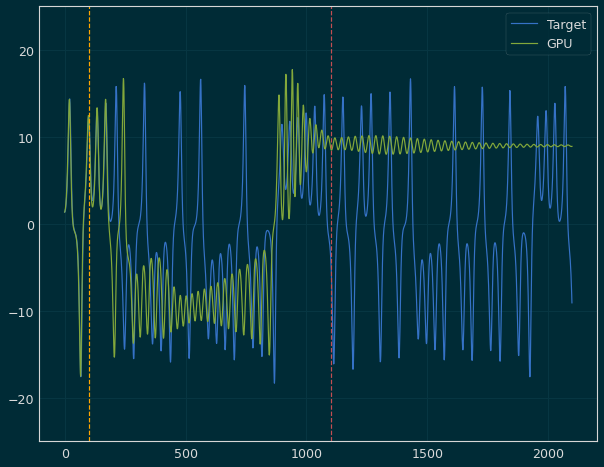

 Iter=13 a=0.143 sr=2.419 amp=0.807  ri=0.320 rr=0.107 loss=0.787516


Iter: 13 #### Diagnostic 0.787516   Time 6.66  Best 0.788 NRMSE 0.235 CD 0.553
Iter: 14 #### Diagnostic 1000.000000   Time 7.23  Best 0.788 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 10.73  Best 0.788 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.285575   Time 7.79  Best 0.788 NRMSE 0.278 CD 1.007
Iter: 17 #### Diagnostic 1000.000000   Time 9.98  Best 0.788 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 10.00  Best 0.788 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 11.57  Best 0.788 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 7.66  Best 0.788 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 8.18  Best 0.788 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.443691   Time 7.12  Best 0.788 NRMSE 0.315 CD 1.129
Iter: 23 #### Diagnostic 1000.000000   Time 11.22  Best 0.788 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic

Iter: 9 #### Diagnostic 1000.000000   Time 9.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 8.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.184966   Time 5.44  Best 1000.000 NRMSE 0.288 CD 0.897
Iter: 12 #### Diagnostic 1000.000000   Time 7.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.388141   Time 5.87  Best 1000.000 NRMSE 0.360 CD 1.028
Iter: 14 #### Diagnostic 1.125033   Time 6.27  Best 1000.000 NRMSE 0.290 CD 0.835
Iter: 15 #### Diagnostic 1000.000000   Time 7.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 7.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.739215   Time 9.97  Best 1000.000 NRMSE 0.741 CD 0.999
Iter: 19 #### Diagnostic 1.147106   Time 5.74  Best 1000.000 NRMSE 0.284 CD 0.863
Iter: 20 #### Diagnostic 1.254398   Time 8.43  Best 1000.000 NRMSE 0.282 CD

Iter: 4 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 9.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 7.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 8.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.101050   Time 7.24  Best 1000.000 NRMSE 0.272 CD 0.829
Iter: 11 #### Diagnostic 1000.000000   Time 9.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.282687   Time 6.84  Best 1000.000 NRMSE 0.269 CD 1.013
Iter: 13 #### Diagnostic 1.232836   Time 6.76  Best 1000.000 NRMSE 0.306 CD 0.927
Iter: 14 #### Diagnostic 1000.000000   Time 7.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.05  Best 1000.000 NRMSE 10

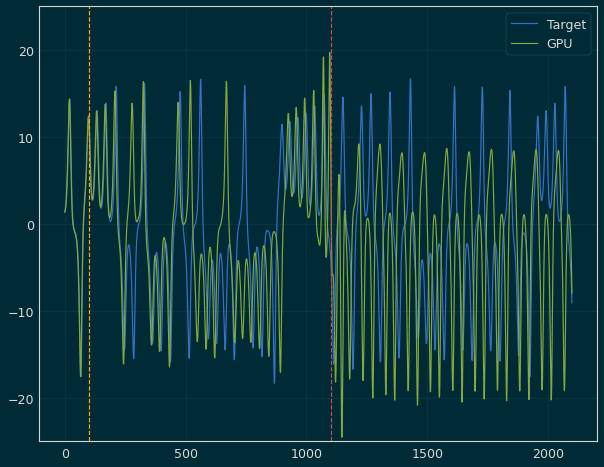

 Iter=40 a=0.608 sr=2.747 amp=0.826  ri=0.355 rr=2.982 loss=0.781371


Iter: 40 #### Diagnostic 0.781371   Time 5.64  Best 0.781 NRMSE 0.222 CD 0.559
Iter: 41 #### Diagnostic 1000.000000   Time 7.02  Best 0.781 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 7.31  Best 0.781 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 29.353930   Time 6.27  Best 0.781 NRMSE 28.353 CD 1.001
Iter: 44 #### Diagnostic 1000.000000   Time 9.38  Best 0.781 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 8.34  Best 0.781 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 9.57  Best 0.781 NRMSE 285859947140597776384.000 CD 1.000
Iter: 47 #### Diagnostic 1000.000000   Time 8.18  Best 0.781 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.353005   Time 5.90  Best 0.781 NRMSE 0.300 CD 1.053
Iter: 49 #### Diagnostic 1.368084   Time 6.70  Best 0.781 NRMSE 0.330 CD 1.038
Iter: 50 #### Diagnostic 1.229508   Time 6.94  Best 0.781 NRMSE 0.286 CD 0.944
Iter: 51 #### D

Iter: 29 #### Diagnostic 1.366855   Time 6.53  Best 1000.000 NRMSE 0.305 CD 1.062
Iter: 30 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 10.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.500933   Time 6.89  Best 1000.000 NRMSE 0.342 CD 1.159
Iter: 33 #### Diagnostic 1.298135   Time 5.79  Best 1000.000 NRMSE 0.296 CD 1.002
Iter: 34 #### Diagnostic 1.535989   Time 5.61  Best 1000.000 NRMSE 0.336 CD 1.200
Iter: 35 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 6.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 9.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 7.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.252632   Time 10.12  Best 1000.000 NRMSE 0

Iter: 24 #### Diagnostic 1.433953   Time 5.62  Best 1000.000 NRMSE 0.314 CD 1.120
Iter: 25 #### Diagnostic 1000.000000   Time 10.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 7.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.038176   Time 9.47  Best 1000.000 NRMSE 0.271 CD 0.767
Iter: 29 #### Diagnostic 26.142692   Time 8.99  Best 1000.000 NRMSE 25.212 CD 0.931
Iter: 30 #### Diagnostic 1.445265   Time 6.28  Best 1000.000 NRMSE 0.330 CD 1.116
Iter: 31 #### Diagnostic 1.148295   Time 7.08  Best 1000.000 NRMSE 0.280 CD 0.868
Iter: 32 #### Diagnostic 0.974510   Time 7.14  Best 1000.000 NRMSE 0.242 CD 0.733
Iter: 33 #### Diagnostic 1000.000000   Time 7.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 9.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.

Iter: 19 #### Diagnostic 1000.000000   Time 8.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 9.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 8.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 9.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.162605   Time 6.05  Best 1000.000 NRMSE 0.288 CD 0.874
Iter: 28 #### Diagnostic 44.464402   Time 6.50  Best 1000.000 NRMSE 43.481 CD 0.983
Iter: 29 #### Diagnostic 1000.000000   Time 10.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 8.68  Best 1000

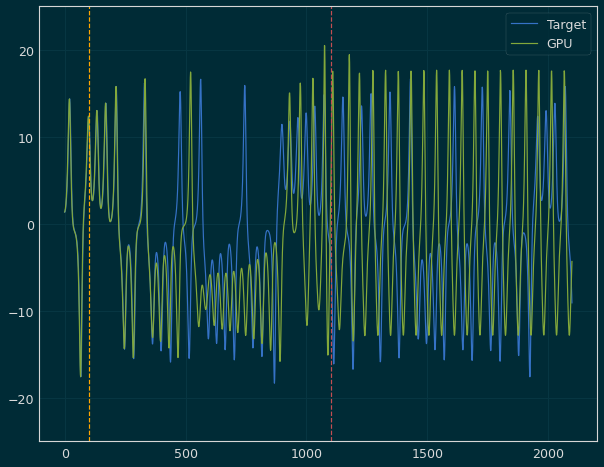

 Iter=73 a=0.482 sr=1.818 amp=0.768  ri=0.062 rr=0.846 loss=0.733798


Iter: 73 #### Diagnostic 0.733798   Time 9.97  Best 0.734 NRMSE 0.217 CD 0.517
Iter: 74 #### Diagnostic 1000.000000   Time 8.42  Best 0.734 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 10.20  Best 0.734 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 6.81  Best 0.734 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.303182   Time 5.37  Best 0.734 NRMSE 0.299 CD 1.004
Iter: 78 #### Diagnostic 1000.000000   Time 9.91  Best 0.734 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 12.057068   Time 6.69  Best 0.734 NRMSE 11.057 CD 1.000
Iter: 80 #### Diagnostic 1000.000000   Time 6.66  Best 0.734 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.815205   Time 8.24  Best 0.734 NRMSE 0.230 CD 0.585
Iter: 82 #### Diagnostic 1000.000000   Time 12.17  Best 0.734 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.316622   Time 5.54  Best 0.734 NRMSE 0.284 CD 1.032
Iter: 84 #### Diagnostic 1000.00

Iter: 68 #### Diagnostic 116.992132   Time 9.05  Best 1000.000 NRMSE 116.054 CD 0.938
Iter: 69 #### Diagnostic 1000.000000   Time 9.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 14.404554   Time 7.61  Best 1000.000 NRMSE 13.514 CD 0.890
Iter: 71 #### Diagnostic 1000.000000   Time 7.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 3.503433   Time 9.64  Best 1000.000 NRMSE 2.658 CD 0.845
Iter: 73 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 1000.000 CD nan


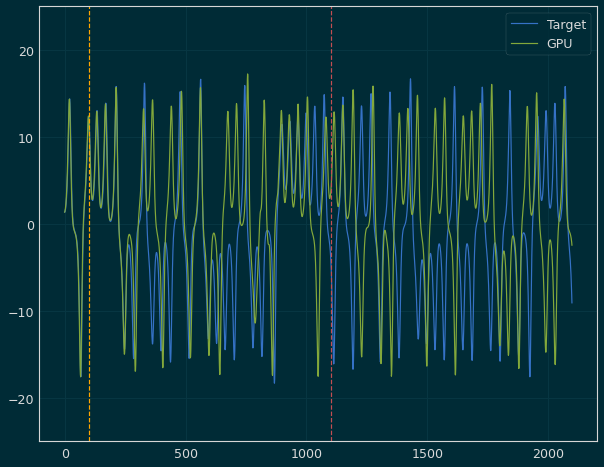

 Iter=74 a=0.806 sr=4.927 amp=0.503  ri=0.493 rr=1.179 loss=0.730370


Iter: 74 #### Diagnostic 0.730370   Time 6.05  Best 0.730 NRMSE 0.210 CD 0.520
Iter: 75 #### Diagnostic 1.200665   Time 5.81  Best 0.730 NRMSE 0.261 CD 0.939
Iter: 76 #### Diagnostic 1000.000000   Time 10.14  Best 0.730 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 7.46  Best 0.730 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.384038   Time 7.71  Best 0.730 NRMSE 0.313 CD 1.071
Iter: 79 #### Diagnostic 1.801263   Time 9.02  Best 0.730 NRMSE 0.849 CD 0.952
Iter: 80 #### Diagnostic 1.431988   Time 7.44  Best 0.730 NRMSE 0.315 CD 1.117
Iter: 81 #### Diagnostic 1000.000000   Time 7.57  Best 0.730 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 8.88  Best 0.730 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 10.75  Best 0.730 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.232817   Time 6.24  Best 0.730 NRMSE 0.283 CD 0.950
Iter: 85 #### Diagnostic 1000.000000  

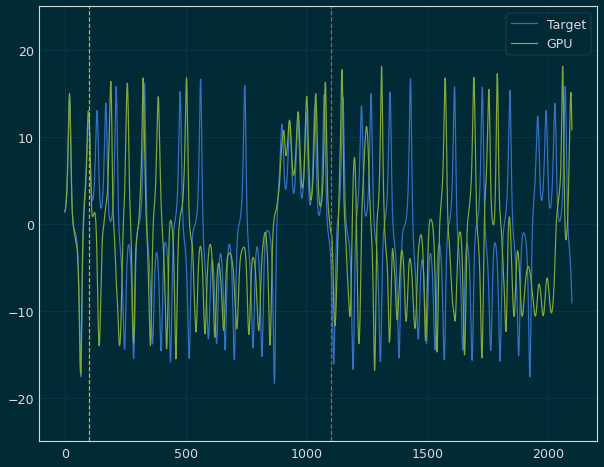

 Iter=61 a=0.722 sr=5.386 amp=0.751  ri=0.471 rr=0.660 loss=0.835572


Iter: 61 #### Diagnostic 0.835572   Time 7.54  Best 0.836 NRMSE 0.229 CD 0.607
Iter: 62 #### Diagnostic 1000.000000   Time 8.76  Best 0.836 NRMSE 7192.586 CD 0.953
Iter: 63 #### Diagnostic 1.321787   Time 5.42  Best 0.836 NRMSE 0.299 CD 1.023
Iter: 64 #### Diagnostic 1000.000000   Time 7.90  Best 0.836 NRMSE 11479742788820959232.000 CD 1.000
Iter: 65 #### Diagnostic 1000.000000   Time 7.73  Best 0.836 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.25  Best 0.836 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 10.62  Best 0.836 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.133158   Time 7.24  Best 0.836 NRMSE 0.284 CD 0.850
Iter: 69 #### Diagnostic 1.462831   Time 5.81  Best 0.836 NRMSE 0.319 CD 1.144


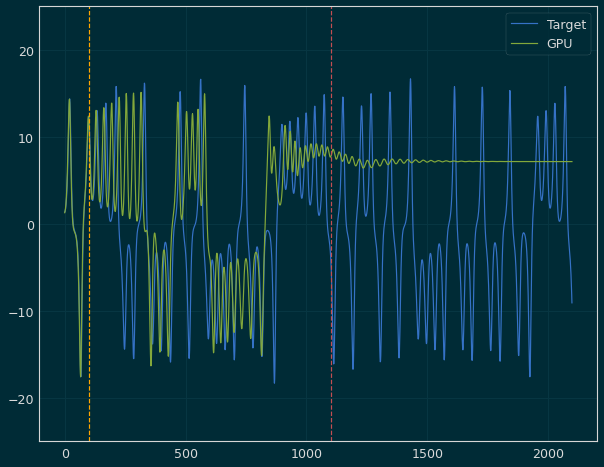

 Iter=70 a=0.114 sr=7.887 amp=0.364  ri=0.620 rr=0.998 loss=0.824785


Iter: 70 #### Diagnostic 0.824785   Time 5.66  Best 0.825 NRMSE 0.230 CD 0.595
Iter: 71 #### Diagnostic 1000.000000   Time 7.68  Best 0.825 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 6.57  Best 0.825 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 8.48  Best 0.825 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 7.57  Best 0.825 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 8.42  Best 0.825 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.308478   Time 5.22  Best 0.825 NRMSE 0.292 CD 1.016
Iter: 77 #### Diagnostic 1000.000000   Time 7.06  Best 0.825 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 169.213145   Time 6.78  Best 0.825 NRMSE 168.187 CD 1.026
Iter: 79 #### Diagnostic 1000.000000   Time 9.34  Best 0.825 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.92  Best 0.825 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic

Iter: 58 #### Diagnostic 1000.000000   Time 7.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 9.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 9.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.531247   Time 9.14  Best 1000.000 NRMSE 0.568 CD 0.964
Iter: 62 #### Diagnostic 1.983224   Time 9.43  Best 1000.000 NRMSE 1.118 CD 0.865
Iter: 63 #### Diagnostic 1.390898   Time 7.55  Best 1000.000 NRMSE 0.305 CD 1.086
Iter: 64 #### Diagnostic 1000.000000   Time 7.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 9.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 8.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 2.172875   Time 7.98  Best 1000.000 NRMSE 1.182 CD 0.991
Iter: 69 #### Diagnostic 1000.000000   Time 10.70  Best 1000.000 NRMSE

Iter: 53 #### Diagnostic 1.204872   Time 6.41  Best 1000.000 NRMSE 0.323 CD 0.882
Iter: 54 #### Diagnostic 1000.000000   Time 8.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.543441   Time 6.16  Best 1000.000 NRMSE 0.370 CD 1.174
Iter: 56 #### Diagnostic 1.420408   Time 10.53  Best 1000.000 NRMSE 0.460 CD 0.960
Iter: 57 #### Diagnostic 1000.000000   Time 8.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.072839   Time 6.00  Best 1000.000 NRMSE 0.270 CD 0.802
Iter: 60 #### Diagnostic 1000.000000   Time 8.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 2.340523   Time 6.87  Best 1000.000 NRMSE 1.

Iter: 48 #### Diagnostic 1000.000000   Time 9.45  Best 1000.000 NRMSE 4761921760487710.000 CD 1.043
Iter: 49 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.190676   Time 6.40  Best 1000.000 NRMSE 0.309 CD 0.881
Iter: 51 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 9.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.353509   Time 6.46  Best 1000.000 NRMSE 0.302 CD 1.052
Iter: 54 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 9.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 8.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.335647   Time 6.93  Best 1000.000 NRMSE 0.309 CD 1.027
Iter: 59 #### Diagnostic 1.385744   Time 7.19  Best 

Iter: 42 #### Diagnostic 1000.000000   Time 10.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.267207   Time 6.42  Best 1000.000 NRMSE 0.291 CD 0.976
Iter: 44 #### Diagnostic 1000.000000   Time 7.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 9.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.768687   Time 8.41  Best 1000.000 NRMSE 0.789 CD 0.980
Iter: 48 #### Diagnostic 1000.000000   Time 8.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 8.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 10.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.365946   Time 5.70  Best 1000.000 NRMSE 0.298 CD 1.068
Iter: 52 #### Diagnostic 1000.000000   Time 8.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.172975   Time 7.78  Best 1000.000 NRM

Iter: 37 #### Diagnostic 1.658144   Time 5.80  Best 1000.000 NRMSE 0.350 CD 1.308
Iter: 38 #### Diagnostic 1000.000000   Time 10.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 7.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 5.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 8.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 10.620516   Time 7.89  Best 1000.000 NRMSE 9.614 CD 1.006
Iter: 44 #### Diagnostic 1000.000000   Time 7.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 9.14  Best 1000.000 NRMSE 29311020796431015538510004224.000 CD 1.000
Iter: 47 #### Diagnostic 1000.000000   Time 8.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000

Iter: 28 #### Diagnostic 2.015069   Time 7.91  Best 1000.000 NRMSE 1.030 CD 0.985
Iter: 29 #### Diagnostic 1.375499   Time 7.34  Best 1000.000 NRMSE 0.318 CD 1.057
Iter: 30 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 9052580041.843 CD 0.985
Iter: 31 #### Diagnostic 1000.000000   Time 8.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 35210513880756.891 CD 0.905
Iter: 33 #### Diagnostic 1.508260   Time 5.69  Best 1000.000 NRMSE 0.320 CD 1.188
Iter: 34 #### Diagnostic 1.211894   Time 6.70  Best 1000.000 NRMSE 0.288 CD 0.924
Iter: 35 #### Diagnostic 1000.000000   Time 8.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 8.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 7.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 8.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 6.97  

Iter: 22 #### Diagnostic 1000.000000   Time 8.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.526384   Time 4.85  Best 1000.000 NRMSE 0.324 CD 1.202
Iter: 24 #### Diagnostic 1.388061   Time 7.19  Best 1000.000 NRMSE 0.309 CD 1.080


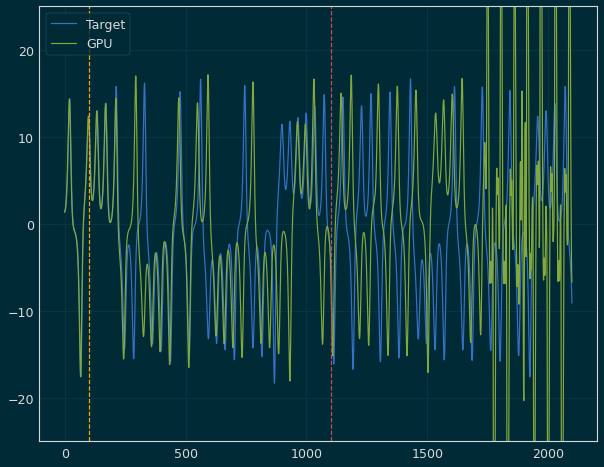

 Iter=25 a=0.712 sr=3.122 amp=0.537  ri=0.439 rr=0.095 loss=0.846924


Iter: 25 #### Diagnostic 0.846924   Time 9.50  Best 0.847 NRMSE 0.231 CD 0.616
Iter: 26 #### Diagnostic 1000.000000   Time 8.31  Best 0.847 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.76  Best 0.847 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 7.54  Best 0.847 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 4.831790   Time 9.14  Best 0.847 NRMSE 3.797 CD 1.035
Iter: 30 #### Diagnostic 1.301314   Time 4.99  Best 0.847 NRMSE 0.280 CD 1.022
Iter: 31 #### Diagnostic 1.460250   Time 6.59  Best 0.847 NRMSE 0.317 CD 1.143
Iter: 32 #### Diagnostic 1.348884   Time 8.19  Best 0.847 NRMSE 0.312 CD 1.037
Iter: 33 #### Diagnostic 1000.000000   Time 9.34  Best 0.847 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 8.22  Best 0.847 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 6.42  Best 0.847 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000

Iter: 21 #### Diagnostic 1000.000000   Time 9.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.296777   Time 5.32  Best 1000.000 NRMSE 0.298 CD 0.999
Iter: 23 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 8.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 7.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.112942   Time 9.53  Best 1000.000 NRMSE 0.285 CD 0.828
Iter: 28 #### Diagnostic 1000.000000   Time 8.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 10.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 8.74  Best 1000.0

Iter: 15 #### Diagnostic 1000.000000   Time 9.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 8.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 11.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.428320   Time 5.72  Best 1000.000 NRMSE 0.315 CD 1.114
Iter: 20 #### Diagnostic 1000.000000   Time 9.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.163359   Time 8.25  Best 1000.000 NRMSE 0.324 CD 0.840
Iter: 22 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.332727   Time 5.99  Best 1000.000 NRMSE 0.316 CD 1.016
Iter: 24 #### Diagnostic 1000.000000   Time 6.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.946318   Time 5.25  Best 1000.000 NRMSE 0.243 CD 0.703
Iter: 26 #### Diagnostic 1000.000000   Time 9.69  Best 1000.000 NRMSE

Iter: 9 #### Diagnostic 1000.000000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.362789   Time 7.83  Best 1000.000 NRMSE 0.327 CD 1.036
Iter: 11 #### Diagnostic 1000.000000   Time 10.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.334388   Time 6.19  Best 1000.000 NRMSE 0.297 CD 1.037
Iter: 13 #### Diagnostic 1000.000000   Time 9.25  Best 1000.000 NRMSE 183216227159600726016.000 CD 1.000
Iter: 14 #### Diagnostic 1000.000000   Time 10.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.356274   Time 6.21  Best 1000.000 NRMSE 0.320 CD 1.036
Iter: 19 #### Diagnostic 1000.000000   Time 8.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.346142   Time 4.77 

Iter: 0 #### Diagnostic 1000.000000   Time 6.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 7.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.127336   Time 6.78  Best 1000.000 NRMSE 0.272 CD 0.856
Iter: 3 #### Diagnostic 1.385877   Time 6.19  Best 1000.000 NRMSE 0.324 CD 1.062
Iter: 4 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.412733   Time 5.08  Best 1000.000 NRMSE 0.326 CD 1.087
Iter: 6 #### Diagnostic 1000.000000   Time 9.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.019573   Time 6.78  Best 1000.000 NRMSE 0.257 CD 0.763
Iter: 8 #### Diagnostic 1000.000000   Time 6.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.542514   Time 7.04  Best 1000.000 NRMSE 0.325 CD 1.218
Iter: 10 #### Diagnostic 1000.000000   Time 9.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.899483   Time 5.85  Best 1000.000 NRMSE 0.241 CD 0.659


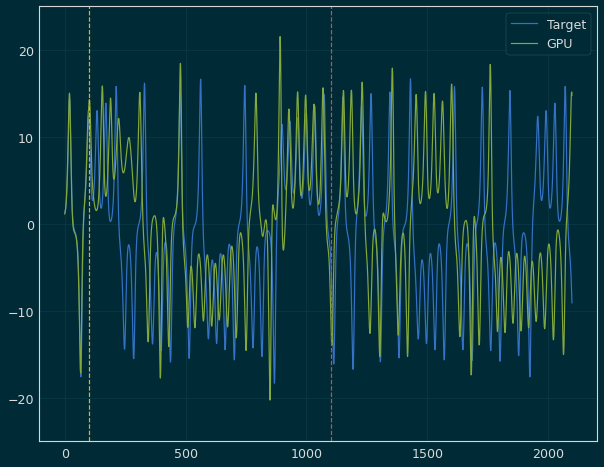

 Iter=12 a=0.335 sr=4.015 amp=0.721  ri=0.373 rr=0.794 loss=0.823114


Iter: 12 #### Diagnostic 0.823114   Time 5.25  Best 0.823 NRMSE 0.228 CD 0.595
Iter: 13 #### Diagnostic 1000.000000   Time 10.11  Best 0.823 NRMSE 7922962074532328100572457598976.000 CD 1.000
Iter: 14 #### Diagnostic 1.392220   Time 8.84  Best 0.823 NRMSE 0.366 CD 1.026
Iter: 15 #### Diagnostic 1000.000000   Time 6.49  Best 0.823 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 7.42  Best 0.823 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 3.195531   Time 7.20  Best 0.823 NRMSE 2.139 CD 1.057
Iter: 18 #### Diagnostic 1000.000000   Time 5.87  Best 0.823 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 8.66  Best 0.823 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.246324   Time 5.83  Best 0.823 NRMSE 0.301 CD 0.945
Iter: 21 #### Diagnostic 1000.000000   Time 7.40  Best 0.823 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 7.51  Best 0.823 NRMSE 1000.000 CD nan
It

Iter: 9 #### Diagnostic 1.048924   Time 6.47  Best 1000.000 NRMSE 0.267 CD 0.782
Iter: 10 #### Diagnostic 1000.000000   Time 5.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.613654   Time 6.62  Best 1000.000 NRMSE 0.327 CD 1.286
Iter: 18 #### Diagnostic 1000.000000   Time 8.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.276725   Time 6.25  Best 1000.000 NR

Iter: 4 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 15.892714   Time 10.99  Best 1000.000 NRMSE 14.725 CD 1.167
Iter: 6 #### Diagnostic 1.165056   Time 6.50  Best 1000.000 NRMSE 0.305 CD 0.860
Iter: 7 #### Diagnostic 1000.000000   Time 9.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 26.811510   Time 7.61  Best 1000.000 NRMSE 25.843 CD 0.969
Iter: 9 #### Diagnostic 8.481000   Time 7.76  Best 1000.000 NRMSE 7.441 CD 1.040
Iter: 10 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 6.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.326532   Time 4.81  Best 1000.000 NRMSE 0.300 CD 1.026
Iter: 14 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.48  Best 1000.000 NRMSE 1000.

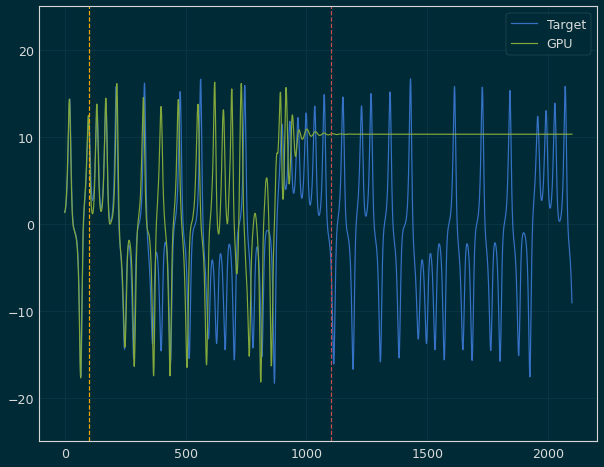

 Iter=22 a=0.887 sr=4.027 amp=0.573  ri=0.343 rr=3.049 loss=0.685064


Iter: 22 #### Diagnostic 0.685064   Time 6.98  Best 0.685 NRMSE 0.210 CD 0.475
Iter: 23 #### Diagnostic 1000.000000   Time 6.91  Best 0.685 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 8.31  Best 0.685 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.427591   Time 6.60  Best 0.685 NRMSE 0.421 CD 1.007
Iter: 26 #### Diagnostic 1000.000000   Time 8.37  Best 0.685 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.209367   Time 9.23  Best 0.685 NRMSE 0.282 CD 0.927
Iter: 28 #### Diagnostic 11.756773   Time 8.46  Best 0.685 NRMSE 10.789 CD 0.968
Iter: 29 #### Diagnostic 1000.000000   Time 7.10  Best 0.685 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 7.27  Best 0.685 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 8.14  Best 0.685 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 8.22  Best 0.685 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.

Iter: 19 #### Diagnostic 1.237192   Time 6.67  Best 1000.000 NRMSE 0.298 CD 0.939
Iter: 20 #### Diagnostic 1.045149   Time 5.91  Best 1000.000 NRMSE 0.254 CD 0.791
Iter: 21 #### Diagnostic 1000.000000   Time 7.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 8.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 0.998368   Time 7.10  Best 1000.000 NRMSE 0.262 CD 0.736
Iter: 24 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.287554   Time 6.16  Best 1000.000 NRMSE 0.290 CD 0.998
Iter: 26 #### Diagnostic 1000.000000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.116796   Time 5.51  Best 1000.000 NRMSE 0.244 CD 0.872
Iter: 29 #### Diagnostic 1.383477   Time 5.47  Best 1000.000 NRMSE 0.352 CD 1.031
Iter: 30 #### Diagnostic 1.074380   Time 6.04  Best 1000.000 NRMSE 0.272 CD 0.

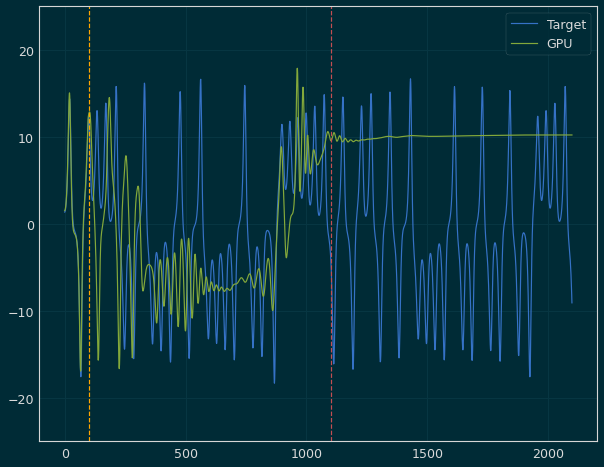

 Iter=97 a=0.164 sr=7.114 amp=0.496  ri=0.806 rr=3.115 loss=0.791723


Iter: 97 #### Diagnostic 0.791723   Time 5.62  Best 0.792 NRMSE 0.216 CD 0.576
Iter: 98 #### Diagnostic 1.012567   Time 6.17  Best 0.792 NRMSE 0.257 CD 0.756
Iter: 99 #### Diagnostic 1000.000000   Time 8.82  Best 0.792 NRMSE 1000.000 CD nan

Best result = 0.7917231147846294
a = 0.16448561371218068
sr = 7.11443121372315
amp = 0.49573042649904464
ri = 0.8058000965994152
rr = 3.1146197062171135
********** Size 500 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.676697   Time 6.33  Best 1000.000 NRMSE 0.692 CD 0.985
Iter: 1 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.345307   Time 4.73  Best 1000.000 NRMSE 0.300 CD 1.045
Iter: 4 #### Diagnostic 1000.000000   Time 8.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.00

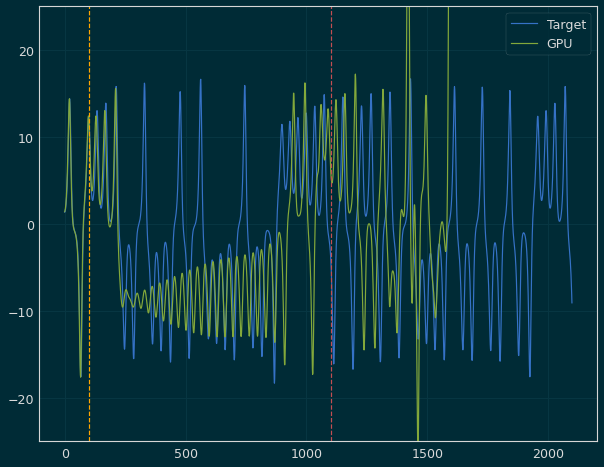

 Iter=74 a=0.543 sr=6.836 amp=0.200  ri=0.171 rr=3.260 loss=0.750357


Iter: 74 #### Diagnostic 0.750357   Time 7.78  Best 0.750 NRMSE 0.221 CD 0.529
Iter: 75 #### Diagnostic 1000.000000   Time 6.56  Best 0.750 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 5.76  Best 0.750 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 8.87  Best 0.750 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 5.69  Best 0.750 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 3.970734   Time 6.36  Best 0.750 NRMSE 2.970 CD 1.001
Iter: 80 #### Diagnostic 1000.000000   Time 6.87  Best 0.750 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.224581   Time 6.10  Best 0.750 NRMSE 0.283 CD 0.942
Iter: 82 #### Diagnostic 1.256476   Time 6.23  Best 0.750 NRMSE 0.329 CD 0.927
Iter: 83 #### Diagnostic 1000.000000   Time 6.54  Best 0.750 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 9.27  Best 0.750 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.00

Iter: 62 #### Diagnostic 1000.000000   Time 7.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.089434   Time 6.35  Best 1000.000 NRMSE 0.271 CD 0.819
Iter: 64 #### Diagnostic 1000.000000   Time 8.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.358741   Time 6.84  Best 1000.000 NRMSE 0.306 CD 1.053
Iter: 66 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 8.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.555240   Time 8.82  Best 1000.000 NRMSE 0.560 CD 0.995
Iter: 69 #### Diagnostic 1000.000000   Time 9.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.330138   Time 5.42  Best 1000.000 NRMSE 0.301 CD 1.029
Iter: 71 #### Diagnostic 1000.000000   Time 8.84  Best 1000.000 NRMSE 803994656682285812430977584070656.000 CD 1.000
Iter: 72 #### Diagnostic 1.065100   Time 6.08  Best 1000.000 NRMSE 0.264 CD 0.801
Iter: 73 #### Diagnostic 1000.000000   Time

Iter: 57 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.403276   Time 5.02  Best 1000.000 NRMSE 0.329 CD 1.075
Iter: 60 #### Diagnostic 1000.000000   Time 7.44  Best 1000.000 NRMSE 9792987343029992594786484224.000 CD 1.000
Iter: 61 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 9.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.361812   Time 8.09  Best 1000.000 NRMSE 0.311 CD 1.051
Iter: 64 #### Diagnostic 1.522299   Time 8.05  Best 1000.000 NRMSE 0.475 CD 1.048
Iter: 65 #### Diagnostic 1000.000000   Time 8.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 9.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   T

Iter: 51 #### Diagnostic 1.141083   Time 6.04  Best 1000.000 NRMSE 0.273 CD 0.868
Iter: 52 #### Diagnostic 1000.000000   Time 9.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 9.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 8.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.393814   Time 6.72  Best 1000.000 NRMSE 0.299 CD 1.095
Iter: 56 #### Diagnostic 1000.000000   Time 7.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 8.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.501179   Time 6.50  Best 1000.000 NRMSE 0.328 CD 1.174
Iter: 59 #### Diagnostic 1.363544   Time 8.56  Best 1000.000 NRMSE 0.303 CD 1.061
Iter: 60 #### Diagnostic 1.292132   Time 5.50  Best 1000.000 NRMSE 0.297 CD 0.995
Iter: 61 #### Diagnostic 1.328484   Time 7.65  Best 1000.000 NRMSE 0.279 CD 1.049
Iter: 62 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000

Iter: 45 #### Diagnostic 307.326740   Time 6.40  Best 1000.000 NRMSE 306.306 CD 1.021
Iter: 46 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 2.264860   Time 8.67  Best 1000.000 NRMSE 1.258 CD 1.007
Iter: 48 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 7.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.076375   Time 5.78  Best 1000.000 NRMSE 0.267 CD 0.809
Iter: 52 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 9.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.036451   Time 7.19  Best 1000.000 NRMSE 0.260 CD 0.777
Iter: 55 #### Diagnostic 1000.000000   Time 9.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.422925   Time 9.44  Best 1000.000 NRMSE

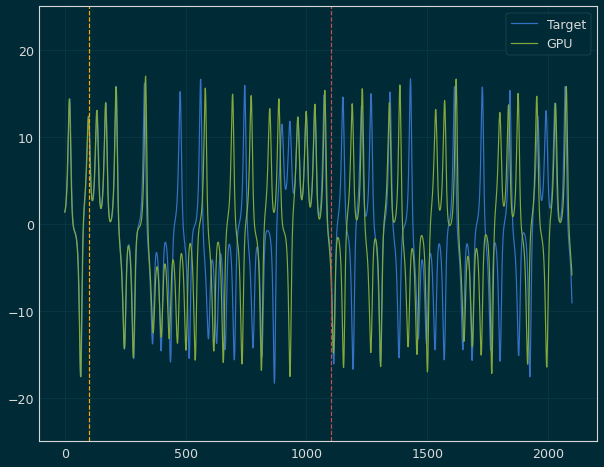

 Iter=1 a=0.539 sr=2.567 amp=0.750  ri=0.287 rr=1.974 loss=0.749730


Iter: 1 #### Diagnostic 0.749730   Time 9.26  Best 0.750 NRMSE 0.215 CD 0.535
Iter: 2 #### Diagnostic 1000.000000   Time 6.96  Best 0.750 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.72  Best 0.750 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 8.62  Best 0.750 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 9.22  Best 0.750 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 11.19  Best 0.750 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 7.89  Best 0.750 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 7.82  Best 0.750 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.35  Best 0.750 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.020220   Time 9.84  Best 0.750 NRMSE 0.257 CD 0.763
Iter: 11 #### Diagnostic 1000.000000   Time 9.85  Best 0.750 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.150027

Iter: 0 #### Diagnostic 1000.000000   Time 9.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 8.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.134605   Time 7.48  Best 1000.000 NRMSE 0.271 CD 0.864
Iter: 3 #### Diagnostic 1.154836   Time 8.27  Best 1000.000 NRMSE 0.285 CD 0.870
Iter: 4 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.235464   Time 6.14  Best 1000.000 NRMSE 0.291 CD 0.945
Iter: 6 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.307073   Time 6.47  Best 1000.000 NRMSE 0.296 CD 1.011
Iter: 8 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.961752   Time 5.99  Best 1000.000 NRMSE 0.263 CD 0.699
Iter: 10 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.145430   Time 5.88  Best 1000.000 NRMSE 0.275 CD 0.870
It

Iter: 97 #### Diagnostic 1000.000000   Time 9.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 9.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.366448   Time 8.62  Best 1000.000 NRMSE 0.310 CD 1.057

Best result = 0.9617524575145471
a = 0.9239260069229531
sr = 5.420568826252946
amp = 0.9882685388537406
ri = 0.47017115480644184
rr = 4.117857163090081
********** Size 500 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 8.59  Best 1000.000 NRMSE 24292903925360947200.000 CD 1.000
Iter: 2 #### Diagnostic 1.297332   Time 7.00  Best 1000.000 NRMSE 0.281 CD 1.017
Iter: 3 #### Diagnostic 1000.000000   Time 9.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 9.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 9.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.35

Iter: 92 #### Diagnostic 1000.000000   Time 9.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.124168   Time 6.89  Best 1000.000 NRMSE 0.283 CD 0.841
Iter: 94 #### Diagnostic 1000.000000   Time 10.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 8.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 9.46  Best 1000.000 NRMSE 600601936874521215317357625344.000 CD 1.000
Iter: 98 #### Diagnostic 1000.000000   Time 9.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 10.30  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.9445201285076776
a = 0.37220583231362037
sr = 5.835150781092044
amp = 0.6101043900986071
ri = 0.5812268756072574
rr = 1.734730565237045
********** Size 500 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1

Iter: 86 #### Diagnostic 1000.000000   Time 8.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 8.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 9.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.035199   Time 5.32  Best 1000.000 NRMSE 0.262 CD 0.773
Iter: 90 #### Diagnostic 1.054806   Time 6.94  Best 1000.000 NRMSE 0.280 CD 0.775
Iter: 91 #### Diagnostic 1.325894   Time 5.63  Best 1000.000 NRMSE 0.307 CD 1.019
Iter: 92 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 9.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 9.23  Best 1000.000 NR

Iter: 80 #### Diagnostic 1.263930   Time 8.51  Best 1000.000 NRMSE 0.254 CD 1.010
Iter: 81 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 7.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.259652   Time 5.86  Best 1000.000 NRMSE 0.291 CD 0.969
Iter: 85 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1019371465569.303 CD 1.153
Iter: 86 #### Diagnostic 1.569237   Time 7.57  Best 1000.000 NRMSE 0.573 CD 0.997
Iter: 87 #### Diagnostic 1.102955   Time 7.27  Best 1000.000 NRMSE 0.260 CD 0.843
Iter: 88 #### Diagnostic 1.417859   Time 6.48  Best 1000.000 NRMSE 0.315 CD 1.103
Iter: 89 #### Diagnostic 1.386601   Time 6.33  Best 1000.000 NRMSE 0.300 CD 1.086
Iter: 90 #### Diagnostic 1000.000000   Time 7.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRM

Iter: 74 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 8.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 10.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 9.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.370499   Time 5.89  Best 1000.000 NRMSE 0.314 CD 1.057
Iter: 82 #### Diagnostic 1.079480   Time 6.18  Best 1000.000 NRMSE 0.274 CD 0.806
Iter: 83 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 8.45  Best 1000.0

Iter: 65 #### Diagnostic 1000.000000   Time 8.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 9.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.347064   Time 5.74  Best 1000.000 NRMSE 0.283 CD 1.064
Iter: 71 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.103032   Time 5.29  Best 1000.000 NRMSE 0.265 CD 0.838
Iter: 73 #### Diagnostic 1000.000000   Time 6.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.118218   Time 6.55  Best 1000.000 NRMSE 0.286 CD 0.832
Iter: 75 #### Diagnostic 1000.000000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.04  Best 1000.000 NR

Iter: 60 #### Diagnostic 1.426283   Time 8.02  Best 1000.000 NRMSE 0.311 CD 1.115
Iter: 61 #### Diagnostic 1000.000000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 9.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 9.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.425034   Time 8.02  Best 1000.000 NRMSE 0.402 CD 1.023
Iter: 65 #### Diagnostic 1000.000000   Time 9.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 0.876891   Time 4.99  Best 1000.000 NRMSE 0.238 CD 0.639
Iter: 68 #### Diagnostic 1000.000000   Time 7.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 8.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 8.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 8.27  Best 1000.000 NR

Iter: 54 #### Diagnostic 1.049892   Time 8.88  Best 1000.000 NRMSE 0.238 CD 0.812
Iter: 55 #### Diagnostic 1000.000000   Time 9.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.558081   Time 4.73  Best 1000.000 NRMSE 0.325 CD 1.233
Iter: 59 #### Diagnostic 1000.000000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.864340   Time 5.36  Best 1000.000 NRMSE 0.254 CD 0.610
Iter: 62 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 8.10  Best 1000.000 NR

Iter: 48 #### Diagnostic 1000.000000   Time 9.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 7.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.575112   Time 5.49  Best 1000.000 NRMSE 0.328 CD 1.247
Iter: 52 #### Diagnostic 1000.000000   Time 5.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 38730492313.300 CD 0.953
Iter: 55 #### Diagnostic 1000.000000   Time 8.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.403510   Time 10.34  Best 1000.000 NRMSE 0.334 CD 1.069
Iter: 57 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.16  Be

Iter: 42 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 33.226821   Time 7.66  Best 1000.000 NRMSE 32.224 CD 1.003
Iter: 44 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.57  Best 1000.000 NRMSE 41521310406256546191541530525696.000 CD 1.000
Iter: 47 #### Diagnostic 1000.000000   Time 8.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.285299   Time 6.22  Best 1000.000 NRMSE 0.290 CD 0.995
Iter: 49 #### Diagnostic 1.311227   Time 9.38  Best 1000.000 NRMSE 0.322 CD 0.990
Iter: 50 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.353205   Time 8.39  Best 1000.000 NRMSE 0.311 CD 1.042
Iter: 52 #### Diagnostic 1.398676   Time 7.50  Best 1000.000 NRMSE 0.360 CD 1.039
Iter: 53 #### Diagnostic 1.294423   Time 5

Iter: 34 #### Diagnostic 1.372453   Time 5.60  Best 1000.000 NRMSE 0.312 CD 1.060
Iter: 35 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 9.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 8.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 8.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 7.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.442210   Time 7.13  Best 1000.000 NRMSE 0.306 CD 1.136
Iter: 41 #### Diagnostic 1000.000000   Time 7.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.367044   Time 8.55  Best 1000.000 NRMSE 0.284 CD 1.083
Iter: 43 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 1000.000 CD nan


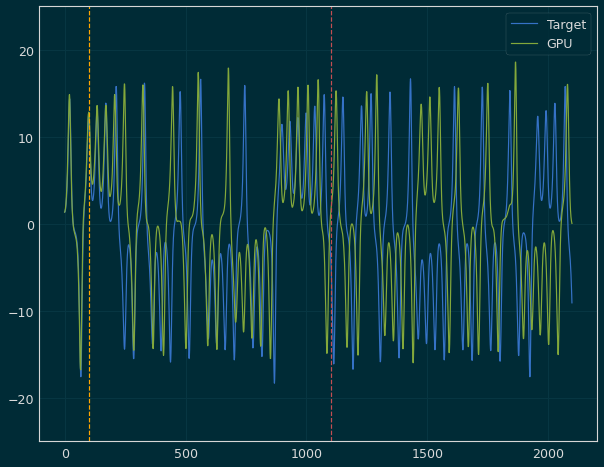

 Iter=44 a=0.897 sr=5.917 amp=0.769  ri=0.325 rr=0.797 loss=0.766024


Iter: 44 #### Diagnostic 0.766024   Time 8.15  Best 0.766 NRMSE 0.217 CD 0.549
Iter: 45 #### Diagnostic 1000.000000   Time 6.40  Best 0.766 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.93  Best 0.766 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 7.20  Best 0.766 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 8.64  Best 0.766 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 7.66  Best 0.766 NRMSE 11996989062135471205777408.000 CD 1.000
Iter: 50 #### Diagnostic 1.390910   Time 5.07  Best 0.766 NRMSE 0.311 CD 1.080
Iter: 51 #### Diagnostic 1000.000000   Time 6.07  Best 0.766 NRMSE 296480022565467918958592.000 CD 1.000
Iter: 52 #### Diagnostic 1000.000000   Time 9.22  Best 0.766 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.224007   Time 5.16  Best 0.766 NRMSE 0.278 CD 0.946
Iter: 54 #### Diagnostic 1000.000000   Time 6.98  Best 0.766 NRMS

Iter: 39 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.210437   Time 6.36  Best 1000.000 NRMSE 0.287 CD 0.924
Iter: 42 #### Diagnostic 1.488062   Time 7.00  Best 1000.000 NRMSE 0.320 CD 1.168
Iter: 43 #### Diagnostic 2.833144   Time 7.76  Best 1000.000 NRMSE 1.755 CD 1.078
Iter: 44 #### Diagnostic 1000.000000   Time 7.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.211816   Time 8.15  Best 1000.000 NRMSE 0.281 CD 0.931
Iter: 46 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 6.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.214565   Time 7.49  Best 1000.000 NRMSE 0.293 CD 0.921
Iter: 49 #### Diagnostic 1.184776   Time 7.70  Best 1000.000 NRMSE 0.271 CD 0.913
Iter: 50 #### Diagnostic 1.582153   Time 6.69  Best 1000.000 NRMSE 0.323 CD 1.

Iter: 33 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.219427   Time 6.08  Best 1000.000 NRMSE 0.287 CD 0.932
Iter: 36 #### Diagnostic 1.103861   Time 5.62  Best 1000.000 NRMSE 0.270 CD 0.834
Iter: 37 #### Diagnostic 1000.000000   Time 7.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 8.88  Best 1000.000 NRMSE 1373996886721418578457077129150464.000 CD 1.000
Iter: 40 #### Diagnostic 1000.000000   Time 6.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.354331   Time 7.54  Best 1000.000 NRMSE 0.308 CD 1.046
Iter: 43 #### Diagnostic 1.379810   Time 9.06  Best 1000.000 NRMSE 0.322 CD 1.057
Iter: 44 #### Diagnostic 1000.000000  

Iter: 27 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.209670   Time 6.45  Best 1000.000 NRMSE 0.300 CD 0.910
Iter: 29 #### Diagnostic 1.308849   Time 7.28  Best 1000.000 NRMSE 0.292 CD 1.017
Iter: 30 #### Diagnostic 1.423453   Time 5.41  Best 1000.000 NRMSE 0.314 CD 1.109
Iter: 31 #### Diagnostic 1.099391   Time 4.81  Best 1000.000 NRMSE 0.270 CD 0.830
Iter: 32 #### Diagnostic 1000.000000   Time 8.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 6.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 6.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 382.294562   Time 7.35  Best 1000.000 NRMSE 381.119 CD 1.175
Iter: 37 #### Diagnostic 1.264353   Time 7.95  Best 1000.000 NRMSE 0.290 CD 0.974
Iter: 38 #### Diagnostic 1000.000000   Time 7.57  Best 1000.000 NRMSE 3367

Iter: 21 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 6.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.822345   Time 7.26  Best 1000.000 NRMSE 0.865 CD 0.958
Iter: 25 #### Diagnostic 1.070587   Time 5.31  Best 1000.000 NRMSE 0.273 CD 0.798
Iter: 26 #### Diagnostic 2.202596   Time 8.67  Best 1000.000 NRMSE 1.071 CD 1.131
Iter: 27 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.104836   Time 5.52  Best 1000.000 NRMSE 0.275 CD 0.830
Iter: 30 #### Diagnostic 1.503844   Time 6.35  Best 1000.000 NRMSE 0.408 CD 1.096
Iter: 31 #### Diagnostic 1000.000000   Time 8.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 7.51  Best 1000.000 NRMSE 1000

Iter: 9 #### Diagnostic 1.065111   Time 5.47  Best 1000.000 NRMSE 0.260 CD 0.805
Iter: 10 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.066686   Time 8.52  Best 1000.000 NRMSE 0.262 CD 0.805
Iter: 13 #### Diagnostic 1.112673   Time 7.82  Best 1000.000 NRMSE 0.271 CD 0.842
Iter: 14 #### Diagnostic 1.557980   Time 5.69  Best 1000.000 NRMSE 0.565 CD 0.993
Iter: 15 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 8.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.447117   Time 4.67  Best 1000.000 NRMSE 0.33

Iter: 4 #### Diagnostic 1000.000000   Time 9.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.215129   Time 5.50  Best 1000.000 NRMSE 0.282 CD 0.933
Iter: 6 #### Diagnostic 1.044795   Time 5.06  Best 1000.000 NRMSE 0.261 CD 0.784
Iter: 7 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 8.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.106706   Time 4.90  Best 1000.000 NRMSE 0.267 CD 0.840
Iter: 10 #### Diagnostic 1000.000000   Time 6.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 8.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 6.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 7.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 10

Iter: 0 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.394868   Time 9.05  Best 1000.000 NRMSE 0.324 CD 1.071
Iter: 2 #### Diagnostic 1000.000000   Time 9.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 10.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.828165   Time 7.52  Best 1000.000 NRMSE 0.892 CD 0.936
Iter: 6 #### Diagnostic 1.350854   Time 6.21  Best 1000.000 NRMSE 0.317 CD 1.034
Iter: 7 #### Diagnostic 1000.000000   Time 9.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 8.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 6.52  Best 1000.000 NRMSE 1000.

Iter: 97 #### Diagnostic 1000.000000   Time 8.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 3.082989   Time 5.77  Best 1000.000 NRMSE 2.203 CD 0.880
Iter: 99 #### Diagnostic 1.380107   Time 8.14  Best 1000.000 NRMSE 0.332 CD 1.048

Best result = 1.027595196266581
a = 0.44995179233779137
sr = 3.8159771923247083
amp = 0.5167694652844094
ri = 0.3691117910457557
rr = 1.312874300003908
********** Size 400 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.471995   Time 8.14  Best 1000.000 NRMSE 0.318 CD 1.154
Iter: 2 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 841015.951 CD 0.933
Iter: 3 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.212602   Time 4.73  Best 1000.000 NRMSE 0.288 CD 0.925
Iter: 5 #### Diagnostic 1.367836   Time 7.34  Best 1000.000 NRMSE 0.311 CD 1.056
Iter: 6 #### Diagnostic 1000.000000   Time 6.87  Best 

Iter: 92 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 9.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.893586   Time 7.22  Best 1000.000 NRMSE 0.766 CD 1.128
Iter: 95 #### Diagnostic 1000.000000   Time 7.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.141667   Time 6.51  Best 1000.000 NRMSE 0.289 CD 0.853
Iter: 97 #### Diagnostic 1.358061   Time 5.49  Best 1000.000 NRMSE 0.301 CD 1.058
Iter: 98 #### Diagnostic 1.156250   Time 4.67  Best 1000.000 NRMSE 0.270 CD 0.886
Iter: 99 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.1036859128974892
a = 0.45899456223965085
sr = 7.321607289502954
amp = 0.014031943561971422
ri = 0.5040977140871845
rr = 0.37781318377469253
********** Size 400 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.874499   Time 6.82  Best 1000.000 NRMSE 0.926 CD 0.948
Iter: 1 #### Diagnostic 1.188122   Time 5.84  Bes

Iter: 87 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 14.547985   Time 7.62  Best 1000.000 NRMSE 13.628 CD 0.920
Iter: 93 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.321425   Time 6.69  Best 1000.000 NRMSE 0.304 CD 1.017
Iter: 97 #### Diagnostic 1.024490   Time 6.51  Best 1000.000 NRMSE 0.256 CD 0.768
Iter: 98 #### Diagnostic 1.326308   Time 4.76  Best 1000.000 NRM

Iter: 80 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.169542   Time 5.52  Best 1000.000 NRMSE 0.273 CD 0.897
Iter: 83 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 14606660775397801590784.000 CD 1.000
Iter: 86 #### Diagnostic 1000.000000   Time 6.58  Best 1000.000 NRMSE 1000.000 CD nan


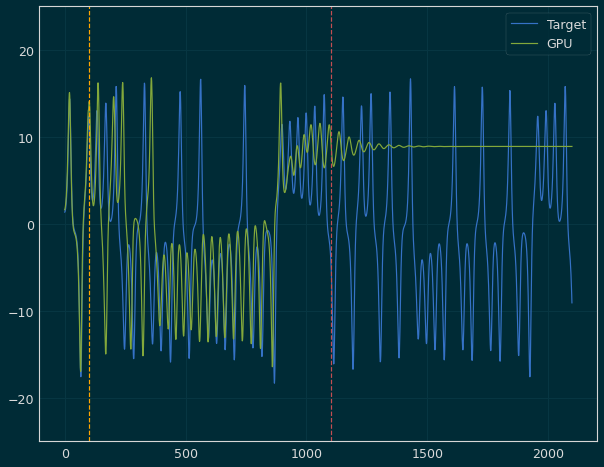

 Iter=87 a=0.278 sr=5.642 amp=0.951  ri=0.762 rr=2.666 loss=0.846951


Iter: 87 #### Diagnostic 0.846951   Time 5.32  Best 0.847 NRMSE 0.232 CD 0.615
Iter: 88 #### Diagnostic 1000.000000   Time 5.73  Best 0.847 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.510546   Time 5.13  Best 0.847 NRMSE 0.323 CD 1.188
Iter: 90 #### Diagnostic 1000.000000   Time 7.26  Best 0.847 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.09  Best 0.847 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.52  Best 0.847 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 6.89  Best 0.847 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.399924   Time 5.76  Best 0.847 NRMSE 0.338 CD 1.062
Iter: 95 #### Diagnostic 1000.000000   Time 5.15  Best 0.847 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 6.59  Best 0.847 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 5.90  Best 0.847 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 100

Iter: 82 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1432517419777358080.000 CD 1.000
Iter: 83 #### Diagnostic 1000.000000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.350131   Time 5.14  Best 1000.000 NRMSE 0.308 CD 1.042
Iter: 85 #### Diagnostic 1.374600   Time 8.93  Best 1000.000 NRMSE 0.304 CD 1.071
Iter: 86 #### Diagnostic 1.379043   Time 5.78  Best 1000.000 NRMSE 0.322 CD 1.057
Iter: 87 #### Diagnostic 1000.000000   Time 6.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.321023   Time 6.55  Best 1000.000 NRMSE 0.379 CD 0.942
Iter: 89 #### Diagnostic 1000.000000   Time 4.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.458887   Time 6.50  Best 1

Iter: 76 #### Diagnostic 1.318967   Time 6.66  Best 1000.000 NRMSE 0.305 CD 1.014
Iter: 77 #### Diagnostic 1.297002   Time 6.48  Best 1000.000 NRMSE 0.296 CD 1.001
Iter: 78 #### Diagnostic 1000.000000   Time 7.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 9.395820   Time 7.01  Best 1000.000 NRMSE 8.335 CD 1.061
Iter: 80 #### Diagnostic 1000.000000   Time 6.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.321906   Time 6.56  Best 1000.000 NRMSE 0.304 CD 1.018
Iter: 82 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.223176   Time 4.46  Best 1000.000 NRMSE 0.293 CD 0.931
Iter: 84 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.212820   Time 6.72  Best 1000.000 NRMSE 0.282 CD 0.931
Iter: 86 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NRMSE 1000.000

Iter: 70 #### Diagnostic 13.590475   Time 5.86  Best 1000.000 NRMSE 12.590 CD 1.000
Iter: 71 #### Diagnostic 1.335295   Time 7.37  Best 1000.000 NRMSE 0.307 CD 1.029
Iter: 72 #### Diagnostic 1.767222   Time 6.73  Best 1000.000 NRMSE 0.783 CD 0.984
Iter: 73 #### Diagnostic 1000.000000   Time 8.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.108992   Time 5.81  Best 1000.000 NRMSE 0.270 CD 0.839
Iter: 76 #### Diagnostic 1.331502   Time 6.80  Best 1000.000 NRMSE 0.302 CD 1.029
Iter: 77 #### Diagnostic 1000.000000   Time 6.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.325189   Time 7.20  Best 1000.000 NRMSE 0.289 CD 1.036
Iter: 79 #### Diagnostic 2.365829   Time 7.32  Best 1000.000 NRMSE 1.374 CD 0.992
Iter: 80 #### Diagnostic 1.182296   Time 9.09  Best 1000.000 NRMSE 0.280 CD 0.903
Iter: 81 #### Diagnostic 1000.000000   Time 8.12  Best 1000.000 NRMSE 1000.000 CD na

Iter: 65 #### Diagnostic 1.523195   Time 5.51  Best 1000.000 NRMSE 0.308 CD 1.215
Iter: 66 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.954767   Time 6.17  Best 1000.000 NRMSE 0.244 CD 0.711
Iter: 69 #### Diagnostic 1.062345   Time 5.25  Best 1000.000 NRMSE 0.257 CD 0.805
Iter: 70 #### Diagnostic 1.242165   Time 5.15  Best 1000.000 NRMSE 0.297 CD 0.945
Iter: 71 #### Diagnostic 1000.000000   Time 7.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 7.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 5.64  Best 1000.000 NRMSE 

Iter: 52 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.347462   Time 5.22  Best 1000.000 NRMSE 0.299 CD 1.049
Iter: 54 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.514847   Time 5.55  Best 1000.000 NRMSE 0.270 CD 1.245
Iter: 57 #### Diagnostic 2.054116   Time 5.46  Best 1000.000 NRMSE 1.044 CD 1.010
Iter: 58 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 4.889341   Time 7.80  Best 1000.000 NRMSE 3.756 CD 1.134
Iter: 63 #### Diagnostic 1.298011   Time 8.16  Best 1000.000 NRMSE 0.2

Iter: 47 #### Diagnostic 1000.000000   Time 7.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 7.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.355654   Time 6.25  Best 1000.000 NRMSE 0.294 CD 1.062
Iter: 50 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.195619   Time 6.05  Best 1000.000 NRMSE 0.222 CD 0.973
Iter: 54 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.942180   Time 5.26  Best 1000.000 NRMSE 0.877 CD 1.065
Iter: 56 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 8.09  Best 1000.000 NR

Iter: 41 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.320396   Time 5.86  Best 1000.000 NRMSE 0.300 CD 1.021
Iter: 43 #### Diagnostic 1.390638   Time 6.60  Best 1000.000 NRMSE 0.324 CD 1.067
Iter: 44 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 8.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.126248   Time 6.96  Best 1000.000 NRMSE 0.276 CD 0.850
Iter: 47 #### Diagnostic 1.281375   Time 7.42  Best 1000.000 NRMSE 0.291 CD 0.991
Iter: 48 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 28668750247576127315902464.000 CD 1.000
Iter: 49 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.102563   Time 4.62  Best 1000.000 NRMSE 0.270 CD 0.833
Iter: 51 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.666333   Time 5.92  Bes

Iter: 36 #### Diagnostic 121.795499   Time 5.68  Best 1000.000 NRMSE 120.880 CD 0.916
Iter: 37 #### Diagnostic 1000.000000   Time 7.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.35  Best 1000.000 NRMSE 1184271072231331725312.000 CD 1.000
Iter: 39 #### Diagnostic 1.155074   Time 5.62  Best 1000.000 NRMSE 0.283 CD 0.872
Iter: 40 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.310317   Time 8.90  Best 1000.000 NRMSE 0.317 CD 0.994
Iter: 44 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.424771   Time 8

Iter: 31 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 6.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.380211   Time 5.60  Best 1000.000 NRMSE 0.308 CD 1.072
Iter: 35 #### Diagnostic 1.145464   Time 5.82  Best 1000.000 NRMSE 0.276 CD 0.870
Iter: 36 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.502646   Time 5.01  Best 1000.000 NRMSE 0.316 CD 1.187
Iter: 38 #### Diagnostic 2.489836   Time 6.66  Best 1000.000 NRMSE 1.427 CD 1.062
Iter: 39 #### Diagnostic 1000.000000   Time 6.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.224636   Time 4.72  Best 1000.000 NRMSE 0.289 CD 0.935
Iter: 41 #### Diagnostic 1.761554   Time 6.21  Best 1000.000 NRMSE 0.745 CD 1.017
Iter: 42 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000

Iter: 22 #### Diagnostic 1000.000000   Time 7.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.352439   Time 8.36  Best 1000.000 NRMSE 0.346 CD 1.006
Iter: 24 #### Diagnostic 1000.000000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 58.764697   Time 7.21  Best 1000.000 NRMSE 57.794 CD 0.970
Iter: 26 #### Diagnostic 1.152295   Time 5.74  Best 1000.000 NRMSE 0.283 CD 0.870
Iter: 27 #### Diagnostic 1000.000000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.728232   Time 5.58  Best 1000.000 NRMSE 0.704 CD 1.024
Iter: 29 #### Diagnostic 1.375447   Time 6.22  Best 1000.000 NRMSE 0.321 CD 1.054
Iter: 30 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 179800097777172185088.000 CD 1.000
Iter: 31 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.463281   Time 7.48  Best 1000.000 NRMSE 0.327 CD 1.137
Iter: 33 #### Diagnostic 1.342522   Time 6.93  Best 1000.

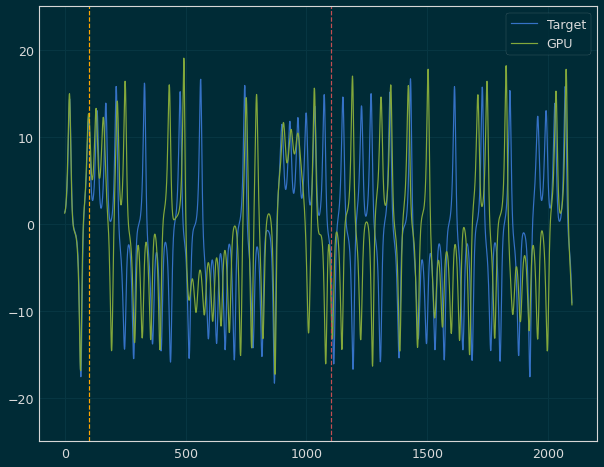

 Iter=0 a=0.140 sr=4.193 amp=0.757  ri=0.310 rr=4.291 loss=0.837280


Iter: 0 #### Diagnostic 0.837280   Time 7.36  Best 0.837 NRMSE 0.231 CD 0.607
Iter: 1 #### Diagnostic 1000.000000   Time 7.37  Best 0.837 NRMSE 1489474410101.423 CD 0.835
Iter: 2 #### Diagnostic 1.277823   Time 7.64  Best 0.837 NRMSE 0.279 CD 0.999
Iter: 3 #### Diagnostic 1000.000000   Time 6.34  Best 0.837 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.17  Best 0.837 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 6.50  Best 0.837 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.477148   Time 6.07  Best 0.837 NRMSE 0.329 CD 1.148
Iter: 7 #### Diagnostic 1000.000000   Time 5.75  Best 0.837 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 7.45  Best 0.837 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.022990   Time 6.58  Best 0.837 NRMSE 0.254 CD 0.769
Iter: 10 #### Diagnostic 1000.000000   Time 7.05  Best 0.837 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.00

Iter: 99 #### Diagnostic 1000.000000   Time 5.72  Best 0.837 NRMSE 1000.000 CD nan

Best result = 0.8372800565717234
a = 0.14008681914682744
sr = 4.193160516732689
amp = 0.7565675916695074
ri = 0.3103625911508808
rr = 4.291035446155339
********** Size 400 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.373754   Time 5.52  Best 1000.000 NRMSE 0.314 CD 1.060
Iter: 2 #### Diagnostic 1000.000000   Time 6.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 43.254253   Time 6.40  Best 1000.000 NRMSE 42.236 CD 1.018
Iter: 4 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.904905   Time 7.95  Best 1000.000 NRMSE 0.925 CD 0.980
Iter: 6 #### Diagnostic 1.579227   Time 6.09  Best 1000.000 NRMSE 0.334 CD 1.245
Iter: 7 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.87  Best 100

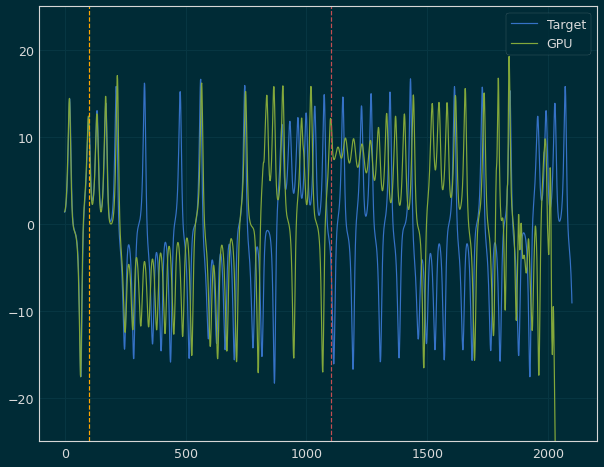

 Iter=35 a=0.783 sr=6.350 amp=0.382  ri=0.409 rr=0.529 loss=0.801565


Iter: 35 #### Diagnostic 0.801565   Time 7.61  Best 0.802 NRMSE 0.225 CD 0.577
Iter: 36 #### Diagnostic 1.506536   Time 6.12  Best 0.802 NRMSE 0.436 CD 1.070
Iter: 37 #### Diagnostic 1000.000000   Time 7.45  Best 0.802 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.348947   Time 5.80  Best 0.802 NRMSE 0.313 CD 1.035
Iter: 39 #### Diagnostic 1000.000000   Time 5.18  Best 0.802 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 5.95  Best 0.802 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 7.05  Best 0.802 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.477467   Time 5.77  Best 0.802 NRMSE 0.316 CD 1.162
Iter: 43 #### Diagnostic 1.603887   Time 5.59  Best 0.802 NRMSE 0.342 CD 1.262
Iter: 44 #### Diagnostic 1000.000000   Time 6.73  Best 0.802 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 6.32  Best 0.802 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.465052   

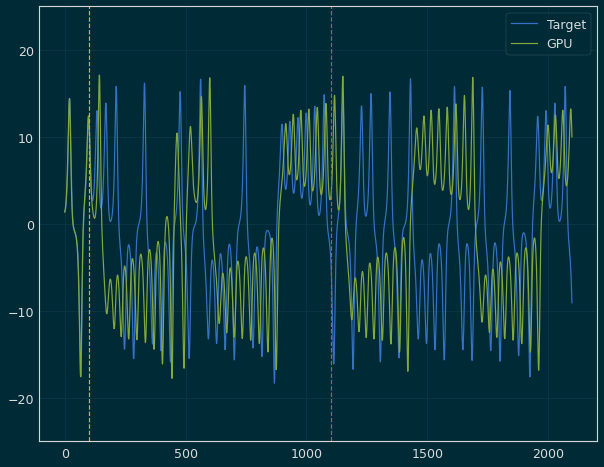

 Iter=20 a=0.508 sr=1.014 amp=0.085  ri=0.401 rr=4.929 loss=0.847334


Iter: 20 #### Diagnostic 0.847334   Time 6.07  Best 0.847 NRMSE 0.236 CD 0.611
Iter: 21 #### Diagnostic 1000.000000   Time 6.10  Best 0.847 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 7.89  Best 0.847 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.227947   Time 5.17  Best 0.847 NRMSE 0.294 CD 0.934
Iter: 24 #### Diagnostic 1000.000000   Time 6.91  Best 0.847 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.909111   Time 4.97  Best 0.847 NRMSE 0.235 CD 0.674
Iter: 26 #### Diagnostic 1000.000000   Time 8.21  Best 0.847 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.92  Best 0.847 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.440626   Time 6.70  Best 0.847 NRMSE 0.509 CD 0.931
Iter: 29 #### Diagnostic 1.257003   Time 5.93  Best 0.847 NRMSE 0.281 CD 0.976
Iter: 30 #### Diagnostic 1.323374   Time 5.43  Best 0.847 NRMSE 0.303 CD 1.021
Iter: 31 #### Diagnostic 1.063558   Time

Iter: 16 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.528220   Time 6.77  Best 1000.000 NRMSE 0.409 CD 1.120
Iter: 18 #### Diagnostic 1.227274   Time 5.91  Best 1000.000 NRMSE 0.285 CD 0.943
Iter: 19 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.287078   Time 6.07  Best 1000.000 NRMSE 0.290 CD 0.997
Iter: 21 #### Diagnostic 1000.000000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 8.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NR

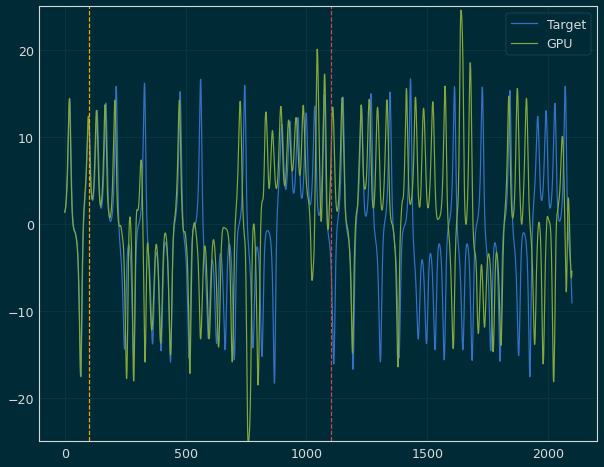

 Iter=2 a=0.714 sr=4.144 amp=0.786  ri=0.588 rr=3.684 loss=0.679957


Iter: 2 #### Diagnostic 0.679957   Time 6.33  Best 0.680 NRMSE 0.210 CD 0.470
Iter: 3 #### Diagnostic 1.533775   Time 6.49  Best 0.680 NRMSE 0.328 CD 1.206
Iter: 4 #### Diagnostic 1000.000000   Time 5.66  Best 0.680 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.122937   Time 4.99  Best 0.680 NRMSE 0.273 CD 0.849
Iter: 6 #### Diagnostic 1000.000000   Time 6.03  Best 0.680 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.417792   Time 4.94  Best 0.680 NRMSE 0.307 CD 1.111
Iter: 8 #### Diagnostic 1000.000000   Time 5.88  Best 0.680 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.435352   Time 5.22  Best 0.680 NRMSE 0.316 CD 1.119
Iter: 10 #### Diagnostic 1000.000000   Time 6.26  Best 0.680 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.306423   Time 5.24  Best 0.680 NRMSE 0.291 CD 1.016
Iter: 12 #### Diagnostic 1.409236   Time 5.56  Best 0.680 NRMSE 0.306 CD 1.103
Iter: 13 #### Diagnostic 1000.000000   Time 5.56  Bes

Iter: 0 #### Diagnostic 1.331348   Time 6.33  Best 1000.000 NRMSE 0.327 CD 1.005
Iter: 1 #### Diagnostic 9.667835   Time 6.49  Best 1000.000 NRMSE 8.691 CD 0.976
Iter: 2 #### Diagnostic 1.272663   Time 6.66  Best 1000.000 NRMSE 0.282 CD 0.990
Iter: 3 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.052351   Time 5.88  Best 1000.000 NRMSE 0.266 CD 0.787
Iter: 6 #### Diagnostic 1.187383   Time 4.51  Best 1000.000 NRMSE 0.282 CD 0.906
Iter: 7 #### Diagnostic 1.367729   Time 6.85  Best 1000.000 NRMSE 0.313 CD 1.055
Iter: 8 #### Diagnostic 1000.000000   Time 6.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.318908   Time 4.55  Best 1000.000 NRMSE 0.298 CD 1.021
Iter: 10 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 

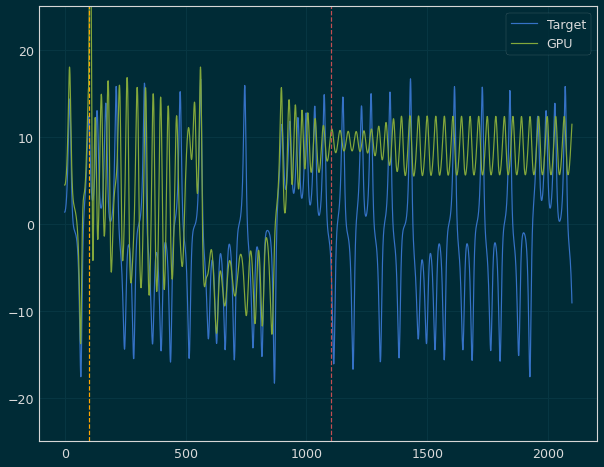

 Iter=37 a=0.185 sr=4.574 amp=0.963  ri=0.605 rr=2.179 loss=0.836242


Iter: 37 #### Diagnostic 0.836242   Time 5.36  Best 0.836 NRMSE 0.239 CD 0.597
Iter: 38 #### Diagnostic 1.313271   Time 7.49  Best 0.836 NRMSE 0.298 CD 1.015
Iter: 39 #### Diagnostic 1000.000000   Time 5.82  Best 0.836 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 6.66  Best 0.836 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.355954   Time 4.52  Best 0.836 NRMSE 0.305 CD 1.051
Iter: 42 #### Diagnostic 1000.000000   Time 5.64  Best 0.836 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.70  Best 0.836 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.20  Best 0.836 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.35  Best 0.836 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 5.32  Best 0.836 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 7.02  Best 0.836 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.1

Iter: 33 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.482100   Time 8.55  Best 1000.000 NRMSE 0.485 CD 0.997
Iter: 35 #### Diagnostic 1.385190   Time 5.56  Best 1000.000 NRMSE 0.311 CD 1.074
Iter: 36 #### Diagnostic 1.452350   Time 5.23  Best 1000.000 NRMSE 0.351 CD 1.102
Iter: 37 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1417450418796656384.000 CD 1.000
Iter: 39 #### Diagnostic 1.284828   Time 8.23  Best 1000.000 NRMSE 0.317 CD 0.968
Iter: 40 #### Diagnostic 1000.000000   Time 6.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 56.834415   Time 6.42  Best 1000.000 NRMSE 55.832 CD 1.002
Iter: 42 #### Diagnostic 1.405166   Time 5.31  Best 1000.000 NRMSE 0.304 CD 1.101
Iter: 43 #### Diagnostic 1.379543   Time 6.24  Best 1000.000 NRMSE 0.364 CD 1.016
Iter: 44 #### Diagnostic 1000.000000   Time 8.49  Best 1000.000

Iter: 28 #### Diagnostic 1.154671   Time 5.60  Best 1000.000 NRMSE 0.280 CD 0.874
Iter: 29 #### Diagnostic 1.517624   Time 9.56  Best 1000.000 NRMSE 0.342 CD 1.176
Iter: 30 #### Diagnostic 1.296207   Time 5.80  Best 1000.000 NRMSE 0.294 CD 1.002
Iter: 31 #### Diagnostic 1.578021   Time 5.55  Best 1000.000 NRMSE 0.335 CD 1.243
Iter: 32 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 7.44  Best 1000.000 NRMSE 14070.176 CD 0.952
Iter: 37 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 3090782211032211456.000 CD 1.000
Iter: 39 #### Diagnostic 1.177695   Time 6.28  Bes

Iter: 22 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.040954   Time 5.71  Best 1000.000 NRMSE 0.258 CD 0.783
Iter: 26 #### Diagnostic 7.144691   Time 5.75  Best 1000.000 NRMSE 6.145 CD 1.000
Iter: 27 #### Diagnostic 1000.000000   Time 5.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.147987   Time 7.03  Best 1000.000 NRMSE 0.304 CD 0.844
Iter: 31 #### Diagnostic 1000.000000   Time 6.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 6.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 6.58  Best 1000.000 NR

Iter: 10 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.590892   Time 5.91  Best 1000.000 NRMSE 0.328 CD 1.263
Iter: 12 #### Diagnostic 1.280043   Time 5.74  Best 1000.000 NRMSE 0.294 CD 0.987
Iter: 13 #### Diagnostic 1000.000000   Time 6.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.326393   Time 7.19  Best 1000.000 NRMSE 0.299 CD 1.027
Iter: 15 #### Diagnostic 1000.000000   Time 8.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.428250   Time 8.15  Best 1000.000 NRMSE 0.315 CD 1.114
Iter: 17 #### Diagnostic 7.369590   Time 8.65  Best 1000.000 NRMSE 6.375 CD 0.995
Iter: 18 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.111671   Time 7.13  Best 1000.000 NRMSE 0.262 CD 0.849


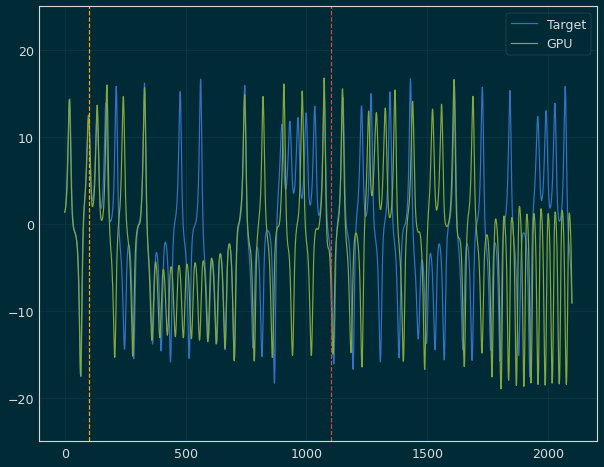

 Iter=20 a=0.256 sr=5.801 amp=0.913  ri=0.877 rr=4.039 loss=0.792959


Iter: 20 #### Diagnostic 0.792959   Time 6.16  Best 0.793 NRMSE 0.224 CD 0.569
Iter: 21 #### Diagnostic 1000.000000   Time 6.14  Best 0.793 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.44  Best 0.793 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.375794   Time 6.01  Best 0.793 NRMSE 0.308 CD 1.067
Iter: 24 #### Diagnostic 1000.000000   Time 8.04  Best 0.793 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 7.04  Best 0.793 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.342103   Time 4.69  Best 0.793 NRMSE 0.296 CD 1.046
Iter: 27 #### Diagnostic 1000.000000   Time 6.76  Best 0.793 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 11.035756   Time 6.39  Best 0.793 NRMSE 9.903 CD 1.132
Iter: 29 #### Diagnostic 1.371481   Time 7.28  Best 0.793 NRMSE 0.314 CD 1.057
Iter: 30 #### Diagnostic 1000.000000   Time 6.91  Best 0.793 NRMSE 487562689504974755787832295424.000 CD 1.000
Iter: 3

Iter: 16 #### Diagnostic 1000.000000   Time 6.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.291025   Time 5.63  Best 1000.000 NRMSE 0.296 CD 0.995
Iter: 18 #### Diagnostic 1000.000000   Time 5.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.352340   Time 7.17  Best 1000.000 NRMSE 0.311 CD 1.042
Iter: 21 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.312164   Time 6.81  Best 1000.000 NRMSE 0.296 CD 1.016
Iter: 23 #### Diagnostic 0.877433   Time 4.45  Best 1000.000 NRMSE 0.238 CD 0.639
Iter: 24 #### Diagnostic 1.258828   Time 4.64  Best 1000.000 NRMSE 0.288 CD 0.970
Iter: 25 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 6.01  Best 1000.000 NRMSE 1000

Iter: 11 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.637910   Time 6.83  Best 1000.000 NRMSE 0.713 CD 0.925
Iter: 13 #### Diagnostic 1.030950   Time 5.24  Best 1000.000 NRMSE 0.267 CD 0.764
Iter: 14 #### Diagnostic 1000.000000   Time 7.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 8.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.984128   Time 6.10  Best 1000.000 NRMSE 1.111 CD 0.873
Iter: 19 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.453493   Time 4.75  Best 1000.000 NRMSE

Iter: 5 #### Diagnostic 1.207752   Time 4.62  Best 1000.000 NRMSE 0.306 CD 0.902
Iter: 6 #### Diagnostic 1000.000000   Time 7.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 7.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.131534   Time 5.72  Best 1000.000 NRMSE 0.271 CD 0.861
Iter: 12 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.163414   Time 4.90  Best 1000.000 NRMSE 0.273 CD 0.890
Iter: 14 #### Diagnostic 1.477534   Time 5.29  Best 1000.000 NRMSE 0.323 CD 1.154
Iter: 15 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.

Iter: 0 #### Diagnostic 1.631967   Time 6.52  Best 1000.000 NRMSE 0.619 CD 1.013
Iter: 1 #### Diagnostic 1.329114   Time 4.47  Best 1000.000 NRMSE 0.303 CD 1.026
Iter: 2 #### Diagnostic 1000.000000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 8.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 8.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 9.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.502799   Time 8.59  Best 1000.000 NRMSE 0.576 CD 0.926
Iter: 11 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.0

Iter: 97 #### Diagnostic 1.215058   Time 7.67  Best 1000.000 NRMSE 0.333 CD 0.882
Iter: 98 #### Diagnostic 1.439149   Time 7.21  Best 1000.000 NRMSE 0.337 CD 1.102
Iter: 99 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.9134124448219482
a = 0.42923164087568416
sr = 3.398080281550751
amp = 0.7493663819889014
ri = 0.39084669712187925
rr = 3.2916674715372176

Best mn:0.256	 mn:0.256
New bounds mn--mx: 0.128--0.372

Best mn:5.801	 mn:5.801
New bounds mn--mx: 2.900--1.099

Best mn:0.913	 mn:0.913
New bounds mn--mx: 0.456--0.043

Best mn:0.877	 mn:0.877
New bounds mn--mx: 0.438--0.062

Best mn:4.039	 mn:4.039
New bounds mn--mx: 2.019--0.480
Refined search bounds:

Alpha (0.12869058431232486, 0.6281905843123248)

Rho (2.901199741269139, 6.900699741269139)

Gamma (0.4572039837012535, 0.9567039837012534)

r-in (0.43890289055475024, 0.9384028905547502)

r-res (2.0200782298743043, 4.519578229874304)

End Refinement Run 0 Time 3271.380
********** Size

Iter: 85 #### Diagnostic 1000.000000   Time 6.16  Best 1000.000 NRMSE 11953056294053152768.000 CD 1.000
Iter: 86 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.359966   Time 5.60  Best 1000.000 NRMSE 0.296 CD 1.064
Iter: 88 #### Diagnostic 1000.000000   Time 7.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.287669   Time 4.71  Best 1000.000 NRMSE 0.291 CD 0.996
Iter: 90 #### Diagnostic 1000.000000   Time 5.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 6.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.400377   Time 6.67  Best 1000.000 NRMSE 0.339 CD 1.061
Iter: 95 #### Diagnostic 1.689220   Time 6.76  Best 1000.000 NRMSE 0.623 CD 1.066
Iter: 96 #### Diagnostic 1000.000000   Time 7.87  Be

Iter: 81 #### Diagnostic 1.300931   Time 5.10  Best 1000.000 NRMSE 0.312 CD 0.989
Iter: 82 #### Diagnostic 1000.000000   Time 6.01  Best 1000.000 NRMSE 3909627873.902 CD 0.923
Iter: 83 #### Diagnostic 1000.000000   Time 7.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.387085   Time 5.93  Best 1000.000 NRMSE 0.309 CD 1.078
Iter: 85 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1.408405   Time 4.78  Best 1000.000 NRMSE 0.343 CD 1.065
Iter: 87 #### Diagnostic 1000.000000   Time 8.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.326684   Time 8.14  Best 1000.000 NRMSE 0.340 CD 0.987
Iter: 90 #### Diagnostic 1.187302   Time 5.34  Best 1000.000 NRMSE 0.277 CD 0.910
Iter: 91 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NR

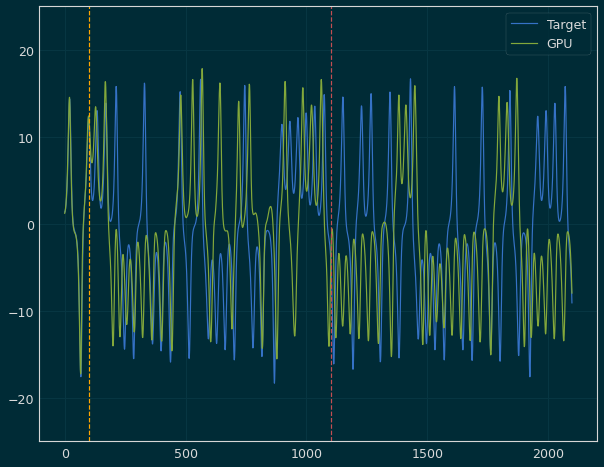

 Iter=42 a=0.399 sr=6.309 amp=0.618  ri=0.592 rr=0.624 loss=0.827416


Iter: 42 #### Diagnostic 0.827416   Time 4.85  Best 0.827 NRMSE 0.227 CD 0.600
Iter: 43 #### Diagnostic 1.389706   Time 6.05  Best 0.827 NRMSE 0.327 CD 1.063
Iter: 44 #### Diagnostic 1000.000000   Time 5.46  Best 0.827 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 6.03  Best 0.827 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.025638   Time 5.34  Best 0.827 NRMSE 0.257 CD 0.769
Iter: 47 #### Diagnostic 1.374054   Time 6.98  Best 0.827 NRMSE 0.306 CD 1.068
Iter: 48 #### Diagnostic 1000.000000   Time 6.14  Best 0.827 NRMSE 638556084042727817216.000 CD 1.000
Iter: 49 #### Diagnostic 1.069702   Time 6.29  Best 0.827 NRMSE 0.264 CD 0.805
Iter: 50 #### Diagnostic 1.183763   Time 5.45  Best 0.827 NRMSE 0.278 CD 0.906
Iter: 51 #### Diagnostic 1000.000000   Time 5.72  Best 0.827 NRMSE 39763387598383123938672640.000 CD 1.000
Iter: 52 #### Diagnostic 1.397144   Time 4.80  Best 0.827 NRMSE 0.392 CD 1.005
I

Iter: 37 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 8.22  Best 1000.000 NRMSE 40156994265421890767523151872.000 CD 1.000
Iter: 39 #### Diagnostic 1.408148   Time 5.85  Best 1000.000 NRMSE 0.327 CD 1.081
Iter: 40 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.642145   Time 6.77  Best 1000.000 NRMSE 0.661 CD 0.982
Iter: 43 #### Diagnostic 1.183479   Time 4.40  Best 1000.000 NRMSE 0.299 CD 0.884
Iter: 44 #### Diagnostic 1000.000000   Time 7.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.355192   Time 6.55  Best 1000.000 NRMSE 0.438 CD 0.917
Iter: 48 #### Diagnostic 1000.000000   Time

Iter: 32 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 6.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.062321   Time 5.85  Best 1000.000 NRMSE 0.274 CD 0.788
Iter: 35 #### Diagnostic 1.092999   Time 5.74  Best 1000.000 NRMSE 0.276 CD 0.817
Iter: 36 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.603257   Time 5.53  Best 1000.000 NRMSE 0.334 CD 1.270
Iter: 38 #### Diagnostic 1.058628   Time 7.29  Best 1000.000 NRMSE 0.288 CD 0.770
Iter: 39 #### Diagnostic 1000.000000   Time 7.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.141625   Time 6.11  Best 1000.000 NRMSE 0.276 CD 0.866
Iter: 41 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.532206   Time 5.81  Best 1000.000 NRMSE 0.308 C

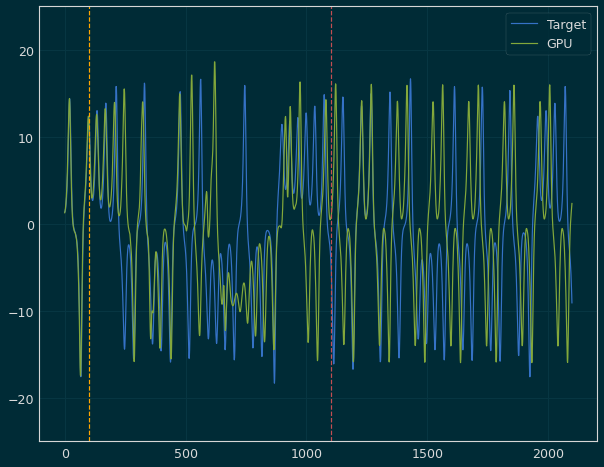

 Iter=2 a=0.714 sr=4.144 amp=0.786  ri=0.588 rr=3.684 loss=0.827746


Iter: 2 #### Diagnostic 0.827746   Time 5.24  Best 0.828 NRMSE 0.226 CD 0.601
Iter: 3 #### Diagnostic 1.128906   Time 6.38  Best 0.828 NRMSE 0.274 CD 0.855
Iter: 4 #### Diagnostic 1000.000000   Time 5.44  Best 0.828 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.153710   Time 4.70  Best 0.828 NRMSE 0.287 CD 0.867
Iter: 6 #### Diagnostic 1000.000000   Time 8.22  Best 0.828 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.210484   Time 4.53  Best 0.828 NRMSE 0.282 CD 0.929
Iter: 8 #### Diagnostic 1000.000000   Time 6.94  Best 0.828 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.291664   Time 6.11  Best 0.828 NRMSE 0.307 CD 0.984
Iter: 10 #### Diagnostic 1000.000000   Time 5.69  Best 0.828 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.352420   Time 4.86  Best 0.828 NRMSE 0.303 CD 1.049
Iter: 12 #### Diagnostic 1.355339   Time 5.49  Best 0.828 NRMSE 0.330 CD 1.026
Iter: 13 #### Diagnostic 1000.000000   Time 5.70  Bes

Iter: 0 #### Diagnostic 1000.000000   Time 6.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.384288   Time 6.97  Best 1000.000 NRMSE 0.292 CD 1.092
Iter: 3 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 4.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.284431   Time 6.51  Best 1000.000 NRMSE 0.304 CD 0.980
Iter: 7 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.424935   Time 6.14  Best 1000.000 NRMSE 0.319 CD 1.106
Iter: 10 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 6.83  Best 1000.000 NRMSE 1000.0

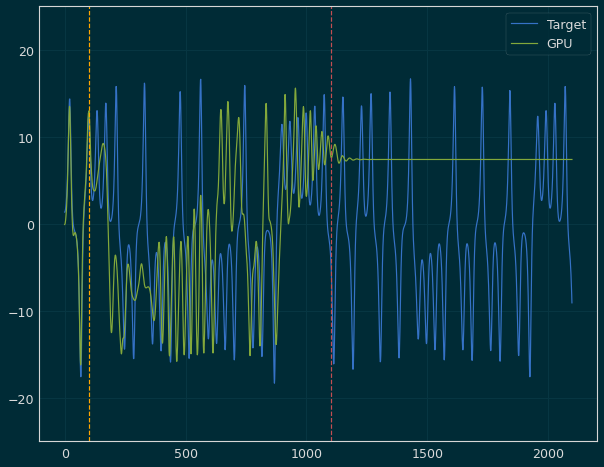

 Iter=55 a=0.447 sr=7.330 amp=0.881  ri=0.672 rr=0.397 loss=0.849367


Iter: 55 #### Diagnostic 0.849367   Time 6.41  Best 0.849 NRMSE 0.236 CD 0.613
Iter: 56 #### Diagnostic 1.578284   Time 9.07  Best 0.849 NRMSE 0.742 CD 0.836
Iter: 57 #### Diagnostic 1000.000000   Time 9.45  Best 0.849 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 6.46  Best 0.849 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.129988   Time 5.05  Best 0.849 NRMSE 0.270 CD 0.860
Iter: 60 #### Diagnostic 1000.000000   Time 5.56  Best 0.849 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 7.48  Best 0.849 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 6.36  Best 0.849 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.326239   Time 5.66  Best 0.849 NRMSE 0.306 CD 1.020
Iter: 64 #### Diagnostic 1.339777   Time 8.31  Best 0.849 NRMSE 0.342 CD 0.998
Iter: 65 #### Diagnostic 1.349987   Time 8.53  Best 0.849 NRMSE 0.297 CD 1.053
Iter: 66 #### Diagnostic 1000.000000   T

Iter: 50 #### Diagnostic 1.375194   Time 4.82  Best 1000.000 NRMSE 0.313 CD 1.062
Iter: 51 #### Diagnostic 1.382390   Time 4.50  Best 1000.000 NRMSE 0.322 CD 1.060
Iter: 52 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.253587   Time 6.13  Best 1000.000 NRMSE 0.292 CD 0.962
Iter: 54 #### Diagnostic 1.089146   Time 4.96  Best 1000.000 NRMSE 0.260 CD 0.829
Iter: 55 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.343570   Time 5.75  Best 1000.000 NRMSE 0.304 CD 1.039
Iter: 59 #### Diagnostic 1.187654   Time 5.69  Best 1000.000 NRMSE 0.282 CD 0.906
Iter: 60 #### Diagnostic 1.385988   Time 5.14  Best 1000.000 NRMSE 0.328 CD 1.058
Iter: 61 #### Diagnostic 1.103682   Time 5.44  Best 1000.000 NRMSE 0.268 CD 0.835


Iter: 45 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.165497   Time 5.71  Best 1000.000 NRMSE 0.284 CD 0.881
Iter: 52 #### Diagnostic 1000.000000   Time 6.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.571272   Time 7.56  Best 1000.000 NRMSE 0.559 CD 1.012
Iter: 54 #### Diagnostic 1.312199   Time 5.81  Best 1000.000 NRMSE 0.310 CD 1.002
Iter: 55 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.415288   Time 5.56  Best 1000.000 NRMSE

Iter: 40 #### Diagnostic 1.192058   Time 6.09  Best 1000.000 NRMSE 0.281 CD 0.911
Iter: 41 #### Diagnostic 1000.000000   Time 8.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 6.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 6.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 344644726519810234356684330515824640.000 CD 1.000
Iter: 47 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.376492   Time 5.14  Best 1000.000 NRMSE 0.333 CD 1.043
Iter: 50 #### Diagnostic 1000.000000   Time 8.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 100

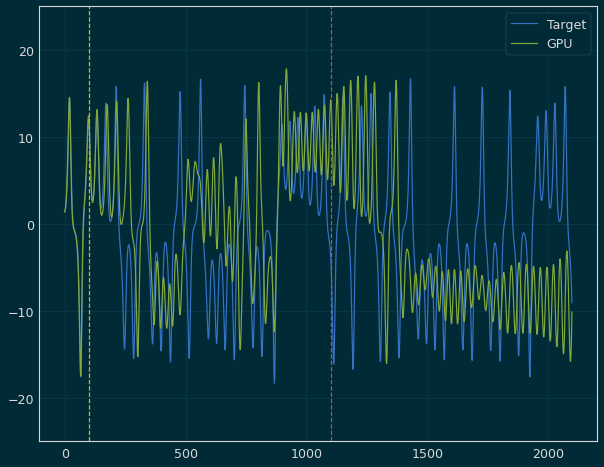

 Iter=68 a=0.097 sr=4.707 amp=0.596  ri=0.590 rr=0.848 loss=0.786861


Iter: 68 #### Diagnostic 0.786861   Time 4.92  Best 0.787 NRMSE 0.221 CD 0.566
Iter: 69 #### Diagnostic 1.019000   Time 5.53  Best 0.787 NRMSE 0.253 CD 0.766
Iter: 70 #### Diagnostic 1.282765   Time 4.77  Best 0.787 NRMSE 0.299 CD 0.984
Iter: 71 #### Diagnostic 1000.000000   Time 7.62  Best 0.787 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 6.62  Best 0.787 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 6.44  Best 0.787 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 6.07  Best 0.787 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 6.45  Best 0.787 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 4.65  Best 0.787 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.15  Best 0.787 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 428.355228   Time 5.85  Best 0.787 NRMSE 427.356 CD 1.000
Iter: 79 #### Diagnostic 100

Iter: 56 #### Diagnostic 1.318358   Time 4.86  Best 1000.000 NRMSE 0.290 CD 1.028
Iter: 57 #### Diagnostic 1000.000000   Time 5.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 6.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 5.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.065943   Time 6.60  Best 1000.000 NRMSE 0.263 CD 0.803
Iter: 64 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.35  Best 1000.00

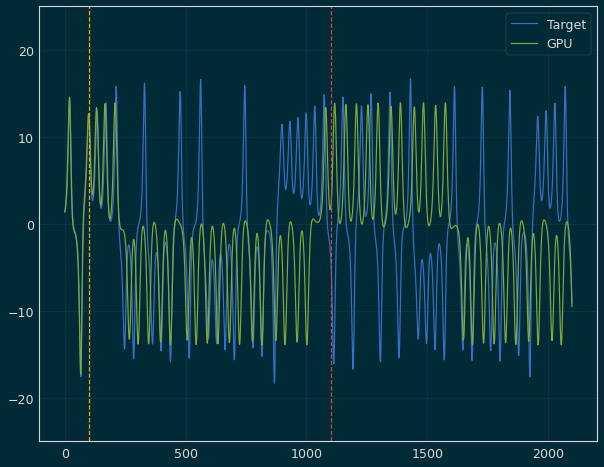

 Iter=32 a=0.082 sr=2.440 amp=0.001  ri=0.957 rr=4.031 loss=0.779246


Iter: 32 #### Diagnostic 0.779246   Time 6.63  Best 0.779 NRMSE 0.211 CD 0.568
Iter: 33 #### Diagnostic 1.378215   Time 6.21  Best 0.779 NRMSE 0.309 CD 1.069
Iter: 34 #### Diagnostic 1000.000000   Time 5.57  Best 0.779 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.035506   Time 5.85  Best 0.779 NRMSE 0.275 CD 0.761
Iter: 36 #### Diagnostic 1000.000000   Time 6.84  Best 0.779 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.218279   Time 5.32  Best 0.779 NRMSE 0.286 CD 0.932
Iter: 38 #### Diagnostic 1000.000000   Time 5.86  Best 0.779 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 6.28  Best 0.779 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 6.48  Best 0.779 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.307329   Time 5.81  Best 0.779 NRMSE 0.297 CD 1.010
Iter: 42 #### Diagnostic 1000.000000   Time 5.16  Best 0.779 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.818702   

Iter: 28 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 8.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.376187   Time 4.21  Best 1000.000 NRMSE 0.303 CD 1.073
Iter: 36 #### Diagnostic 1.309826   Time 4.75  Best 1000.000 NRMSE 0.285 CD 1.025
Iter: 37 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.357434   Time 5.22  Best 1000.000 NRMSE 0.313 CD 1.045
Iter: 39 #### Diagnostic 1000.000000   Time 6.40  Best 1000.000 NR

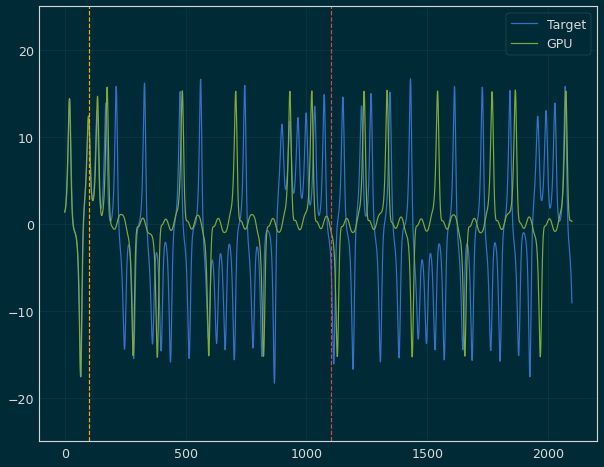

 Iter=72 a=0.889 sr=0.663 amp=0.221  ri=0.851 rr=4.421 loss=0.803312


Iter: 72 #### Diagnostic 0.803312   Time 8.22  Best 0.803 NRMSE 0.197 CD 0.606
Iter: 73 #### Diagnostic 0.895011   Time 5.60  Best 0.803 NRMSE 0.239 CD 0.656
Iter: 74 #### Diagnostic 1000.000000   Time 6.13  Best 0.803 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.153357   Time 5.37  Best 0.803 NRMSE 0.287 CD 0.866
Iter: 76 #### Diagnostic 1.362288   Time 5.79  Best 0.803 NRMSE 0.360 CD 1.002
Iter: 77 #### Diagnostic 1.108471   Time 5.39  Best 0.803 NRMSE 0.270 CD 0.838
Iter: 78 #### Diagnostic 1000.000000   Time 6.88  Best 0.803 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 6.49  Best 0.803 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.346599   Time 5.92  Best 0.803 NRMSE 0.297 CD 1.050
Iter: 81 #### Diagnostic 1.255462   Time 5.55  Best 0.803 NRMSE 0.301 CD 0.954
Iter: 82 #### Diagnostic 1000.000000   Time 7.07  Best 0.803 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 

Iter: 67 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 9.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 9.996224   Time 7.56  Best 1000.000 NRMSE 8.803 CD 1.193
Iter: 71 #### Diagnostic 1000.000000   Time 6.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.633341   Time 5.30  Best 1000.000 NRMSE 0.633 CD 1.001
Iter: 73 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.503031   Time 4.53  Best 1000.000 NRMSE 0.315 CD 1.188
Iter: 76 #### Diagnostic 1.553461   Time 5.14  Best 1000.000 NRMSE 0.319 CD 1.235
Iter: 77 #### Diagnostic 1000.000000   Time 7.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.155998   Time 5.43  Best 1000.000 NRMSE 0.2

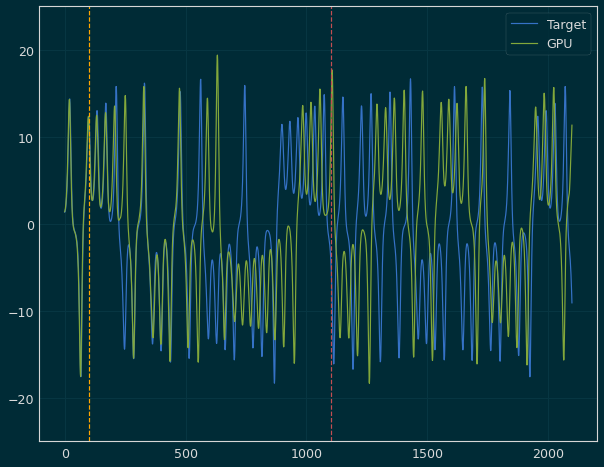

 Iter=83 a=0.716 sr=2.476 amp=0.920  ri=0.523 rr=2.387 loss=0.815955


Iter: 83 #### Diagnostic 0.815955   Time 4.80  Best 0.816 NRMSE 0.224 CD 0.592
Iter: 84 #### Diagnostic 1000.000000   Time 4.89  Best 0.816 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 8.01  Best 0.816 NRMSE 186405301098184.969 CD 0.854
Iter: 86 #### Diagnostic 1000.000000   Time 5.34  Best 0.816 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 7.90  Best 0.816 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.243474   Time 4.48  Best 0.816 NRMSE 0.280 CD 0.963
Iter: 89 #### Diagnostic 1.401401   Time 7.76  Best 0.816 NRMSE 0.301 CD 1.101
Iter: 90 #### Diagnostic 1.149745   Time 5.56  Best 0.816 NRMSE 0.323 CD 0.827
Iter: 91 #### Diagnostic 1000.000000   Time 6.27  Best 0.816 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 7.95  Best 0.816 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.92  Best 0.816 NRMSE 1000.000 CD nan
Iter: 94 #### Diagn

Iter: 78 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 2.082427   Time 8.05  Best 1000.000 NRMSE 1.008 CD 1.075
Iter: 80 #### Diagnostic 1000.000000   Time 9.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.354378   Time 5.53  Best 1000.000 NRMSE 0.299 CD 1.055
Iter: 82 #### Diagnostic 1.332917   Time 4.78  Best 1000.000 NRMSE 0.314 CD 1.019
Iter: 83 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 6.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 3138010960123425280.000 CD 1.000
Iter: 87 #### Diagnostic 1.042573   Time 4.53  Best 1000.000 NRMSE 0.264 CD 0.778
Iter: 88 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 6.19  Bes

Iter: 66 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 4.549624   Time 5.08  Best 1000.000 NRMSE 3.470 CD 1.080
Iter: 68 #### Diagnostic 2.064038   Time 5.37  Best 1000.000 NRMSE 1.044 CD 1.020
Iter: 69 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.376347   Time 4.45  Best 1000.000 NRMSE 0.287 CD 1.089
Iter: 71 #### Diagnostic 1000.000000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.356711   Time 4.48  Best 1000.000 NRMSE 0.298 CD 1.058
Iter: 73 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.178277   Time 6.04  Best 1000.000 NRMSE 0.268 CD 0.910
Iter: 76 #### Diagnostic 1000.000000   Time 5.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.008266   Time 7.38  Best 1000.000 NRMSE 0.263 C

Iter: 61 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.588521   Time 5.27  Best 1000.000 NRMSE 0.544 CD 1.045
Iter: 65 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.299069   Time 4.86  Best 1000.000 NRMSE 0.309 CD 0.990
Iter: 68 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 8.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 9.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 6.62  Best 1000.00

Iter: 56 #### Diagnostic 1000.000000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.499583   Time 5.06  Best 1000.000 NRMSE 0.320 CD 1.180
Iter: 59 #### Diagnostic 1.238173   Time 8.01  Best 1000.000 NRMSE 0.285 CD 0.953
Iter: 60 #### Diagnostic 1.412022   Time 4.27  Best 1000.000 NRMSE 0.314 CD 1.098
Iter: 61 #### Diagnostic 0.892603   Time 4.56  Best 1000.000 NRMSE 0.242 CD 0.651
Iter: 62 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.327246   Time 5.79  Best 1000.000 NRMSE 0.282 CD 1.045
Iter: 65 #### Diagnostic 1.020254   Time 6.27  Best 1000.000 NRMSE 0.261 CD 0.760
Iter: 66 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 297056182546543168.000 CD 1.000
Iter: 67 #### Diagnostic 1.210746   Time 6.11  Best 1000.000 N

Iter: 51 #### Diagnostic 1.198261   Time 7.17  Best 1000.000 NRMSE 0.279 CD 0.919
Iter: 52 #### Diagnostic 1.096204   Time 6.76  Best 1000.000 NRMSE 0.274 CD 0.822
Iter: 53 #### Diagnostic 1.390802   Time 6.16  Best 1000.000 NRMSE 0.303 CD 1.087
Iter: 54 #### Diagnostic 1.284022   Time 5.90  Best 1000.000 NRMSE 0.301 CD 0.983
Iter: 55 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.402492   Time 6.97  Best 1000.000 NRMSE 0.336 CD 1.067
Iter: 57 #### Diagnostic 1000.000000   Time 8.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.318381   Time 5.71  Best 1000.000 NRMSE 0.307 CD 1.011
Iter: 62 #### Diagnostic 1.203307   Time 7.15  Best 1000.000 NRMSE 0.292 CD 0.

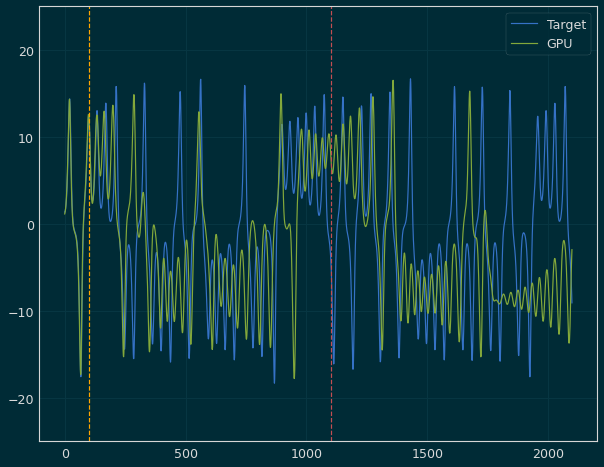

 Iter=97 a=0.164 sr=7.114 amp=0.496  ri=0.806 rr=3.115 loss=0.785194


Iter: 97 #### Diagnostic 0.785194   Time 5.56  Best 0.785 NRMSE 0.217 CD 0.568
Iter: 98 #### Diagnostic 1.394297   Time 4.64  Best 0.785 NRMSE 0.298 CD 1.096
Iter: 99 #### Diagnostic 1000.000000   Time 6.58  Best 0.785 NRMSE 1000.000 CD nan

Best result = 0.7851942750512041
a = 0.16448561371218068
sr = 7.11443121372315
amp = 0.49573042649904464
ri = 0.8058000965994152
rr = 3.1146197062171135
********** Size 300 -- Run 4 ***********
Iter: 0 #### Diagnostic 2.132359   Time 5.99  Best 1000.000 NRMSE 1.251 CD 0.881
Iter: 1 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 4.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 100

Iter: 91 #### Diagnostic 1000.000000   Time 6.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 241342157.692 CD 1.061
Iter: 93 #### Diagnostic 1.051437   Time 7.02  Best 1000.000 NRMSE 0.269 CD 0.783
Iter: 94 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.375816   Time 5.36  Best 1000.000 NRMSE 0.314 CD 1.062
Iter: 97 #### Diagnostic 1.132366   Time 8.02  Best 1000.000 NRMSE 0.271 CD 0.861
Iter: 98 #### Diagnostic 1.534314   Time 5.30  Best 1000.000 NRMSE 0.320 CD 1.214
Iter: 99 #### Diagnostic 1000.000000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.0401876722154764
a = 0.605392555163275
sr = 6.18663266515099
amp = 0.37150279174988055
ri = 0.40459632652059446
rr = 0.26395782276847085

Best mn:0.164	 mn:0.164
New bounds mn--mx: 0.017--0.293

Best mn:7.114	 mn:7.114

Iter: 78 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 2.003562   Time 4.77  Best 1000.000 NRMSE 1.115 CD 0.889
Iter: 80 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.324216   Time 4.51  Best 1000.000 NRMSE 0.303 CD 1.021
Iter: 83 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 6.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.226113   Time 4.13  Best 1000.000 NRMSE 0.280 CD 0.946
Iter: 88 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.251363   Time 4.13  Best 1000.000 NRMSE

Iter: 73 #### Diagnostic 1.119349   Time 4.80  Best 1000.000 NRMSE 0.292 CD 0.828
Iter: 74 #### Diagnostic 1000.000000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.939796   Time 4.93  Best 1000.000 NRMSE 0.249 CD 0.691
Iter: 76 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.068218   Time 5.75  Best 1000.000 NRMSE 0.258 CD 0.810
Iter: 79 #### Diagnostic 1000.000000   Time 5.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 0.967083   Time 4.60  Best 1000.000 NRMSE 0.250 CD 0.717
Iter: 81 #### Diagnostic 1.068965   Time 4.40  Best 1000.000 NRMSE 0.266 CD 0.803
Iter: 82 #### Diagnostic 2.964703   Time 5.28  Best 1000.000 NRMSE 1.849 CD 1.116
Iter: 83 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.443052   Time 4.05  Best 1000.000 NRMSE 0.311 CD 1.

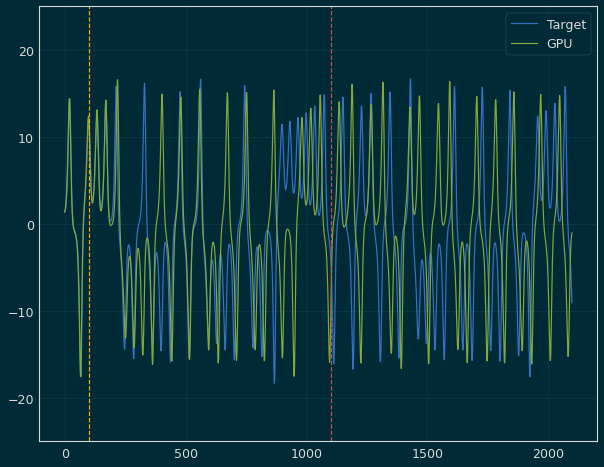

 Iter=88 a=0.569 sr=3.220 amp=0.820  ri=0.207 rr=3.722 loss=0.810647


Iter: 88 #### Diagnostic 0.810647   Time 7.03  Best 0.811 NRMSE 0.225 CD 0.586
Iter: 89 #### Diagnostic 1000.000000   Time 6.13  Best 0.811 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 5.45  Best 0.811 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 5.14  Best 0.811 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.61  Best 0.811 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.063216   Time 4.32  Best 0.811 NRMSE 0.254 CD 0.809
Iter: 94 #### Diagnostic 1000.000000   Time 6.29  Best 0.811 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.30  Best 0.811 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 4.93  Best 0.811 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 4.44  Best 0.811 NRMSE 472480386857632394117120.000 CD 1.000
Iter: 98 #### Diagnostic 1000.000000   Time 6.09  Best 0.811 NRMSE 1000.000 CD nan
It

Iter: 82 #### Diagnostic 1000.000000   Time 6.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.004528   Time 5.23  Best 1000.000 NRMSE 0.251 CD 0.753
Iter: 84 #### Diagnostic 1000.000000   Time 4.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.129156   Time 5.13  Best 1000.000 NRMSE 0.276 CD 0.853
Iter: 86 #### Diagnostic 1000.000000   Time 7.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 3.103810   Time 6.65  Best 1000.000 NRMSE 2.018 CD 1.086
Iter: 89 #### Diagnostic 1.298284   Time 5.16  Best 1000.000 NRMSE 0.298 CD 1.000
Iter: 90 #### Diagnostic 1.424559   Time 5.33  Best 1000.000 NRMSE 0.308 CD 1.116
Iter: 91 #### Diagnostic 1.348617   Time 5.10  Best 1000.000 NRMSE 0.293 CD 1.056
Iter: 92 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 13.553906   Time 7.58  Best 1000.000 NRMSE 12.615 CD 

Iter: 77 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.319506   Time 6.13  Best 1000.000 NRMSE 0.293 CD 1.026
Iter: 79 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.155918   Time 5.08  Best 1000.000 NRMSE 0.273 CD 0.883
Iter: 81 #### Diagnostic 1000.000000   Time 4.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.227739   Time 4.97  Best 1000.000 NRMSE 0.278 CD 0.950
Iter: 83 #### Diagnostic 1000.000000   Time 6.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.343869   Time 4.29  Best 1000.000 NRMSE 0.299 CD 1.045
Iter: 85 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1892.946 CD 0.904
Iter: 86 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.574934   Time 4.09  Best 1000.000 NRMSE 0

Iter: 72 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.428553   Time 4.84  Best 1000.000 NRMSE 0.319 CD 1.110
Iter: 75 #### Diagnostic 1000.000000   Time 7.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 4.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.315999   Time 5.52  Best 1000.000 NRMSE 0.299 CD 1.017
Iter: 78 #### Diagnostic 1000.000000   Time 5.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.711387   Time 5.09  Best 1000.000 NRMSE 0.837 CD 0.875
Iter: 80 #### Diagnostic 1.451925   Time 5.08  Best 1000.000 NRMSE 0.333 CD 1.119
Iter: 81 #### Diagnostic 1.226182   Time 4.43  Best 1000.000 NRMSE 0.281 CD 0.945
Iter: 82 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000

Iter: 60 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.508860   Time 5.75  Best 1000.000 NRMSE 0.621 CD 0.888
Iter: 63 #### Diagnostic 1.093091   Time 7.90  Best 1000.000 NRMSE 0.268 CD 0.825
Iter: 64 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.507329   Time 6.09  Best 1000.000 NRMSE 0.318 CD 1.189
Iter: 66 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 3.569976   Time 4.59  Best 1000.000 NRMSE 2.583 CD 0.987
Iter: 69 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.347355   Time 5.52  Best 1000.000 NRMSE 0.297 CD 1.050
Iter: 71 #### Diagnostic 1.153608   Time 6.11  Best 1000.000 NRMSE 0.289 C

Iter: 55 #### Diagnostic 1.370297   Time 4.80  Best 1000.000 NRMSE 0.313 CD 1.057
Iter: 56 #### Diagnostic 1.265841   Time 4.59  Best 1000.000 NRMSE 0.292 CD 0.974
Iter: 57 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.291917   Time 4.66  Best 1000.000 NRMSE 0.302 CD 0.990
Iter: 60 #### Diagnostic 1000.000000   Time 4.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.537757   Time 4.48  Best 1000.000 NRMSE 0.548 CD 0.990
Iter: 65 #### Diagnostic 1.492453   Time 4.40  Best 1000.000 NRMSE 0.318 CD 1.174
Iter: 66 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000

Iter: 49 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.286924   Time 5.14  Best 1000.000 NRMSE 0.285 CD 1.001
Iter: 51 #### Diagnostic 1.233261   Time 6.04  Best 1000.000 NRMSE 0.294 CD 0.939
Iter: 52 #### Diagnostic 1000.000000   Time 5.87  Best 1000.000 NRMSE 2621911428163944897860310401024.000 CD 1.000
Iter: 53 #### Diagnostic 1.401162   Time 4.41  Best 1000.000 NRMSE 0.337 CD 1.064
Iter: 54 #### Diagnostic 1.114523   Time 5.34  Best 1000.000 NRMSE 0.271 CD 0.844
Iter: 55 #### Diagnostic 1.353590   Time 5.29  Best 1000.000 NRMSE 0.299 CD 1.054
Iter: 56 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.260472   Time 5.65  Best 1000.000 NRMSE 0.284 CD 0.976
Iter: 59 #### Diagnostic 1.137027   Time 4.76  Best 1000.000 NRMSE 0.271 CD 0.866
Iter: 60 #### Diagnostic 1.218080   Time 5.12  Best 1

Iter: 43 #### Diagnostic 1.205797   Time 5.89  Best 1000.000 NRMSE 0.284 CD 0.921
Iter: 44 #### Diagnostic 1000.000000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.312805   Time 4.33  Best 1000.000 NRMSE 0.290 CD 1.023
Iter: 52 #### Diagnostic 1.385604   Time 4.63  Best 1000.000 NRMSE 0.324 CD 1.062
Iter: 53 #### Diagnostic 1.285690   Time 5.84  Best 1000.000 NRMSE 0.291 CD 0.995
Iter: 54 #### Diagnostic 1.336834   Time 4.47  Best 1000.000 NRMSE 0.3

Iter: 38 #### Diagnostic 1.538946   Time 4.87  Best 1000.000 NRMSE 0.554 CD 0.985
Iter: 39 #### Diagnostic 1000.000000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 5.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.383638   Time 5.48  Best 1000.000 NRMSE 0.286 CD 1.098
Iter: 44 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 128000684.553 CD 0.994
Iter: 47 #### Diagnostic 1.221493   Time 5.03  Best 1000.000 NRMSE 0.277 CD 0.945
Iter: 48 #### Diagnostic 1000.000000   Time 4.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.393553   Time 5.18  Best 1000.00

Iter: 29 #### Diagnostic 1.374993   Time 5.07  Best 1000.000 NRMSE 0.319 CD 1.056
Iter: 30 #### Diagnostic 1000.000000   Time 6.01  Best 1000.000 NRMSE 237986274641305641695576064.000 CD 1.000
Iter: 31 #### Diagnostic 1000.000000   Time 4.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.161824   Time 5.73  Best 1000.000 NRMSE 0.291 CD 0.871
Iter: 33 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.361783   Time 4.02  Best 1000.000 NRMSE 0.304 CD 1.057
Iter: 35 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.507568   Time 

Iter: 24 #### Diagnostic 1.250559   Time 4.36  Best 1000.000 NRMSE 0.288 CD 0.962
Iter: 25 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.357117   Time 5.86  Best 1000.000 NRMSE 0.338 CD 1.019
Iter: 27 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 5.526039   Time 5.10  Best 1000.000 NRMSE 4.522 CD 1.005
Iter: 30 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.312374   Time 5.04  Best 1000.000 NRMSE 0.298 CD 1.014
Iter: 32 #### Diagnostic 1.383669   Time 5.53  Best 1000.000 NRMSE 0.320 CD 1.063
Iter: 33 #### Diagnostic 1.160527   Time 4.36  Best 1000.000 NRMSE 0.274 CD 0.886
Iter: 34 #### Diagnostic 1000.000000   Time 4.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.027306   Time 5.72  Best 1000.000 NRMSE 0.257 CD 0.

Iter: 19 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.462328   Time 4.22  Best 1000.000 NRMSE 0.315 CD 1.147
Iter: 23 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.664316   Time 4.75  Best 1000.000 NRMSE 0.669 CD 0.995
Iter: 26 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.133167   Time 4.51  Best 1000.000 NRMSE 0.277 CD 0.856
Iter: 28 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NR

Iter: 14 #### Diagnostic 1.441045   Time 4.30  Best 1000.000 NRMSE 0.351 CD 1.090
Iter: 15 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.378847   Time 4.92  Best 1000.000 NRMSE 0.321 CD 1.058
Iter: 20 #### Diagnostic 1.555762   Time 4.65  Best 1000.000 NRMSE 0.335 CD 1.221
Iter: 21 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 7.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.267285   Time 4.46  Best 1000.000 NRMSE 0.274 CD 0.993
Iter: 24 #### Diagnostic 1000.000000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.327006   Time 4.05  Best 1000.000 NRMSE 0.3

Iter: 9 #### Diagnostic 1000.000000   Time 6.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.229873   Time 5.42  Best 1000.000 NRMSE 0.286 CD 0.944
Iter: 11 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.541222   Time 4.64  Best 1000.000 NRMSE 0.392 CD 1.149
Iter: 13 #### Diagnostic 1.347256   Time 4.13  Best 1000.000 NRMSE 0.296 CD 1.051
Iter: 14 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.209816   Time 5.87  Best 1000.000 NRMSE 0.277 CD 0.933
Iter: 16 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.456356   Time 4.35  Best 1000.000 NRMSE 0.420 CD 1.036
Iter: 18 #### Diagnostic 1.460813   Time 5.25  Best 1000.000 NRMSE 0.325 CD 1.136
Iter: 19 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.866172   Time 4.54  Best 1000.000 NRMSE 0.230 CD 0.6

Iter: 1 #### Diagnostic 1000.000000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan


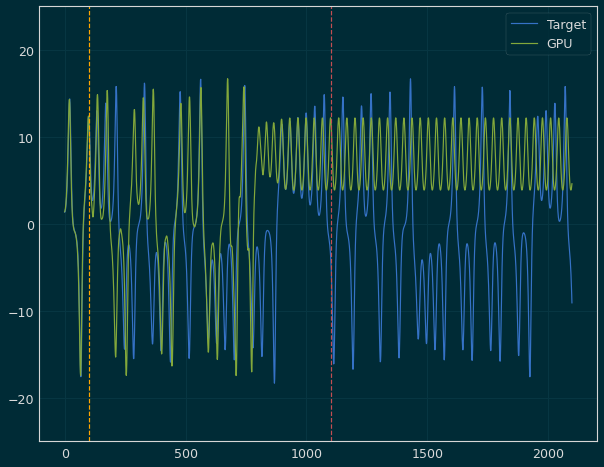

 Iter=2 a=0.714 sr=4.144 amp=0.786  ri=0.588 rr=3.684 loss=0.839246


Iter: 2 #### Diagnostic 0.839246   Time 6.32  Best 0.839 NRMSE 0.232 CD 0.607
Iter: 3 #### Diagnostic 1.347621   Time 4.19  Best 0.839 NRMSE 0.290 CD 1.057
Iter: 4 #### Diagnostic 1.380470   Time 6.86  Best 0.839 NRMSE 0.300 CD 1.080
Iter: 5 #### Diagnostic 1.359555   Time 4.84  Best 0.839 NRMSE 0.313 CD 1.047
Iter: 6 #### Diagnostic 1000.000000   Time 5.97  Best 0.839 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.376548   Time 4.29  Best 0.839 NRMSE 0.301 CD 1.076
Iter: 8 #### Diagnostic 1000.000000   Time 4.86  Best 0.839 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.365539   Time 5.51  Best 0.839 NRMSE 0.316 CD 1.049
Iter: 10 #### Diagnostic 1000.000000   Time 5.63  Best 0.839 NRMSE 230983214502060991239145769496739840.000 CD 1.000
Iter: 11 #### Diagnostic 0.976982   Time 4.72  Best 0.839 NRMSE 0.249 CD 0.728
Iter: 12 #### Diagnostic 1.194227   Time 4.20  Best 0.839 NRMSE 0.283 CD 0.911
Iter: 13 #### Diagnosti

Iter: 0 #### Diagnostic 1.445364   Time 5.49  Best 1000.000 NRMSE 0.298 CD 1.147
Iter: 1 #### Diagnostic 1000.000000   Time 4.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.288787   Time 5.84  Best 1000.000 NRMSE 0.284 CD 1.005
Iter: 3 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 0.914504   Time 5.06  Best 1000.000 NRMSE 0.239 CD 0.676
Iter: 6 #### Diagnostic 1.080752   Time 4.84  Best 1000.000 NRMSE 0.266 CD 0.815
Iter: 7 #### Diagnostic 1.155712   Time 5.55  Best 1000.000 NRMSE 0.280 CD 0.876
Iter: 8 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.209708   Time 4.63  Best 1000.000 NRMSE 0.277 CD 0.932
Iter: 10 #### Diagnostic 1000.000000   Time 6.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 6.32  Best 1000.000 NRMSE 1000.000 CD nan
It

Iter: 97 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 53849148849266490343424000.000 CD 1.000
Iter: 98 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.9145043232255384
a = 0.6028118683743945
sr = 4.8375591889983465
amp = 0.5403285473194608
ri = 0.660040432048082
rr = 2.3401311294146985
********** Size 200 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.383966   Time 9.10  Best 1000.000 NRMSE 0.317 CD 1.067
Iter: 2 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.283094   Time 5.92  Best 1000.000 NRMSE 0.421 CD 0.862
Iter: 6 #### Diagnosti

Iter: 92 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 11.699593   Time 5.56  Best 1000.000 NRMSE 10.664 CD 1.035
Iter: 94 #### Diagnostic 113.740122   Time 6.36  Best 1000.000 NRMSE 112.706 CD 1.035
Iter: 95 #### Diagnostic 37.868175   Time 6.06  Best 1000.000 NRMSE 36.987 CD 0.881
Iter: 96 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 2.690956   Time 5.37  Best 1000.000 NRMSE 1.528 CD 1.163
Iter: 99 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.9684167465872978
a = 0.782601600617731
sr = 6.350304402689221
amp = 0.3815479434668485
ri = 0.4085090776279974
rr = 0.5291903854571391
********** Size 200 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 6.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.201362   Time 4.

Iter: 87 #### Diagnostic 1.286262   Time 5.81  Best 1000.000 NRMSE 0.291 CD 0.995
Iter: 88 #### Diagnostic 1.421883   Time 5.44  Best 1000.000 NRMSE 0.315 CD 1.107
Iter: 89 #### Diagnostic 1.237819   Time 4.80  Best 1000.000 NRMSE 0.271 CD 0.966
Iter: 90 #### Diagnostic 1000.000000   Time 5.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 7.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.415923   Time 5.31  Best 1000.000 NRMSE 0.437 CD 0.979
Iter: 94 #### Diagnostic 1.323617   Time 6.25  Best 1000.000 NRMSE 0.389 CD 0.935
Iter: 95 #### Diagnostic 2.437786   Time 6.56  Best 1000.000 NRMSE 1.441 CD 0.997
Iter: 96 #### Diagnostic 1000.000000   Time 5.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.546122   Time 4.15  Best 1000.000 NRMSE 0.323 CD 1.224
Iter: 98 #### Diagnostic 1.051236   Time 4.59  Best 1000.000 NRMSE 0.232 CD 0.820


Iter: 83 #### Diagnostic 1000.000000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 578.668501   Time 6.50  Best 1000.000 NRMSE 577.588 CD 1.081
Iter: 87 #### Diagnostic 1.388463   Time 5.00  Best 1000.000 NRMSE 0.316 CD 1.073
Iter: 88 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 5.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 575287302244221779968.000 CD 1.000
Iter: 93 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   

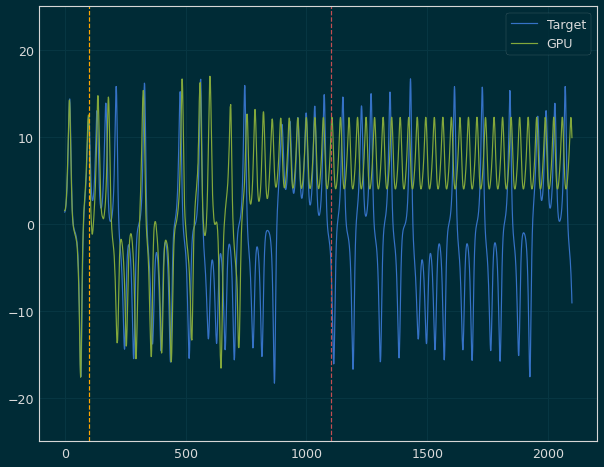

 Iter=33 a=0.979 sr=4.845 amp=0.796  ri=0.653 rr=0.937 loss=0.811705


Iter: 33 #### Diagnostic 0.811705   Time 4.84  Best 0.812 NRMSE 0.224 CD 0.588
Iter: 34 #### Diagnostic 1.178715   Time 4.42  Best 0.812 NRMSE 0.278 CD 0.901
Iter: 35 #### Diagnostic 1000.000000   Time 6.50  Best 0.812 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 5.54  Best 0.812 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 6.11  Best 0.812 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.89  Best 0.812 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 4.87  Best 0.812 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.293058   Time 4.89  Best 0.812 NRMSE 0.305 CD 0.988
Iter: 41 #### Diagnostic 1000.000000   Time 6.68  Best 0.812 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.258201   Time 6.29  Best 0.812 NRMSE 0.271 CD 0.987
Iter: 43 #### Diagnostic 1000.000000   Time 4.93  Best 0.812 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.22526

Iter: 30 #### Diagnostic 1.321742   Time 6.38  Best 1000.000 NRMSE 0.299 CD 1.023
Iter: 31 #### Diagnostic 1.284243   Time 5.77  Best 1000.000 NRMSE 0.292 CD 0.992
Iter: 32 #### Diagnostic 1.376091   Time 6.04  Best 1000.000 NRMSE 0.320 CD 1.056
Iter: 33 #### Diagnostic 1.224856   Time 7.62  Best 1000.000 NRMSE 0.286 CD 0.939
Iter: 34 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.317531   Time 4.12  Best 1000.000 NRMSE 0.294 CD 1.024
Iter: 38 #### Diagnostic 1.376288   Time 5.53  Best 1000.000 NRMSE 0.301 CD 1.075
Iter: 39 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.040915   Time 5.62  Best 1000.000 NRMSE 0.268 CD 0.

Iter: 25 #### Diagnostic 1.493064   Time 6.38  Best 1000.000 NRMSE 0.545 CD 0.948
Iter: 26 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.241542   Time 4.54  Best 1000.000 NRMSE 0.287 CD 0.955
Iter: 28 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.342530   Time 5.81  Best 1000.000 NRMSE 0.310 CD 1.033
Iter: 31 #### Diagnostic 126.009407   Time 6.15  Best 1000.000 NRMSE 125.021 CD 0.989
Iter: 32 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.361229   Time 4.97  Best 1000.000 NRMSE 0.300 CD 1.061
Iter: 34 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 38.606830   Time 4.11  Best 1000.000 NRMSE 37.585 CD 1.021
Iter: 36 #### Diagnostic 1.340809   Time 5.08  Best 1000.000 NRMSE 0.305

Iter: 20 #### Diagnostic 1.470289   Time 5.87  Best 1000.000 NRMSE 0.311 CD 1.160
Iter: 21 #### Diagnostic 1000.000000   Time 5.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.348196   Time 6.85  Best 1000.000 NRMSE 0.286 CD 1.063
Iter: 24 #### Diagnostic 1000.000000   Time 4.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.205485   Time 4.34  Best 1000.000 NRMSE 0.280 CD 0.925
Iter: 26 #### Diagnostic 1000.000000   Time 9.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 6.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.135205   Time 4.91  Best 1000.000 NRMSE 0.275 CD 0.860
Iter: 30 #### Diagnostic 1.362399   Time 4.61  Best 1000.000 NRMSE 0.320 CD 1.043
Iter: 31 #### Diagnostic 1.407978   Time 4.88  Best 1000.000 NRMSE 0.298 C

Iter: 15 #### Diagnostic 1000.000000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.271936   Time 5.78  Best 1000.000 NRMSE 0.361 CD 0.911
Iter: 18 #### Diagnostic 1.474310   Time 4.21  Best 1000.000 NRMSE 0.315 CD 1.159
Iter: 19 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.436825   Time 4.21  Best 1000.000 NRMSE 0.314 CD 1.123
Iter: 21 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.499509   Time 5.05  Best 1000.000 NRMSE 0.434 CD 1.065
Iter: 25 #### Diagnostic 1.431910   Time 6.41  Best 1000.000 NRMSE 0.423 CD 1.009
Iter: 26 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000

Iter: 3 #### Diagnostic 1.336730   Time 4.49  Best 1000.000 NRMSE 0.277 CD 1.059
Iter: 4 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.364800   Time 4.80  Best 1000.000 NRMSE 0.313 CD 1.052
Iter: 6 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.342569   Time 5.08  Best 1000.000 NRMSE 0.295 CD 1.047
Iter: 8 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.326529   Time 4.28  Best 1000.000 NRMSE 0.271 CD 1.055
Iter: 10 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.357478   Time 5.49  Best 1000.000 NRMSE 0.317 CD 1.040
Iter: 12 #### Diagnostic 1.160263   Time 3.97  Best 1000.000 NRMSE 0.277 CD 0.883
Iter: 13 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan

Iter: 0 #### Diagnostic 1.272704   Time 4.53  Best 1000.000 NRMSE 0.303 CD 0.970
Iter: 1 #### Diagnostic 1.247182   Time 4.84  Best 1000.000 NRMSE 0.282 CD 0.966
Iter: 2 #### Diagnostic 1.274623   Time 4.49  Best 1000.000 NRMSE 0.281 CD 0.994
Iter: 3 #### Diagnostic 1000.000000   Time 5.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.289805   Time 4.83  Best 1000.000 NRMSE 0.296 CD 0.994
Iter: 7 #### Diagnostic 1.577125   Time 6.40  Best 1000.000 NRMSE 0.328 CD 1.250
Iter: 8 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.290247   Time 4.41  Best 1000.000 NRMSE 0.243 CD 1.047
Iter: 10 #### Diagnostic 1000.000000   Time 6.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
It

Iter: 98 #### Diagnostic 1000.000000   Time 5.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 1.0241658196573145
a = 0.8077328350826714
sr = 7.65118020756791
amp = 0.7521138738445983
ri = 0.8039861628448642
rr = 1.8901353408622261
********** Size 100 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 4.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.352222   Time 4.55  Best 1000.000 NRMSE 0.311 CD 1.041
Iter: 2 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.399318   Time 4.62  Best 1000.000 NRMSE 0.326 CD 1.074
Iter: 7 #### Diagnostic 1000.000000   Time 5.97 

Iter: 93 #### Diagnostic 211.372723   Time 4.62  Best 1000.000 NRMSE 210.373 CD 1.000
Iter: 94 #### Diagnostic 1000.000000   Time 4.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 4.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.790697   Time 4.19  Best 1000.000 NRMSE 0.795 CD 0.996
Iter: 99 #### Diagnostic 1.418670   Time 4.09  Best 1000.000 NRMSE 0.344 CD 1.075

Best result = 0.9956436158906758
a = 0.6077363932000435
sr = 7.648229223517668
amp = 0.8825517059688698
ri = 0.625882887518904
rr = 3.3526600677835456
********** Size 100 -- Run 3 ***********
Iter: 0 #### Diagnostic 1.363312   Time 5.68  Best 1000.000 NRMSE 0.309 CD 1.054
Iter: 1 #### Diagnostic 1.329909   Time 6.49  Best 1000.000 NRMSE 0.308 CD 1.022
Iter: 2 #### Diagnostic 1.377870   Time 5.81  Best 

Iter: 88 #### Diagnostic 1.412865   Time 6.07  Best 1000.000 NRMSE 0.315 CD 1.098
Iter: 89 #### Diagnostic 1.217562   Time 6.28  Best 1000.000 NRMSE 0.283 CD 0.935
Iter: 90 #### Diagnostic 1000.000000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.211861   Time 4.27  Best 1000.000 NRMSE 0.254 CD 0.958
Iter: 93 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 12.571851   Time 4.87  Best 1000.000 NRMSE 11.713 CD 0.859
Iter: 95 #### Diagnostic 1000.000000   Time 5.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.266398   Time 4.26  Best 1000.000 NRMSE 0.289 CD 0.977
Iter: 98 #### Diagnostic 1.062348   Time 4.21  Best 1000.000 NRMSE 0.255 CD 0.807
Iter: 99 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.0

Iter: 84 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 5279132611810000330134830010335232.000 CD 1.000
Iter: 87 #### Diagnostic 1.492721   Time 4.78  Best 1000.000 NRMSE 0.319 CD 1.174
Iter: 88 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 0.895836   Time 4.44  Best 1000.000 NRMSE 0.237 CD 0.659
Iter: 90 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 10385082.634 CD 1.051
Iter: 93 #### Diagnostic 1000.000000   Time 4.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic

Iter: 77 #### Diagnostic 1.387498   Time 4.11  Best 1000.000 NRMSE 0.335 CD 1.053
Iter: 78 #### Diagnostic 1000.000000   Time 4.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 2.109882   Time 4.61  Best 1000.000 NRMSE 1.151 CD 0.958
Iter: 80 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.412859   Time 4.47  Best 1000.000 NRMSE 0.309 CD 1.104
Iter: 83 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 18668024148115.777 CD 0.977
Iter: 86 #### Diagnostic 1.143208   Time 4.75  Best 1000.000 NRMSE 0.274 CD 0.870
Iter: 87 #### Diagnostic 1.337330   Time 4.43  Best 1000.000 NRMSE 0.301 CD 1.036
Iter: 88 #### Diagnostic 1000.000000   Time 5.26  Best 1000.00

Iter: 73 #### Diagnostic 1.316317   Time 4.19  Best 1000.000 NRMSE 0.293 CD 1.023
Iter: 74 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 4.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 4.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.224417   Time 4.15  Best 1000.000 NRMSE 0.374 CD 0.851
Iter: 79 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.306389   Time 4.34  Best 1000.000 NRMSE 0.287 CD 1.020
Iter: 82 #### Diagnostic 1.209896   Time 4.29  Best 1000.000 NRMSE 0.299 CD 0.911
Iter: 83 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.392108   Time 5.26  Best 1000.000 NRMSE 0.3

Iter: 68 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.388469   Time 5.27  Best 1000.000 NRMSE 0.294 CD 1.095
Iter: 70 #### Diagnostic 1.336915   Time 4.82  Best 1000.000 NRMSE 0.306 CD 1.031
Iter: 71 #### Diagnostic 1000.000000   Time 4.83  Best 1000.000 NRMSE 1199279572344157152357646336.000 CD 1.000
Iter: 72 #### Diagnostic 1000.000000   Time 4.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 0.941303   Time 4.05  Best 1000.000 NRMSE 0.246 CD 0.695
Iter: 74 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 4.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.017945   Time 4.12  Best 1000.000 NRMSE 0.273 CD 0.745
Iter: 78 #### Diagnostic 1000.000000   Time 4.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 

Iter: 63 #### Diagnostic 2.939947   Time 4.66  Best 1000.000 NRMSE 1.959 CD 0.981
Iter: 64 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.335690   Time 4.44  Best 1000.000 NRMSE 0.283 CD 1.053
Iter: 66 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.393295   Time 4.33  Best 1000.000 NRMSE 0.300 CD 1.093
Iter: 68 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.121435   Time 4.67  Best 1000.000 NRMSE 0.285 CD 0.837
Iter: 73 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.324153   Time 4.05  Best 1000.000 NRMSE 0.3

Iter: 58 #### Diagnostic 1.283655   Time 4.77  Best 1000.000 NRMSE 0.284 CD 0.999
Iter: 59 #### Diagnostic 1.351038   Time 4.50  Best 1000.000 NRMSE 0.303 CD 1.048
Iter: 60 #### Diagnostic 1.236093   Time 4.23  Best 1000.000 NRMSE 0.297 CD 0.939
Iter: 61 #### Diagnostic 1.376722   Time 4.37  Best 1000.000 NRMSE 0.298 CD 1.079
Iter: 62 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 NRMSE 131855148.095 CD 1.238
Iter: 63 #### Diagnostic 1.282597   Time 4.03  Best 1000.000 NRMSE 0.288 CD 0.994
Iter: 64 #### Diagnostic 1.434957   Time 4.21  Best 1000.000 NRMSE 0.295 CD 1.140
Iter: 65 #### Diagnostic 1.238152   Time 4.16  Best 1000.000 NRMSE 0.274 CD 0.964
Iter: 66 #### Diagnostic 1000.000000   Time 4.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.479505   Time 5.86  Best 1000.000 NRMSE 0.351 CD 1.129
Iter: 68 #### Diagnostic 1.086975   Time 4.32  Best 1000.000 NRMSE 0.285 CD 0.802
Iter: 69 #### Diagnostic 27.825327   Time 4.41  Best 1000.000 NRMSE 26.821 CD 1.004

Iter: 52 #### Diagnostic 1000.000000   Time 4.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.191253   Time 4.32  Best 1000.000 NRMSE 0.274 CD 0.918
Iter: 54 #### Diagnostic 1000.000000   Time 4.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.407833   Time 4.34  Best 1000.000 NRMSE 0.471 CD 0.937
Iter: 56 #### Diagnostic 1.167099   Time 4.36  Best 1000.000 NRMSE 0.278 CD 0.889
Iter: 57 #### Diagnostic 2.474845   Time 4.22  Best 1000.000 NRMSE 1.328 CD 1.147
Iter: 58 #### Diagnostic 1000.000000   Time 4.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.151202   Time 4.23  Best 1000.000 NRMSE 0.2

Iter: 48 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.355866   Time 4.43  Best 1000.000 NRMSE 0.293 CD 1.063
Iter: 50 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.317478   Time 4.68  Best 1000.000 NRMSE 0.310 CD 1.008
Iter: 53 #### Diagnostic 1.184763   Time 4.40  Best 1000.000 NRMSE 0.277 CD 0.908
Iter: 54 #### Diagnostic 1.295896   Time 4.29  Best 1000.000 NRMSE 0.296 CD 1.000
Iter: 55 #### Diagnostic 1000.000000   Time 4.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 496.954282   Time 4.19  Best 1000.000 NRMSE 495.930 CD 1.025
Iter: 57 #### Diagnostic 1.273889   Time 4.69  Best 1000.000 NRMSE 0.292 CD 0.981
Iter: 58 #### Diagnostic 1000.000000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.140365   Time 4.45  Best 1000.000 NRMSE 0.281 C

Iter: 43 #### Diagnostic 1.377004   Time 5.33  Best 1000.000 NRMSE 0.316 CD 1.061
Iter: 44 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.198466   Time 4.18  Best 1000.000 NRMSE 0.282 CD 0.916
Iter: 47 #### Diagnostic 1.311368   Time 4.17  Best 1000.000 NRMSE 0.292 CD 1.019
Iter: 48 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1107594819007564327419904.000 CD 1.000
Iter: 49 #### Diagnostic 1.324072   Time 4.45  Best 1000.000 NRMSE 0.306 CD 1.018
Iter: 50 #### Diagnostic 1.365092   Time 4.24  Best 1000.000 NRMSE 0.307 CD 1.059
Iter: 51 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.255090   Time 4.31  Best 1000.000 NRMSE 0.300 CD 0.955
Iter: 53 #### Diagnostic 1.387752   Time 4.60  Best 1000.000 NRMSE 0.311 CD 1.077
Iter: 54 #### Diagnostic 1.250841   Time 4.41  Best 1000.00

Iter: 39 #### Diagnostic 1.099784   Time 4.27  Best 1000.000 NRMSE 0.283 CD 0.817
Iter: 40 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.600244   Time 5.28  Best 1000.000 NRMSE 0.533 CD 1.067
Iter: 43 #### Diagnostic 1.100339   Time 4.46  Best 1000.000 NRMSE 0.270 CD 0.830
Iter: 44 #### Diagnostic 1.136833   Time 4.59  Best 1000.000 NRMSE 0.265 CD 0.871
Iter: 45 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.661762   Time 4.25  Best 1000.000 NRMSE 0.614 CD 1.048
Iter: 48 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 4.48  Best 1000.000 NRMSE 1000

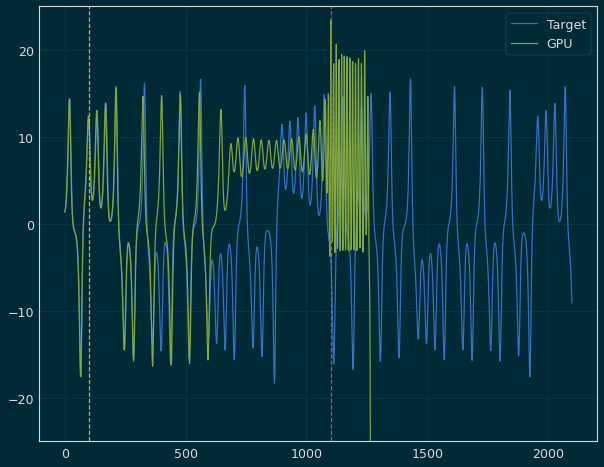

 Iter=53 a=0.466 sr=2.814 amp=0.923  ri=0.197 rr=2.262 loss=0.740160


Iter: 53 #### Diagnostic 0.740160   Time 4.52  Best 0.740 NRMSE 0.212 CD 0.528
Iter: 54 #### Diagnostic 1.378167   Time 4.20  Best 0.740 NRMSE 0.326 CD 1.053
Iter: 55 #### Diagnostic 1000.000000   Time 4.42  Best 0.740 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.403409   Time 4.96  Best 0.740 NRMSE 0.340 CD 1.063
Iter: 57 #### Diagnostic 1.420983   Time 4.39  Best 0.740 NRMSE 0.339 CD 1.082
Iter: 58 #### Diagnostic 1000.000000   Time 4.27  Best 0.740 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.62  Best 0.740 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 5.05  Best 0.740 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.18  Best 0.740 NRMSE 85856278483987896079482880.000 CD 1.000
Iter: 62 #### Diagnostic 1.356572   Time 4.35  Best 0.740 NRMSE 0.360 CD 0.996
Iter: 63 #### Diagnostic 1.285666   Time 4.38  Best 0.740 NRMSE 0.298 CD 0.987
Iter: 64 #### Di

Iter: 49 #### Diagnostic 1.400712   Time 4.15  Best 1000.000 NRMSE 0.344 CD 1.057
Iter: 50 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.340120   Time 4.28  Best 1000.000 NRMSE 0.329 CD 1.012
Iter: 52 #### Diagnostic 1.428982   Time 4.41  Best 1000.000 NRMSE 0.362 CD 1.067
Iter: 53 #### Diagnostic 1.268176   Time 3.93  Best 1000.000 NRMSE 0.291 CD 0.978
Iter: 54 #### Diagnostic 1.306278   Time 4.89  Best 1000.000 NRMSE 0.296 CD 1.010
Iter: 55 #### Diagnostic 1.383918   Time 4.04  Best 1000.000 NRMSE 0.337 CD 1.047
Iter: 56 #### Diagnostic 1.208780   Time 4.37  Best 1000.000 NRMSE 0.282 CD 0.927
Iter: 57 #### Diagnostic 1.321710   Time 3.80  Best 1000.000 NRMSE 0.296 CD 1.026
Iter: 58 #### Diagnostic 1.199180   Time 4.81  Best 1000.000 NRMSE 0.272 CD 0.928
Iter: 59 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.575035   Time 4.25  Best 1000.000 NRMSE 0.473 CD 1.102
Iter: 61

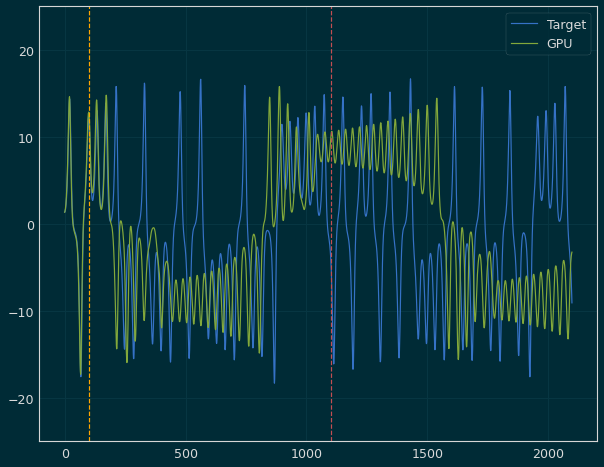

 Iter=87 a=0.289 sr=3.681 amp=0.729  ri=0.839 rr=3.738 loss=0.797222


Iter: 87 #### Diagnostic 0.797222   Time 4.36  Best 0.797 NRMSE 0.221 CD 0.576
Iter: 88 #### Diagnostic 1.155686   Time 4.10  Best 0.797 NRMSE 0.320 CD 0.836
Iter: 89 #### Diagnostic 1.379533   Time 4.09  Best 0.797 NRMSE 0.317 CD 1.063
Iter: 90 #### Diagnostic 1000.000000   Time 4.15  Best 0.797 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.383103   Time 4.54  Best 0.797 NRMSE 0.308 CD 1.075
Iter: 92 #### Diagnostic 1000.000000   Time 4.97  Best 0.797 NRMSE 35644714568658252.000 CD 1.000
Iter: 93 #### Diagnostic 1000.000000   Time 4.19  Best 0.797 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 3.96  Best 0.797 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.363503   Time 4.02  Best 0.797 NRMSE 0.316 CD 1.047
Iter: 96 #### Diagnostic 1.298322   Time 4.00  Best 0.797 NRMSE 0.295 CD 1.004
Iter: 97 #### Diagnostic 1.102558   Time 4.04  Best 0.797 NRMSE 0.272 CD 0.830
Iter: 98 #### Diagnostic 1.26

Iter: 75 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.304338   Time 4.34  Best 1000.000 NRMSE 0.297 CD 1.007
Iter: 77 #### Diagnostic 1.412035   Time 4.19  Best 1000.000 NRMSE 0.335 CD 1.077
Iter: 78 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 5.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.290943   Time 4.55  Best 1000.000 NRMSE 0.290 CD 1.001
Iter: 83 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 4.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.526387   Time 5.75  Best 1000.000 NRMSE 0.352 CD 1.175
Iter: 86 #### Diagnostic 1000.000000   Time 4.74  Best 1000.000 NRMSE 

Iter: 70 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.435258   Time 4.24  Best 1000.000 NRMSE 0.324 CD 1.111
Iter: 74 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.284929   Time 4.86  Best 1000.000 NRMSE 0.282 CD 1.003
Iter: 76 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.329328   Time 4.09  Best 1000.000 NRMSE 0.342 CD 0.987
Iter: 78 #### Diagnostic 1.194921   Time 3.87  Best 1000.000 NRMSE 0.345 CD 0.850
Iter: 79 #### Diagnostic 1.114893   Time 4.00  Best 1000.000 NRMSE 0.290 CD 0.825
Iter: 80 #### Diagnostic 1.064280   Time 4.12  Best 1000.000 NRMSE 0.263 CD 0.801
Iter: 81 #### Diagnostic 1.248518   Time 4.18  Best 1000.000 NRMSE 0.284 CD 0.

Iter: 65 #### Diagnostic 1.492252   Time 5.55  Best 1000.000 NRMSE 0.318 CD 1.175
Iter: 66 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 888528951676005.875 CD 0.915
Iter: 67 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 156992188054937082552909824.000 CD 1.000
Iter: 72 #### Diagnostic 1.361955   Time 4.23  Best 1000.000 NRMSE 0.292 CD 1.070
Iter: 73 #### Diagnostic 1.551034   Time 4.26  Best 1000.000 NRMSE 0.324 CD 1.227
Iter: 74 #### Diagnostic 1000.000000   Time 4.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.259009   Time 4.45  Best 1000.000 NRMSE 0.285 CD 0.974
Iter: 76 #### Diagnostic 1000.00

Iter: 60 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.754734   Time 4.20  Best 1000.000 NRMSE 0.350 CD 1.405
Iter: 62 #### Diagnostic 1.266502   Time 4.18  Best 1000.000 NRMSE 0.294 CD 0.972
Iter: 63 #### Diagnostic 1.084717   Time 4.91  Best 1000.000 NRMSE 0.266 CD 0.819
Iter: 64 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.282405   Time 4.34  Best 1000.000 NRMSE 0.287 CD 0.996
Iter: 66 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 7.165862   Time 4.24  Best 1000.000 NRMSE 6.170 CD 0.996
Iter: 71 #### Diagnostic 1.350617   Time 4.03  Best 1000.000 NRMSE 0.305 C

Iter: 56 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.243480   Time 4.78  Best 1000.000 NRMSE 0.277 CD 0.966
Iter: 59 #### Diagnostic 1.293437   Time 4.17  Best 1000.000 NRMSE 0.294 CD 0.999
Iter: 60 #### Diagnostic 1.084762   Time 4.18  Best 1000.000 NRMSE 0.265 CD 0.819
Iter: 61 #### Diagnostic 1.355398   Time 5.02  Best 1000.000 NRMSE 0.302 CD 1.053
Iter: 62 #### Diagnostic 878.720399   Time 4.30  Best 1000.000 NRMSE 877.584 CD 1.136
Iter: 63 #### Diagnostic 1.030049   Time 4.11  Best 1000.000 NRMSE 0.255 CD 0.775
Iter: 64 #### Diagnostic 1.393824   Time 4.13  Best 1000.000 NRMSE 0.287 CD 1.106
Iter: 65 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.262565   Time 4.33  Best 1000.000 NRMSE 0.290 CD 0.973
Iter: 67 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD 

Iter: 48 #### Diagnostic 1.360072   Time 4.19  Best 1000.000 NRMSE 0.306 CD 1.054
Iter: 49 #### Diagnostic 646.777100   Time 4.20  Best 1000.000 NRMSE 645.790 CD 0.987
Iter: 50 #### Diagnostic 1.138552   Time 4.12  Best 1000.000 NRMSE 0.273 CD 0.865
Iter: 51 #### Diagnostic 1.438439   Time 4.18  Best 1000.000 NRMSE 0.335 CD 1.103
Iter: 52 #### Diagnostic 1000.000000   Time 4.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.462458   Time 4.02  Best 1000.000 NRMSE 0.362 CD 1.100
Iter: 54 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.407589   Time 4.25  Best 1000.000 NRMSE 0.333 CD 1.074
Iter: 57 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000

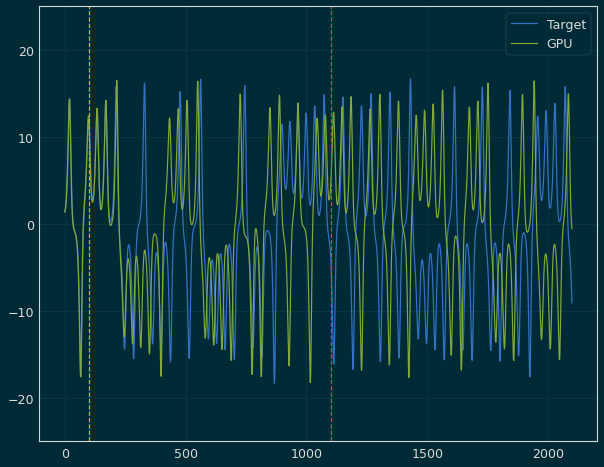

 Iter=63 a=0.564 sr=4.678 amp=0.402  ri=0.118 rr=0.586 loss=0.791020


Iter: 63 #### Diagnostic 0.791020   Time 4.87  Best 0.791 NRMSE 0.222 CD 0.569
Iter: 64 #### Diagnostic 1000.000000   Time 4.51  Best 0.791 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 4.47  Best 0.791 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 4.36  Best 0.791 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.57  Best 0.791 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.932608   Time 4.41  Best 0.791 NRMSE 0.952 CD 0.980
Iter: 69 #### Diagnostic 1000.000000   Time 4.24  Best 0.791 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.330413   Time 4.14  Best 0.791 NRMSE 0.296 CD 1.034
Iter: 71 #### Diagnostic 1000.000000   Time 4.32  Best 0.791 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.355711   Time 4.28  Best 0.791 NRMSE 0.294 CD 1.062
Iter: 73 #### Diagnostic 1.538497   Time 4.56  Best 0.791 NRMSE 0.559 CD 0.980
Iter: 74 #### Diagnostic 1000.000000

Iter: 59 #### Diagnostic 1.394734   Time 4.97  Best 1000.000 NRMSE 0.308 CD 1.087
Iter: 60 #### Diagnostic 3.012097   Time 4.24  Best 1000.000 NRMSE 2.026 CD 0.986
Iter: 61 #### Diagnostic 1000.000000   Time 4.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.143731   Time 4.21  Best 1000.000 NRMSE 0.273 CD 0.871
Iter: 65 #### Diagnostic 1.210747   Time 4.48  Best 1000.000 NRMSE 0.222 CD 0.988
Iter: 66 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 4761741308116149.000 CD 0.977
Iter: 68 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 17.802608   Time 4.46  Best 100

Iter: 54 #### Diagnostic 1.059412   Time 4.62  Best 1000.000 NRMSE 0.261 CD 0.799
Iter: 55 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.298027   Time 4.06  Best 1000.000 NRMSE 0.289 CD 1.009
Iter: 59 #### Diagnostic 1.420177   Time 4.24  Best 1000.000 NRMSE 0.306 CD 1.115
Iter: 60 #### Diagnostic 1.315083   Time 4.27  Best 1000.000 NRMSE 0.293 CD 1.023
Iter: 61 #### Diagnostic 1.339578   Time 4.08  Best 1000.000 NRMSE 0.296 CD 1.043
Iter: 62 #### Diagnostic 1.515035   Time 4.22  Best 1000.000 NRMSE 0.504 CD 1.011
Iter: 63 #### Diagnostic 1000.000000   Time 5.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.348900   Time 4.33  Best 1000.000 NRMSE 0.307 CD 1.

Iter: 49 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.183919   Time 4.26  Best 1000.000 NRMSE 0.283 CD 0.901
Iter: 52 #### Diagnostic 1.348237   Time 4.16  Best 1000.000 NRMSE 0.307 CD 1.042
Iter: 53 #### Diagnostic 1.051076   Time 4.28  Best 1000.000 NRMSE 0.264 CD 0.787
Iter: 54 #### Diagnostic 1.291311   Time 4.45  Best 1000.000 NRMSE 0.324 CD 0.967
Iter: 55 #### Diagnostic 1000.000000   Time 4.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.405977   Time 4.65  Best 1000.000 NRMSE 0.339 CD 1.067
Iter: 57 #### Diagnostic 1.078920   Time 4.20  Best 1000.000 NRMSE 0.272 CD 0.807
Iter: 58 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.60  Best 1000.000 NRMSE 1000.000

Iter: 44 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.75  Best 1000.000 NRMSE 3032837007257296418373632000.000 CD 1.000
Iter: 47 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.370868   Time 4.88  Best 1000.000 NRMSE 0.316 CD 1.055
Iter: 49 #### Diagnostic 1.400752   Time 4.25  Best 1000.000 NRMSE 0.340 CD 1.061
Iter: 50 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.366426   Time 4.41  Best 1000.000 NRMSE 0.333 CD 1.033
Iter: 52 #### Diagnostic 1.394550   Time 4.23  Best 1000.000 NRMSE 0.330 CD 1.064
Iter: 53 #### Diagnostic 1.299198   Time 4.08  Best 1000.000 NRMSE 0.297 CD 1.002
Iter: 54 #### Diagnostic 1.327957   Time 4.21  Best 1000.000 NRMSE 0.290 CD 1.038
Iter: 55 #### Diagnostic 1.424807   Time 4.23  Best 

Iter: 32 #### Diagnostic 1.491352   Time 4.09  Best 1000.000 NRMSE 0.337 CD 1.154
Iter: 33 #### Diagnostic 1.406942   Time 4.25  Best 1000.000 NRMSE 0.301 CD 1.106
Iter: 34 #### Diagnostic 1.416358   Time 4.26  Best 1000.000 NRMSE 0.345 CD 1.071
Iter: 35 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.366775   Time 4.08  Best 1000.000 NRMSE 0.300 CD 1.066
Iter: 38 #### Diagnostic 1.185217   Time 4.24  Best 1000.000 NRMSE 0.295 CD 0.891
Iter: 39 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.061035   Time 4.53  Best 1000.000 NRMSE 0.269 CD 0.792
Iter: 41 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.262421   Time 4.73  Best 1000.000 NRMSE 0.273 CD 0.989
Iter: 43 #### Diagnostic 1000.000000   Time 4.35  Best 1000.000 NRMSE 1000.000 CD 

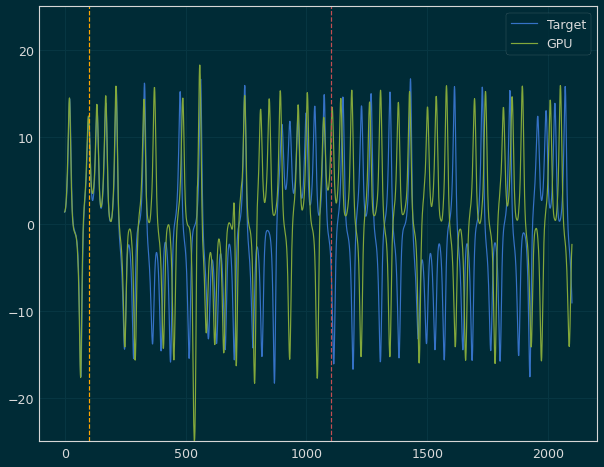

 Iter=71 a=0.438 sr=7.860 amp=0.226  ri=0.823 rr=2.775 loss=0.741419


Iter: 71 #### Diagnostic 0.741419   Time 4.55  Best 0.741 NRMSE 0.216 CD 0.525
Iter: 72 #### Diagnostic 0.978233   Time 4.82  Best 0.741 NRMSE 0.254 CD 0.724
Iter: 73 #### Diagnostic 1.102393   Time 4.09  Best 0.741 NRMSE 0.270 CD 0.833
Iter: 74 #### Diagnostic 1000.000000   Time 4.06  Best 0.741 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 4.18  Best 0.741 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.259975   Time 4.01  Best 0.741 NRMSE 0.284 CD 0.976
Iter: 77 #### Diagnostic 1.398384   Time 4.12  Best 0.741 NRMSE 0.332 CD 1.066
Iter: 78 #### Diagnostic 1000.000000   Time 4.12  Best 0.741 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 4.19  Best 0.741 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.240290   Time 4.26  Best 0.741 NRMSE 0.277 CD 0.963
Iter: 81 #### Diagnostic 1.308314   Time 3.96  Best 0.741 NRMSE 0.306 CD 1.002
Iter: 82 #### Diagnostic 1.371541   Time 4.0

Iter: 67 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.300863   Time 3.99  Best 1000.000 NRMSE 0.293 CD 1.008
Iter: 71 #### Diagnostic 1.323171   Time 3.97  Best 1000.000 NRMSE 0.303 CD 1.020
Iter: 72 #### Diagnostic 1.711416   Time 4.57  Best 1000.000 NRMSE 0.758 CD 0.954
Iter: 73 #### Diagnostic 1.369583   Time 5.44  Best 1000.000 NRMSE 0.312 CD 1.058
Iter: 74 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.096001   Time 4.09  Best 1000.000 NRMSE 0.252 CD 0.844
Iter: 76 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 0.957588   Time 3.98  Best 1000.000 NRMSE 0.248 CD 0.709
Iter: 78 #### Diagnostic 1.288170   Time 3.95  Best 1000.000 NRMSE 0.276 CD 1.

Iter: 63 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.195325   Time 3.89  Best 1000.000 NRMSE 0.266 CD 0.929
Iter: 65 #### Diagnostic 1.308641   Time 3.98  Best 1000.000 NRMSE 0.277 CD 1.032
Iter: 66 #### Diagnostic 1.403283   Time 4.15  Best 1000.000 NRMSE 0.348 CD 1.055
Iter: 67 #### Diagnostic 1.173959   Time 4.22  Best 1000.000 NRMSE 0.273 CD 0.901
Iter: 68 #### Diagnostic 1.299438   Time 4.04  Best 1000.000 NRMSE 0.295 CD 1.004
Iter: 69 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.214351   Time 4.11  Best 1000.000 NRMSE 0.281 CD 0.933
Iter: 71 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 470406698809381156785689198592.000 CD 1.000
Iter: 72 #### Diagnostic 1.054218   Time 4.07  Best 1000.000 NRMSE 0.241 CD 0.813
Iter: 73 #### Diagnostic 1.285327   Time 4.18  Best 1000.000 NRMSE 0.292 CD 0.993
Iter: 74 #### Diagnostic 1.134549   Time 4.27  Best 1000.0

Iter: 59 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.325115   Time 3.79  Best 1000.000 NRMSE 0.281 CD 1.044
Iter: 62 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.253671   Time 5.59  Best 1000.000 NRMSE 0.336 CD 0.917
Iter: 64 #### Diagnostic 1.300881   Time 5.50  Best 1000.000 NRMSE 0.301 CD 1.000
Iter: 65 #### Diagnostic 1.079487   Time 4.93  Best 1000.000 NRMSE 0.254 CD 0.825
Iter: 66 #### Diagnostic 1.189768   Time 4.00  Best 1000.000 NRMSE 0.294 CD 0.896
Iter: 67 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.338451   Time 4.08  Best 1000.000 NRMSE 0.295 CD 1.044
Iter: 70 #### Diagnostic 21.102718   Time 4.16  Best 1000.000 NRMSE 19.969 CD 

Iter: 55 #### Diagnostic 1000.000000   Time 3.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.389161   Time 3.86  Best 1000.000 NRMSE 0.328 CD 1.061
Iter: 57 #### Diagnostic 1.083396   Time 3.92  Best 1000.000 NRMSE 0.298 CD 0.786
Iter: 58 #### Diagnostic 1.302880   Time 4.05  Best 1000.000 NRMSE 0.284 CD 1.019
Iter: 59 #### Diagnostic 1.424304   Time 3.80  Best 1000.000 NRMSE 0.308 CD 1.117
Iter: 60 #### Diagnostic 1.358925   Time 3.91  Best 1000.000 NRMSE 0.298 CD 1.061
Iter: 61 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 8514501322650.892 CD 1.172
Iter: 63 #### Diagnostic 1.405036   Time 3.85  Best 1000.000 NRMSE 0.330 CD 1.075
Iter: 64 #### Diagnostic 1.123808   Time 3.90  Best 1000.000 NRMSE 0.246 CD 0.878
Iter: 65 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.072817   Time 3.90  Best 1000.000 NRMSE 0.26

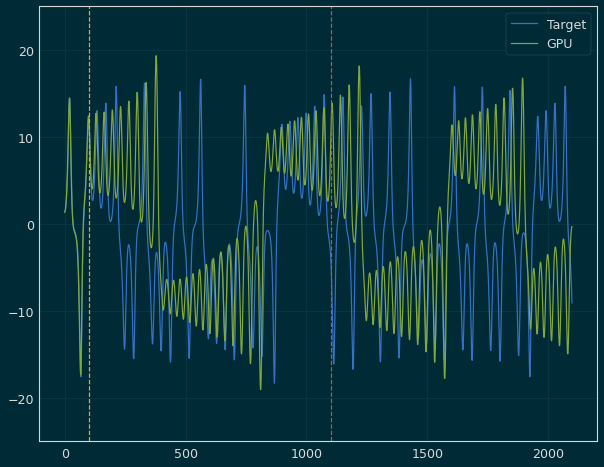

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.809864


Iter: 30 #### Diagnostic 0.809864   Time 4.57  Best 0.810 NRMSE 0.232 CD 0.578
Iter: 31 #### Diagnostic 1.044090   Time 3.91  Best 0.810 NRMSE 0.266 CD 0.778
Iter: 32 #### Diagnostic 1.153938   Time 3.95  Best 0.810 NRMSE 0.285 CD 0.869
Iter: 33 #### Diagnostic 1.331697   Time 3.98  Best 0.810 NRMSE 0.292 CD 1.040
Iter: 34 #### Diagnostic 1.488699   Time 3.96  Best 0.810 NRMSE 0.350 CD 1.138
Iter: 35 #### Diagnostic 1000.000000   Time 3.88  Best 0.810 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 3.93  Best 0.810 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.362131   Time 3.96  Best 0.810 NRMSE 0.307 CD 1.055
Iter: 38 #### Diagnostic 1000.000000   Time 3.86  Best 0.810 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.439538   Time 3.86  Best 0.810 NRMSE 0.360 CD 1.079
Iter: 40 #### Diagnostic 1.322912   Time 4.00  Best 0.810 NRMSE 0.300 CD 1.023
Iter: 41 #### Diagnostic 1000.000000   Time 4.28

Iter: 28 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 40.976933   Time 4.06  Best 1000.000 NRMSE 40.003 CD 0.974
Iter: 30 #### Diagnostic 1.204015   Time 4.06  Best 1000.000 NRMSE 0.275 CD 0.929
Iter: 31 #### Diagnostic 1.307251   Time 3.94  Best 1000.000 NRMSE 0.306 CD 1.001
Iter: 32 #### Diagnostic 1.380558   Time 4.31  Best 1000.000 NRMSE 0.320 CD 1.061
Iter: 33 #### Diagnostic 1.402960   Time 4.29  Best 1000.000 NRMSE 0.309 CD 1.094
Iter: 34 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.567974   Time 4.16  Best 1000.000 NRMSE 0.488 CD 1.080
Iter: 36 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.461616   Time 3.99  Best 1000.000 NRMSE 0.322 CD 1.140
Iter: 38 #### Diagnostic 1.374378   Time 3.97  Best 1000.000 NRMSE 0.319 CD 1.056
Iter: 39 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD na

Iter: 24 #### Diagnostic 1.405146   Time 4.08  Best 1000.000 NRMSE 0.332 CD 1.074
Iter: 25 #### Diagnostic 1.413753   Time 4.09  Best 1000.000 NRMSE 0.349 CD 1.065
Iter: 26 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.048593   Time 4.12  Best 1000.000 NRMSE 0.266 CD 0.783
Iter: 28 #### Diagnostic 1000.000000   Time 4.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.222992   Time 4.22  Best 1000.000 NRMSE 0.285 CD 0.938
Iter: 32 #### Diagnostic 1.351671   Time 4.20  Best 1000.000 NRMSE 0.310 CD 1.042
Iter: 33 #### Diagnostic 1.331952   Time 4.64  Best 1000.000 NRMSE 0.286 CD 1.046
Iter: 34 #### Diagnostic 1.288674   Time 4.19  Best 1000.000 NRMSE 0.294 CD 0.995
Iter: 35 #### Diagnostic 1.386165   Time 4.18  Best 1000.000 NRMSE 0.317 CD 1.069


Iter: 20 #### Diagnostic 1.169470   Time 4.11  Best 1000.000 NRMSE 0.276 CD 0.893
Iter: 21 #### Diagnostic 1.365565   Time 4.11  Best 1000.000 NRMSE 0.315 CD 1.050
Iter: 22 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.165622   Time 4.03  Best 1000.000 NRMSE 0.266 CD 0.899
Iter: 24 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.377189   Time 4.09  Best 1000.000 NRMSE 0.312 CD 1.066
Iter: 28 #### Diagnostic 1.234680   Time 4.01  Best 1000.000 NRMSE 0.287 CD 0.948
Iter: 29 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.374087   Time 4.02  Best 1000.000 NRMSE 0.306 CD 1.068
Iter: 31 #### Diagnostic 1.262720   Time 4.09  Best 1000.000 NRMSE 0.312 CD 0.

Iter: 16 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.542721   Time 4.27  Best 1000.000 NRMSE 0.570 CD 0.973
Iter: 18 #### Diagnostic 1.665436   Time 4.26  Best 1000.000 NRMSE 0.334 CD 1.331
Iter: 19 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.305313   Time 4.20  Best 1000.000 NRMSE 0.281 CD 1.025
Iter: 21 #### Diagnostic 1000.000000   Time 4.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.379149   Time 4.31  Best 1000.000 NRMSE 0.316 CD 1.063
Iter: 23 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.344372   Time 4.18  Best 1000.000 NRMSE 0.308 CD 1.037
Iter: 26 #### Diagnostic 1.396967   Time 4.11  Best 1000.000 NRMSE 0.340 CD 1.057
Iter: 27 #### Diagnostic 1.216530   Time 4.13  Best 1000.000 NRMSE 0.299 CD 0.

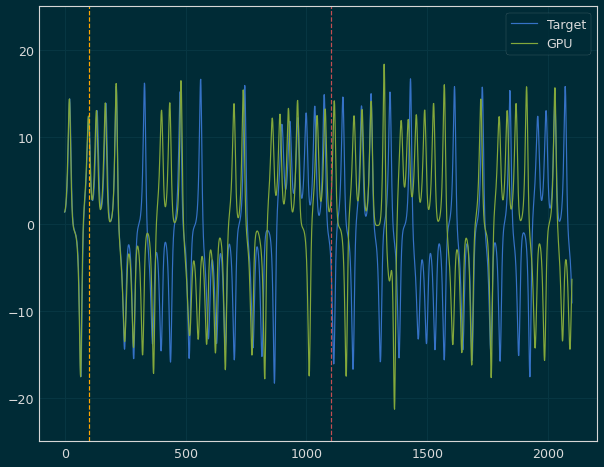

 Iter=97 a=0.554 sr=1.571 amp=0.984  ri=0.084 rr=1.575 loss=0.778528


Iter: 97 #### Diagnostic 0.778528   Time 4.24  Best 0.779 NRMSE 0.219 CD 0.559
Iter: 98 #### Diagnostic 1.186940   Time 4.53  Best 0.779 NRMSE 0.313 CD 0.874
Iter: 99 #### Diagnostic 1.482191   Time 4.11  Best 0.779 NRMSE 0.314 CD 1.169

Best result = 0.7785277407443437
a = 0.5539279701476771
sr = 1.5711211051732081
amp = 0.9839900540226644
ri = 0.08385528723101854
rr = 1.5751937570155508

Best mn:0.037	 mn:0.554
New bounds mn--mx: -0.091--0.083

Best mn:1.571	 mn:2.881
New bounds mn--mx: -1.180--2.525

Best mn:0.070	 mn:0.984
New bounds mn--mx: -0.021---0.186

Best mn:0.084	 mn:0.724
New bounds mn--mx: -0.164--0.094

Best mn:0.178	 mn:1.575
New bounds mn--mx: -0.605--1.156
Refined search bounds:

Alpha (0.1283986063386437, 0.6365380928150803)

Rho (2.7508818583267676, 5.405331269844742)

Gamma (0.09188441425831922, 0.7983800237678728)

r-in (0.24791955750327108, 0.8176824978222975)

r-res (0.7828669135656733, 2.731

Iter: 85 #### Diagnostic 1.075497   Time 4.13  Best 1000.000 NRMSE 0.270 CD 0.805
Iter: 86 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.238141   Time 4.30  Best 1000.000 NRMSE 0.283 CD 0.955
Iter: 88 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.298106   Time 4.00  Best 1000.000 NRMSE 0.302 CD 0.996
Iter: 90 #### Diagnostic 12.274690   Time 4.17  Best 1000.000 NRMSE 11.161 CD 1.114
Iter: 91 #### Diagnostic 1.386856   Time 4.13  Best 1000.000 NRMSE 0.317 CD 1.070
Iter: 92 #### Diagnostic 1000.000000   Time 4.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 4.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.387222   Time 4.17  Best 1000.000 NRMSE 0.328 CD 1.060
Iter: 95 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.0

Iter: 80 #### Diagnostic 1.135675   Time 4.13  Best 1000.000 NRMSE 0.288 CD 0.847
Iter: 81 #### Diagnostic 1.229332   Time 4.09  Best 1000.000 NRMSE 0.290 CD 0.940
Iter: 82 #### Diagnostic 1.355946   Time 4.07  Best 1000.000 NRMSE 0.303 CD 1.053
Iter: 83 #### Diagnostic 1000.000000   Time 4.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.314149   Time 4.08  Best 1000.000 NRMSE 0.276 CD 1.038
Iter: 85 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1.080177   Time 4.16  Best 1000.000 NRMSE 0.263 CD 0.817
Iter: 87 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.281528   Time 4.47  Best 1000.000 NRMSE 0.301 CD 0.981
Iter: 89 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 8.933497   Time 4.14  Best 1000.000 NRMSE 7.928 CD 1.

Iter: 75 #### Diagnostic 1.077866   Time 4.06  Best 1000.000 NRMSE 0.249 CD 0.829
Iter: 76 #### Diagnostic 1.498096   Time 4.77  Best 1000.000 NRMSE 0.331 CD 1.167
Iter: 77 #### Diagnostic 1.133550   Time 4.10  Best 1000.000 NRMSE 0.274 CD 0.860
Iter: 78 #### Diagnostic 1000.000000   Time 4.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 23.669209   Time 4.18  Best 1000.000 NRMSE 22.739 CD 0.930
Iter: 80 #### Diagnostic 1.317432   Time 4.24  Best 1000.000 NRMSE 0.308 CD 1.009
Iter: 81 #### Diagnostic 69.955401   Time 4.14  Best 1000.000 NRMSE 69.039 CD 0.917
Iter: 82 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.308518   Time 4.06  Best 1000.000 NRMSE 0.287 CD 1.022
Iter: 84 #### Diagnostic 1.367475   Time 4.06  Best 1000.000 NRMSE 0.309 CD 1.058
Iter: 85 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD 

Iter: 71 #### Diagnostic 1.395368   Time 4.63  Best 1000.000 NRMSE 0.329 CD 1.067
Iter: 72 #### Diagnostic 1.380862   Time 4.27  Best 1000.000 NRMSE 0.383 CD 0.998
Iter: 73 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.321834   Time 4.10  Best 1000.000 NRMSE 0.273 CD 1.048
Iter: 75 #### Diagnostic 1.288246   Time 4.04  Best 1000.000 NRMSE 0.287 CD 1.002
Iter: 76 #### Diagnostic 1.358168   Time 4.39  Best 1000.000 NRMSE 0.295 CD 1.064
Iter: 77 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.456329   Time 4.36  Best 1000.000 NRMSE 0.318 CD 1.139
Iter: 79 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.207311   Time 4.05  Best 1000.000 NRMSE 0.240 CD 0.967
Iter: 81 #### Diagnostic 1.138396   Time 4.16  Best 1000.000 NRMSE 0.272 CD 0.867
Iter: 82 #### Diagnostic 1.223589   Time 4.46  Best 1000.000 NRMSE 0.292 CD 0.931
Iter

Iter: 68 #### Diagnostic 1.349349   Time 4.19  Best 1000.000 NRMSE 0.302 CD 1.048
Iter: 69 #### Diagnostic 1.386199   Time 4.26  Best 1000.000 NRMSE 0.325 CD 1.061
Iter: 70 #### Diagnostic 1.291751   Time 4.10  Best 1000.000 NRMSE 0.294 CD 0.998
Iter: 71 #### Diagnostic 1.123444   Time 4.20  Best 1000.000 NRMSE 0.264 CD 0.859
Iter: 72 #### Diagnostic 1.298154   Time 4.12  Best 1000.000 NRMSE 0.294 CD 1.004
Iter: 73 #### Diagnostic 1.180035   Time 4.31  Best 1000.000 NRMSE 0.271 CD 0.909
Iter: 74 #### Diagnostic 1.382704   Time 4.10  Best 1000.000 NRMSE 0.304 CD 1.078
Iter: 75 #### Diagnostic 1.396404   Time 4.41  Best 1000.000 NRMSE 0.529 CD 0.867
Iter: 76 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.374683   Time 4.09  Best 1000.000 NRMSE 0.326 CD 1.049
Iter: 78 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 2.449859   Time 4.09  Best 1000.000 NRMSE 1.320 CD 1.130
Iter: 80

Iter: 60 #### Diagnostic 1000.000000   Time 4.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.377169   Time 4.17  Best 1000.000 NRMSE 0.316 CD 1.061
Iter: 62 #### Diagnostic 5.355664   Time 4.13  Best 1000.000 NRMSE 4.372 CD 0.984
Iter: 63 #### Diagnostic 1.018985   Time 4.04  Best 1000.000 NRMSE 0.267 CD 0.752
Iter: 64 #### Diagnostic 1000.000000   Time 4.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.389597   Time 4.03  Best 1000.000 NRMSE 0.331 CD 1.058
Iter: 71 #### Diagnostic 1.227553   Time 4.07  Best 1000.000 NRMSE 0.2

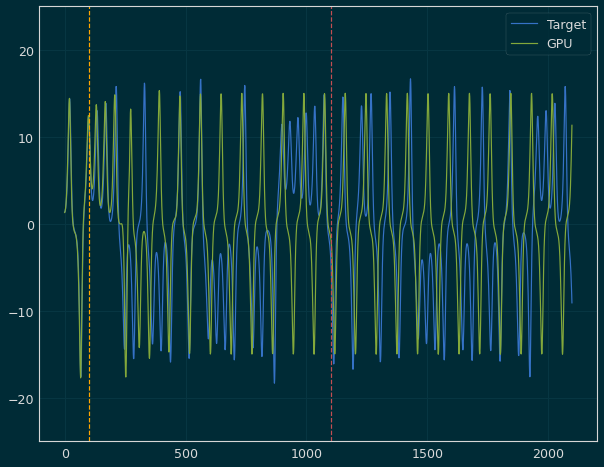

 Iter=54 a=0.460 sr=3.909 amp=0.424  ri=0.677 rr=0.258 loss=0.847537


Iter: 54 #### Diagnostic 0.847537   Time 4.41  Best 0.848 NRMSE 0.224 CD 0.624
Iter: 55 #### Diagnostic 1.374012   Time 4.37  Best 0.848 NRMSE 0.317 CD 1.057
Iter: 56 #### Diagnostic 1.384534   Time 3.97  Best 0.848 NRMSE 0.297 CD 1.087
Iter: 57 #### Diagnostic 1000.000000   Time 4.12  Best 0.848 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.18  Best 0.848 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.156662   Time 5.09  Best 0.848 NRMSE 0.291 CD 0.865
Iter: 60 #### Diagnostic 23.093147   Time 4.34  Best 0.848 NRMSE 22.015 CD 1.078
Iter: 61 #### Diagnostic 1000.000000   Time 4.11  Best 0.848 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.246414   Time 4.08  Best 0.848 NRMSE 0.355 CD 0.892
Iter: 63 #### Diagnostic 1.045896   Time 4.10  Best 0.848 NRMSE 0.263 CD 0.782
Iter: 64 #### Diagnostic 1.350261   Time 4.29  Best 0.848 NRMSE 0.295 CD 1.055
Iter: 65 #### Diagnostic 1.352951   Time 4.13 

In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000, 900
size = [800,700,600,500,400,300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 8.
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')

## End Model

In [ ]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [12,63,2,33,11,63,11,11,9,14,26,50,11,26,63,11,40,5,63,16]

size = [1000,900,800,700,600,500,400,300,200,100,50]

In [ ]:
TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    fn_mats = f'./MultiModelX/Mats/Lx_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelX/Params/Lx_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, K, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = np.nan_to_num(rca.reachable_matrix(A, B),0,0,0)
    spec = np.linalg.eigvals(Cplus)
    evs= np.abs(spec)
    Cplus = Cplus/np.max(evs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    #plt.plot(ave_rank)
    #plt.vlines(v,0,N)
    #plt.show()
    #plt.close
    mm_ranks.append(ave_rank)
    
np.save('./MultiModelX/Lx_MMranks',mm_ranks)

In [ ]:
large = np.load('./MultiModelX/Lx_MMranks.npy')
plt.plot(large)git 
plt.show()

In [ ]:
minmax = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelX/Preds/Lx_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    rmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST],pred[TRAINLENGTH:TRAINLENGTH+TEST],
                               squared=False, multioutput='raw_values')
    print(rmse/minmax)
    err_list.append(rmse/minmax)
np.save('./MultiModelX/Lx_mm_errors',np.array(err_list))

plt.plot(err_list)
plt.show()

In [ ]:
minmax